<a href="https://colab.research.google.com/github/Aditya-1794/Malaria-Detection-Research-Paper/blob/main/Horizon_Code_Malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/sayeemmohammed/malaria-detection')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: adityajha719
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sayeemmohammed/malaria-detection


100%|██████████| 62.8M/62.8M [00:00<00:00, 71.4MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
from glob import glob
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, EfficientNetB1
# from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.efficientnet import EfficientNetB0

import PIL
import PIL.Image

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
from tqdm import tqdm
import shutil

# Preprocessing and image augmentation


In [ ]:
#Adding more of the difficult images to the training set


In [ ]:
width, height = 92, 92
batchSize = 8 #TRAINING: 8, DATA VIS: 1

In [ ]:
def TestGenPreprocessingGamma(img, gamma=1.5):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if gray_img.dtype != np.uint8:
        gray_img = (gray_img * 255).astype(np.uint8)

    # Apply gamma correction
    inv_gamma = 1.0 / gamma
    lut = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype("uint8")
    gamma_corrected_img = cv2.LUT(gray_img, lut)

    # Convert color map to RGB
    color_mapped_img_rgb = cv2.cvtColor(gamma_corrected_img, cv2.COLOR_BGR2RGB)

    # Normalize to [0, 1] for model input
    normalized_color_mapped_img = color_mapped_img_rgb / 255.0

    return normalized_color_mapped_img


In [ ]:
data_dir = '/content/malaria-detection'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

train_datagen = ImageDataGenerator(
    #rescale=1./255,
    rotation_range=20,
    width_shift_range=0.025,
    height_shift_range=0.025,
    #removed random zoom and shear
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    #rescale=1./255
)

test_datagen = ImageDataGenerator(
    #added rescale to visualize the date (specially the errors)
    #rescale=1./255
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode='binary',
    shuffle=True
)

valid_gen = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode='binary',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode='binary',
    shuffle=False
)



Found 13152 images belonging to 2 classes.
Found 1253 images belonging to 2 classes.
Found 626 images belonging to 2 classes.


# Data Visualization

In [ ]:
print(len(train_gen))
print(len(valid_gen))
print(len(test_gen))

print(train_gen.class_indices)
print(valid_gen.class_indices)
print(test_gen.class_indices)

1644
157
79
{'Parasitized': 0, 'Uninfected': 1}
{'Parasitized': 0, 'Uninfected': 1}
{'Parasitized': 0, 'Uninfected': 1}


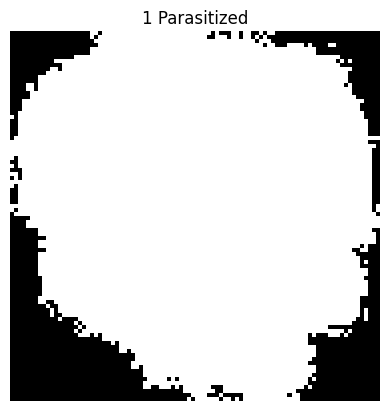

In [ ]:
def plotImg(generator, index):
    classes = ['Parasitized', 'Uninfected']
    images, labels = [], []
    while len(images) <= index:
        batch = next(generator)
        images.extend(batch[0])
        labels.extend(batch[1])

    plt.imshow(images[index])
    plt.title(f"{index} {classes[int(labels[index])]}")
    plt.axis('off')
    plt.show()

# Example usage
plotImg(test_gen, 1)


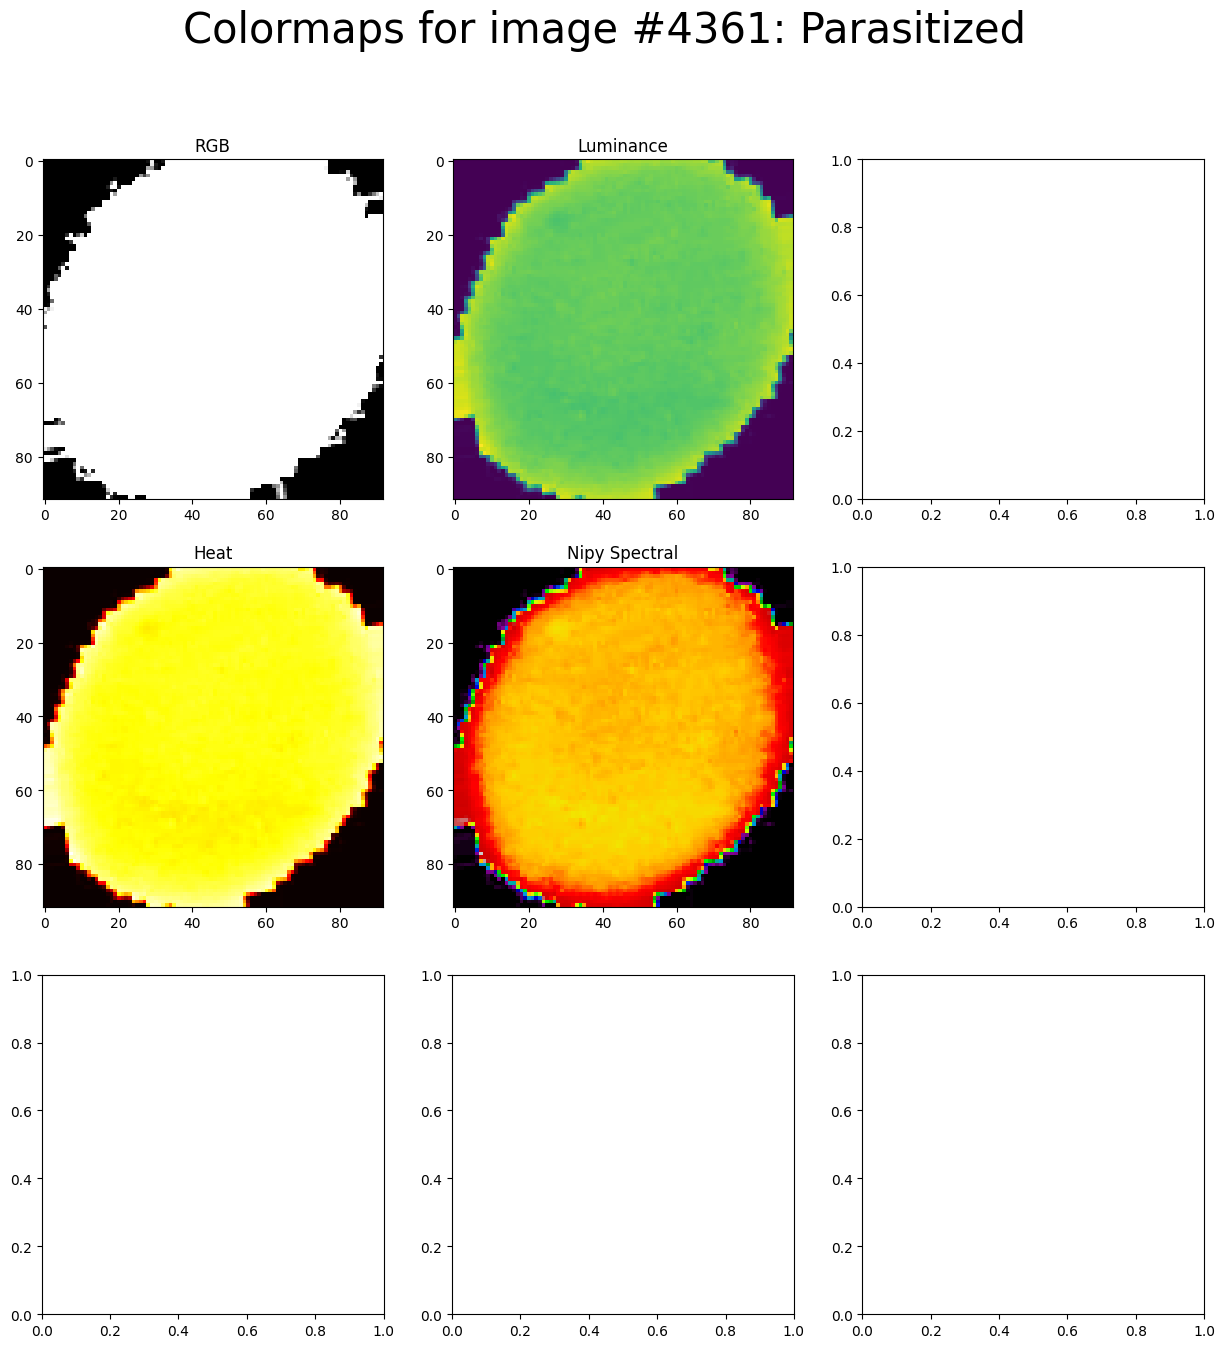

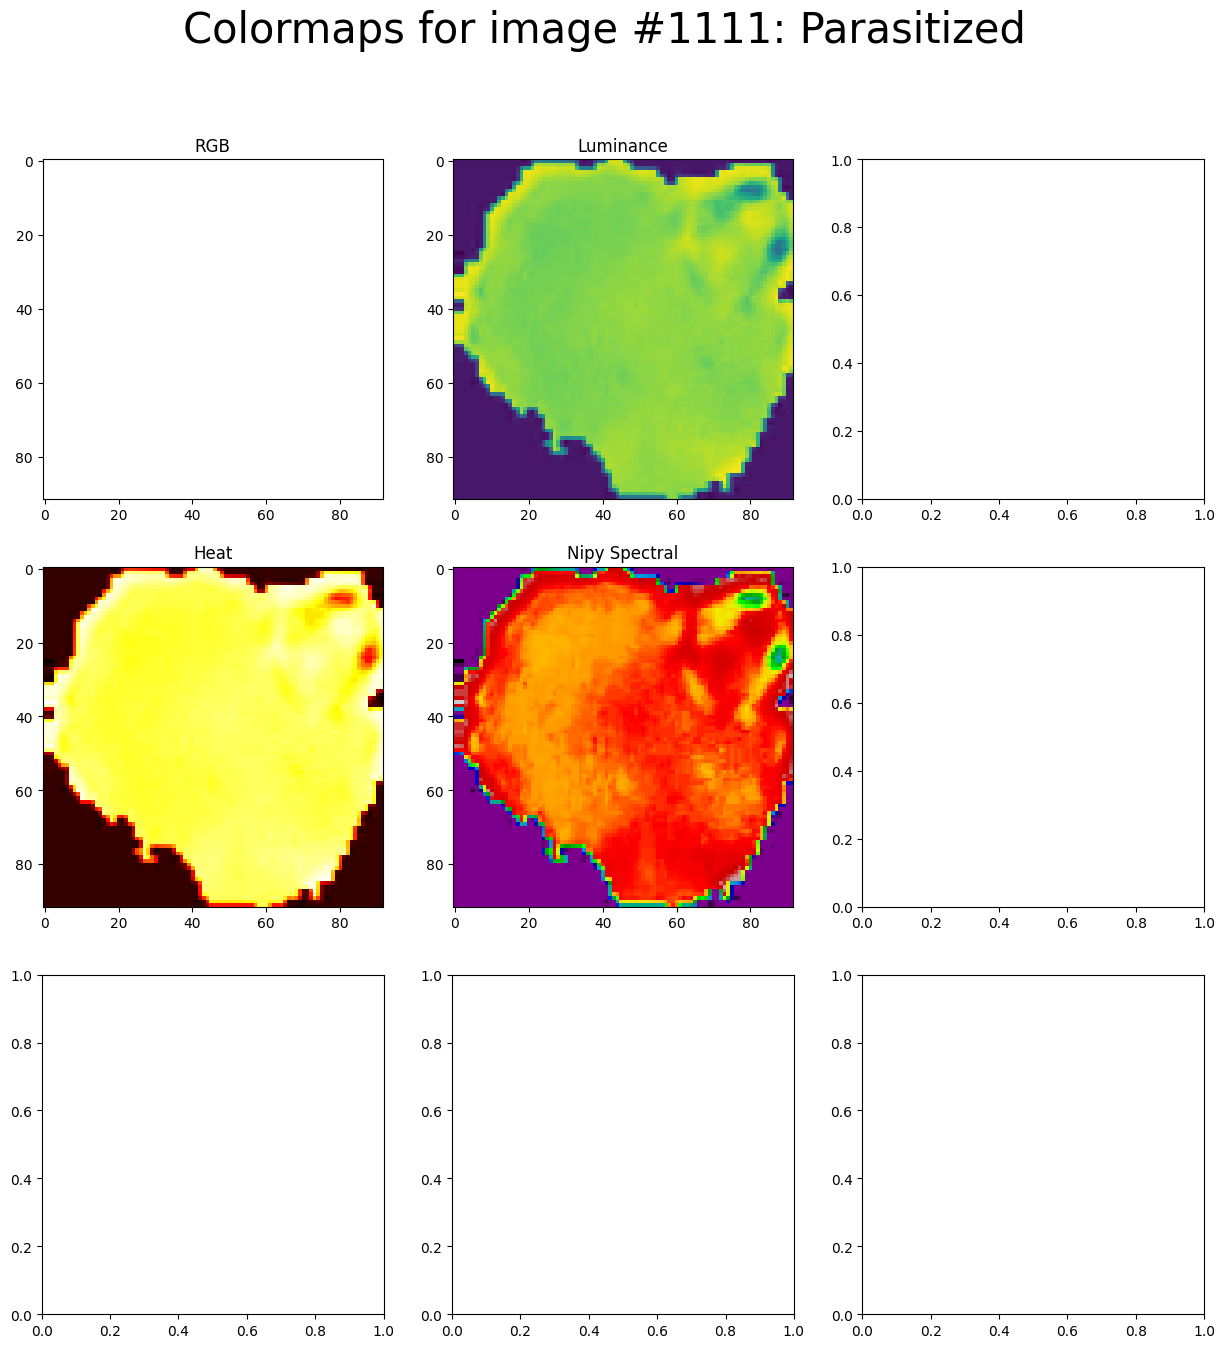

In [ ]:
#function to plot different variants of the same image
def plotColormaps(gen, index):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
    classes = ['Parasitized', 'Uninfected']
    fig.suptitle("Colormaps for image #" + str(index) + ": " + classes[gen.classes[index]], fontsize=30)
    img = gen[index][0][0]
    img_lum = img[:, :, 0]

    #rgb
    ax[0, 0].imshow(img)
    ax[0, 0].set_title('RGB')
    #luminance
    ax[0, 1].imshow(img_lum)
    ax[0, 1].set_title('Luminance')
    #heatmap
    ax[1, 0].imshow(img_lum, cmap="hot")
    ax[1, 0].set_title('Heat')
    #nipy spectral
    ax[1, 1].imshow(img_lum, cmap="nipy_spectral")
    ax[1, 1].set_title('Nipy Spectral')


#image 4361 is challenging so we can check which variant makes it more apparent that the sample is parasitized
plotColormaps(train_gen, 4361)

#check on some normal images too
plotColormaps(train_gen, 1111)

In [ ]:
import random

#random image tests
def plotImages(indecies, gen, title):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(6,6))
    classes = ['Parasitized', 'Uninfected']
    if(len(indecies) != 0):
        ptr = 0
        for i in range(3):
            for j in range(3):
                ax[i, j].imshow(gen[ptr][0][0])
                ax[i, j].set_title(classes[gen.classes[ptr]])
                ptr += 1

    else:
        if(gen == train_gen):
            upper = 13152
        elif(gen == valid_gen):
            upper = 1253
        elif(gen == test_gen):
            upper = 626
        else:
            print('invalid gen')

        ptr = random.randrange(0, upper, 1)
        for i in range(2):
            for j in range(3):
              ptr = random.randrange(0, upper//2, 1) if i == 0 else random.randrange(upper//2, upper, 1)
              ax[i, j].imshow(gen[ptr][0][0])
              ax[i, j].set_title(classes[gen.classes[ptr]])
              ax[i, j].set_xticks([])
              ax[i, j].set_yticks([])
              print(ptr, i)

    fig.suptitle(title)
    return(fig, ax)

# Intitial model training

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/25
1644/1644 [==============================] - 510s 299ms/step - loss: 0.3183 - accuracy: 0.8771 - val_loss: 0.3932 - val_accuracy: 0.9290
Epoch 2/25
1644/1644 [==============================] - 473s 288ms/step - loss: 0.2282 - accuracy: 0.9278 - val_loss: 0.4677 - val_accuracy: 0.9457
Epoch 3/25
1644/1644 [==============================] - 468s 285ms/step - loss: 0.1999 - accuracy: 0.9389 - val_loss: 0.2948 - val_accuracy: 0.9401
Epoch 4/25
1644/1644 [==============================] - 470s 286ms/step - loss: 0.1918 - accuracy: 0.9408 - val_loss: 0.3372 - val_accuracy: 0.9585
Epoch 5/25
1644/1644 [==============================] - 469s 285ms/step - loss: 0.1821 - accuracy: 0.9437 - val_loss: 0.3301 - val_accuracy: 0.9098
Epoch 6/25
1644/1644 [==============================] - 477s 290ms/step - loss: 0.1811 - accuracy: 0.9461 - val_loss: 0.1345 - val_accuracy: 0.9513
Epoch 7/25
1644/1644 [===========================

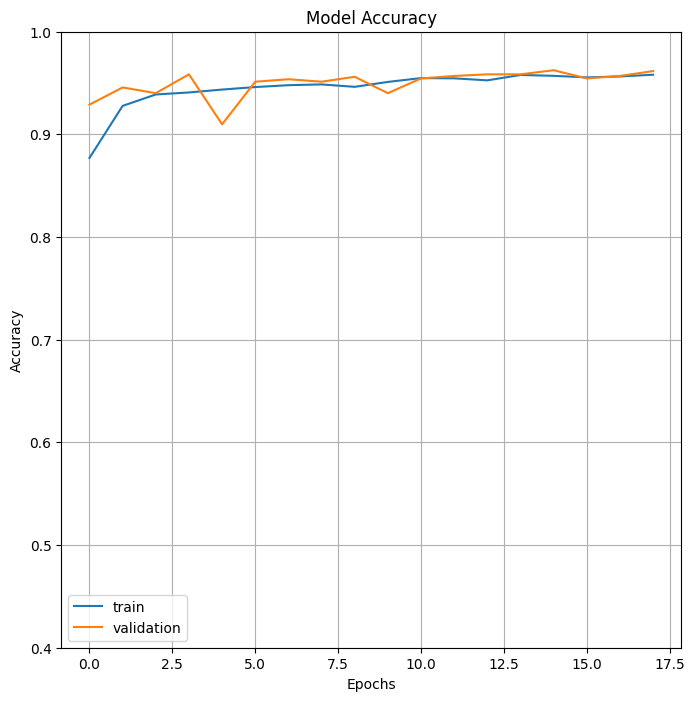

In [ ]:
#MobileNetV2 as a base model
model2 = MobileNetV2(
    input_shape=(height, width, 3),
    include_top=False,
    weights="imagenet",
)


model2.trainable = True

#new model using mobileNet
model = Sequential([
    model2,
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate = 3e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=25,
    callbacks=[early_stopping]
)

model.save("/content/drive/MyDrive/Research - Horizon/Keras models/malaria_mobilenet_v2.keras")

# Plot data
plt.figure(figsize=(8, 8))
epochs_range = range(len(history.history['accuracy']))  # Adjust the x-axis range
plt.plot(epochs_range, history.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
epochs_range = range(len(MobileNetModel.history.history['accuracy']))  # Adjust the x-axis range
plt.plot(epochs_range, MobileNetModel.history.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, MobileNetModel.history.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

AttributeError: 'NoneType' object has no attribute 'history'

<Figure size 800x800 with 0 Axes>

79/79 [==============================] - 11s 113ms/step
              precision    recall  f1-score   support

 Parasitized       0.96      0.94      0.95       309
  Uninfected       0.95      0.97      0.96       317

    accuracy                           0.96       626
   macro avg       0.96      0.96      0.96       626
weighted avg       0.96      0.96      0.96       626



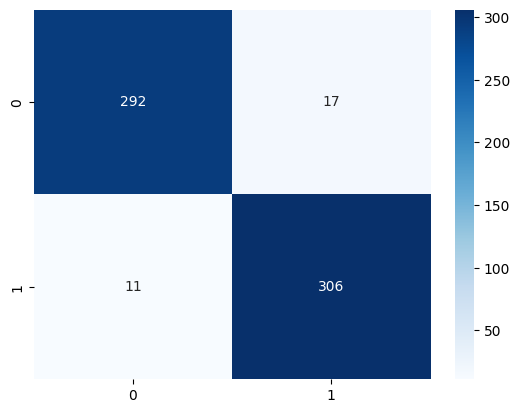

In [ ]:
Y_pred = MobileNetModel.predict(test_gen, test_gen.samples // test_gen.batch_size + 1)
y_pred = np.round(Y_pred).astype(int).flatten()
y_true = test_gen.classes

#Classification report and confusion matrix

cr = classification_report(y_true, y_pred, target_names=['Parasitized', 'Uninfected'])
print(cr)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
#EfficientNetB0/B1 as a base model
model3 = EfficientNetB0(
    input_shape=(height, width, 3),
    include_top=False,
    weights="imagenet",
)


model3.trainable = True

#new model using efficientNet
model = Sequential([
    model3,
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate = 3e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=25,
    callbacks=[early_stopping]
)

model.save("/content/drive/MyDrive/Research - Horizon/Keras models/malaria_efficientnet_v2.keras")

# Plot data
plt.figure(figsize=(8, 8))
epochs_range = range(len(history.history['accuracy']))  # Adjust the x-axis range
plt.plot(epochs_range, history.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
import keras
import tensorflow as tf

MobileNet = keras.models.load_model('/content/drive/MyDrive/Research - Horizon/Keras models/malaria_mobilenet_v2.keras')
EfficientNet = keras.models.load_model('/content/drive/MyDrive/Research - Horizon/Keras models/malaria_efficientnet_v2.keras')
print('models connected')

TypeError: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 92, 92, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'mobilenetv2_1.00_224_input'}, 'registered_name': None}, {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'mobilenetv2_1.00_224', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 92, 92, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'Conv1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 92, 92, 3]}, 'name': 'Conv1', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'bn_Conv1', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'bn_Conv1', 'inbound_nodes': [[['Conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'Conv1_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'Conv1_relu', 'inbound_nodes': [[['bn_Conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'expanded_conv_depthwise', 'inbound_nodes': [[['Conv1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'expanded_conv_depthwise_BN', 'inbound_nodes': [[['expanded_conv_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'expanded_conv_depthwise_relu', 'inbound_nodes': [[['expanded_conv_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_project', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'expanded_conv_project', 'inbound_nodes': [[['expanded_conv_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 16]}, 'name': 'expanded_conv_project_BN', 'inbound_nodes': [[['expanded_conv_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_1_expand', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 16]}, 'name': 'block_1_expand', 'inbound_nodes': [[['expanded_conv_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_1_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 96]}, 'name': 'block_1_expand_BN', 'inbound_nodes': [[['block_1_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_1_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 96]}, 'name': 'block_1_expand_relu', 'inbound_nodes': [[['block_1_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block_1_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 96]}, 'name': 'block_1_pad', 'inbound_nodes': [[['block_1_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_1_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 47, 47, 96]}, 'name': 'block_1_depthwise', 'inbound_nodes': [[['block_1_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_1_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block_1_depthwise_BN', 'inbound_nodes': [[['block_1_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_1_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block_1_depthwise_relu', 'inbound_nodes': [[['block_1_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_1_project', 'trainable': True, 'dtype': 'float32', 'filters': 24, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block_1_project', 'inbound_nodes': [[['block_1_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_1_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block_1_project_BN', 'inbound_nodes': [[['block_1_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_2_expand', 'trainable': True, 'dtype': 'float32', 'filters': 144, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block_2_expand', 'inbound_nodes': [[['block_1_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_2_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_expand_BN', 'inbound_nodes': [[['block_2_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_2_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_expand_relu', 'inbound_nodes': [[['block_2_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_2_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_depthwise', 'inbound_nodes': [[['block_2_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_2_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_depthwise_BN', 'inbound_nodes': [[['block_2_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_2_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_depthwise_relu', 'inbound_nodes': [[['block_2_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_2_project', 'trainable': True, 'dtype': 'float32', 'filters': 24, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_project', 'inbound_nodes': [[['block_2_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_2_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block_2_project_BN', 'inbound_nodes': [[['block_2_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_2_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 23, 23, 24], [None, 23, 23, 24]]}, 'name': 'block_2_add', 'inbound_nodes': [[['block_1_project_BN', 0, 0, {}], ['block_2_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_3_expand', 'trainable': True, 'dtype': 'float32', 'filters': 144, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block_3_expand', 'inbound_nodes': [[['block_2_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_3_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_3_expand_BN', 'inbound_nodes': [[['block_3_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_3_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_3_expand_relu', 'inbound_nodes': [[['block_3_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block_3_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_3_pad', 'inbound_nodes': [[['block_3_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_3_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 144]}, 'name': 'block_3_depthwise', 'inbound_nodes': [[['block_3_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_3_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block_3_depthwise_BN', 'inbound_nodes': [[['block_3_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_3_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block_3_depthwise_relu', 'inbound_nodes': [[['block_3_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_3_project', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block_3_project', 'inbound_nodes': [[['block_3_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_3_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_3_project_BN', 'inbound_nodes': [[['block_3_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_4_expand', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_4_expand', 'inbound_nodes': [[['block_3_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_4_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_expand_BN', 'inbound_nodes': [[['block_4_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_4_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_expand_relu', 'inbound_nodes': [[['block_4_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_4_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_depthwise', 'inbound_nodes': [[['block_4_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_4_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_depthwise_BN', 'inbound_nodes': [[['block_4_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_4_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_depthwise_relu', 'inbound_nodes': [[['block_4_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_4_project', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_project', 'inbound_nodes': [[['block_4_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_4_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_4_project_BN', 'inbound_nodes': [[['block_4_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_4_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 32], [None, 12, 12, 32]]}, 'name': 'block_4_add', 'inbound_nodes': [[['block_3_project_BN', 0, 0, {}], ['block_4_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_5_expand', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_5_expand', 'inbound_nodes': [[['block_4_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_5_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_expand_BN', 'inbound_nodes': [[['block_5_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_5_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_expand_relu', 'inbound_nodes': [[['block_5_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_5_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_depthwise', 'inbound_nodes': [[['block_5_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_5_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_depthwise_BN', 'inbound_nodes': [[['block_5_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_5_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_depthwise_relu', 'inbound_nodes': [[['block_5_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_5_project', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_project', 'inbound_nodes': [[['block_5_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_5_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_5_project_BN', 'inbound_nodes': [[['block_5_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_5_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 32], [None, 12, 12, 32]]}, 'name': 'block_5_add', 'inbound_nodes': [[['block_4_add', 0, 0, {}], ['block_5_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_6_expand', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_6_expand', 'inbound_nodes': [[['block_5_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_6_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_6_expand_BN', 'inbound_nodes': [[['block_6_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_6_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_6_expand_relu', 'inbound_nodes': [[['block_6_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block_6_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_6_pad', 'inbound_nodes': [[['block_6_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_6_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 13, 13, 192]}, 'name': 'block_6_depthwise', 'inbound_nodes': [[['block_6_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_6_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 192]}, 'name': 'block_6_depthwise_BN', 'inbound_nodes': [[['block_6_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_6_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 192]}, 'name': 'block_6_depthwise_relu', 'inbound_nodes': [[['block_6_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_6_project', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 192]}, 'name': 'block_6_project', 'inbound_nodes': [[['block_6_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_6_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_6_project_BN', 'inbound_nodes': [[['block_6_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_7_expand', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_7_expand', 'inbound_nodes': [[['block_6_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_7_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_expand_BN', 'inbound_nodes': [[['block_7_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_7_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_expand_relu', 'inbound_nodes': [[['block_7_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_7_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_depthwise', 'inbound_nodes': [[['block_7_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_7_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_depthwise_BN', 'inbound_nodes': [[['block_7_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_7_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_depthwise_relu', 'inbound_nodes': [[['block_7_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_7_project', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_project', 'inbound_nodes': [[['block_7_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_7_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_7_project_BN', 'inbound_nodes': [[['block_7_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_7_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 64], [None, 6, 6, 64]]}, 'name': 'block_7_add', 'inbound_nodes': [[['block_6_project_BN', 0, 0, {}], ['block_7_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_8_expand', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_8_expand', 'inbound_nodes': [[['block_7_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_8_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_expand_BN', 'inbound_nodes': [[['block_8_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_8_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_expand_relu', 'inbound_nodes': [[['block_8_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_8_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_depthwise', 'inbound_nodes': [[['block_8_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_8_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_depthwise_BN', 'inbound_nodes': [[['block_8_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_8_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_depthwise_relu', 'inbound_nodes': [[['block_8_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_8_project', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_project', 'inbound_nodes': [[['block_8_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_8_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_8_project_BN', 'inbound_nodes': [[['block_8_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_8_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 64], [None, 6, 6, 64]]}, 'name': 'block_8_add', 'inbound_nodes': [[['block_7_add', 0, 0, {}], ['block_8_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_9_expand', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_9_expand', 'inbound_nodes': [[['block_8_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_9_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_expand_BN', 'inbound_nodes': [[['block_9_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_9_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_expand_relu', 'inbound_nodes': [[['block_9_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_9_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_depthwise', 'inbound_nodes': [[['block_9_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_9_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_depthwise_BN', 'inbound_nodes': [[['block_9_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_9_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_depthwise_relu', 'inbound_nodes': [[['block_9_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_9_project', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_project', 'inbound_nodes': [[['block_9_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_9_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_9_project_BN', 'inbound_nodes': [[['block_9_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_9_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 64], [None, 6, 6, 64]]}, 'name': 'block_9_add', 'inbound_nodes': [[['block_8_add', 0, 0, {}], ['block_9_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_10_expand', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_10_expand', 'inbound_nodes': [[['block_9_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_10_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_expand_BN', 'inbound_nodes': [[['block_10_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_10_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_expand_relu', 'inbound_nodes': [[['block_10_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_10_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_depthwise', 'inbound_nodes': [[['block_10_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_10_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_depthwise_BN', 'inbound_nodes': [[['block_10_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_10_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_depthwise_relu', 'inbound_nodes': [[['block_10_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_10_project', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_project', 'inbound_nodes': [[['block_10_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_10_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_10_project_BN', 'inbound_nodes': [[['block_10_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_11_expand', 'trainable': True, 'dtype': 'float32', 'filters': 576, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_11_expand', 'inbound_nodes': [[['block_10_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_11_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_expand_BN', 'inbound_nodes': [[['block_11_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_11_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_expand_relu', 'inbound_nodes': [[['block_11_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_11_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_depthwise', 'inbound_nodes': [[['block_11_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_11_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_depthwise_BN', 'inbound_nodes': [[['block_11_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_11_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_depthwise_relu', 'inbound_nodes': [[['block_11_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_11_project', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_project', 'inbound_nodes': [[['block_11_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_11_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_11_project_BN', 'inbound_nodes': [[['block_11_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_11_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 96], [None, 6, 6, 96]]}, 'name': 'block_11_add', 'inbound_nodes': [[['block_10_project_BN', 0, 0, {}], ['block_11_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_12_expand', 'trainable': True, 'dtype': 'float32', 'filters': 576, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_12_expand', 'inbound_nodes': [[['block_11_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_12_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_expand_BN', 'inbound_nodes': [[['block_12_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_12_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_expand_relu', 'inbound_nodes': [[['block_12_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_12_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_depthwise', 'inbound_nodes': [[['block_12_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_12_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_depthwise_BN', 'inbound_nodes': [[['block_12_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_12_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_depthwise_relu', 'inbound_nodes': [[['block_12_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_12_project', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_project', 'inbound_nodes': [[['block_12_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_12_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_12_project_BN', 'inbound_nodes': [[['block_12_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_12_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 96], [None, 6, 6, 96]]}, 'name': 'block_12_add', 'inbound_nodes': [[['block_11_add', 0, 0, {}], ['block_12_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_13_expand', 'trainable': True, 'dtype': 'float32', 'filters': 576, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_13_expand', 'inbound_nodes': [[['block_12_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_13_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_13_expand_BN', 'inbound_nodes': [[['block_13_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_13_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_13_expand_relu', 'inbound_nodes': [[['block_13_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block_13_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_13_pad', 'inbound_nodes': [[['block_13_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_13_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 576]}, 'name': 'block_13_depthwise', 'inbound_nodes': [[['block_13_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_13_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 576]}, 'name': 'block_13_depthwise_BN', 'inbound_nodes': [[['block_13_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_13_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 576]}, 'name': 'block_13_depthwise_relu', 'inbound_nodes': [[['block_13_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_13_project', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 576]}, 'name': 'block_13_project', 'inbound_nodes': [[['block_13_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_13_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_13_project_BN', 'inbound_nodes': [[['block_13_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_14_expand', 'trainable': True, 'dtype': 'float32', 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_14_expand', 'inbound_nodes': [[['block_13_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_14_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_expand_BN', 'inbound_nodes': [[['block_14_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_14_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_expand_relu', 'inbound_nodes': [[['block_14_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_14_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_depthwise', 'inbound_nodes': [[['block_14_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_14_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_depthwise_BN', 'inbound_nodes': [[['block_14_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_14_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_depthwise_relu', 'inbound_nodes': [[['block_14_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_14_project', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_project', 'inbound_nodes': [[['block_14_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_14_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_14_project_BN', 'inbound_nodes': [[['block_14_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_14_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 160], [None, 3, 3, 160]]}, 'name': 'block_14_add', 'inbound_nodes': [[['block_13_project_BN', 0, 0, {}], ['block_14_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_15_expand', 'trainable': True, 'dtype': 'float32', 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_15_expand', 'inbound_nodes': [[['block_14_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_15_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_expand_BN', 'inbound_nodes': [[['block_15_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_15_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_expand_relu', 'inbound_nodes': [[['block_15_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_15_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_depthwise', 'inbound_nodes': [[['block_15_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_15_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_depthwise_BN', 'inbound_nodes': [[['block_15_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_15_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_depthwise_relu', 'inbound_nodes': [[['block_15_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_15_project', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_project', 'inbound_nodes': [[['block_15_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_15_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_15_project_BN', 'inbound_nodes': [[['block_15_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_15_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 160], [None, 3, 3, 160]]}, 'name': 'block_15_add', 'inbound_nodes': [[['block_14_add', 0, 0, {}], ['block_15_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_16_expand', 'trainable': True, 'dtype': 'float32', 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_16_expand', 'inbound_nodes': [[['block_15_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_16_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_expand_BN', 'inbound_nodes': [[['block_16_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_16_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_expand_relu', 'inbound_nodes': [[['block_16_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_16_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_depthwise', 'inbound_nodes': [[['block_16_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_16_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_depthwise_BN', 'inbound_nodes': [[['block_16_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_16_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_depthwise_relu', 'inbound_nodes': [[['block_16_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_16_project', 'trainable': True, 'dtype': 'float32', 'filters': 320, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_project', 'inbound_nodes': [[['block_16_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_16_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 320]}, 'name': 'block_16_project_BN', 'inbound_nodes': [[['block_16_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'Conv_1', 'trainable': True, 'dtype': 'float32', 'filters': 1280, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 320]}, 'name': 'Conv_1', 'inbound_nodes': [[['block_16_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'Conv_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1280]}, 'name': 'Conv_1_bn', 'inbound_nodes': [[['Conv_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'out_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1280]}, 'name': 'out_relu', 'inbound_nodes': [[['Conv_1_bn', 0, 0, {}]]]}], 'input_layers': [['input_1', 0, 0]], 'output_layers': [['out_relu', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, 92, 92, 3]}}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1280]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 11520]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization', 'trainable': True, 'dtype': 'float32', 'axis': [1], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128]}}]}, 'registered_name': None, 'build_config': {'input_shape': [None, 92, 92, 3]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.0003000000142492354, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'binary_crossentropy', 'metrics': ['accuracy'], 'loss_weights': None, 'weighted_metrics': None, 'run_eagerly': None, 'steps_per_execution': None, 'jit_compile': None}}.

Exception encountered: Could not deserialize class 'Functional' because its parent module keras.src.engine.functional cannot be imported. Full object config: {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'mobilenetv2_1.00_224', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 92, 92, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'Conv1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 92, 92, 3]}, 'name': 'Conv1', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'bn_Conv1', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'bn_Conv1', 'inbound_nodes': [[['Conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'Conv1_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'Conv1_relu', 'inbound_nodes': [[['bn_Conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'expanded_conv_depthwise', 'inbound_nodes': [[['Conv1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'expanded_conv_depthwise_BN', 'inbound_nodes': [[['expanded_conv_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'expanded_conv_depthwise_relu', 'inbound_nodes': [[['expanded_conv_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_project', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'expanded_conv_project', 'inbound_nodes': [[['expanded_conv_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 16]}, 'name': 'expanded_conv_project_BN', 'inbound_nodes': [[['expanded_conv_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_1_expand', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 16]}, 'name': 'block_1_expand', 'inbound_nodes': [[['expanded_conv_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_1_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 96]}, 'name': 'block_1_expand_BN', 'inbound_nodes': [[['block_1_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_1_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 96]}, 'name': 'block_1_expand_relu', 'inbound_nodes': [[['block_1_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block_1_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 96]}, 'name': 'block_1_pad', 'inbound_nodes': [[['block_1_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_1_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 47, 47, 96]}, 'name': 'block_1_depthwise', 'inbound_nodes': [[['block_1_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_1_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block_1_depthwise_BN', 'inbound_nodes': [[['block_1_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_1_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block_1_depthwise_relu', 'inbound_nodes': [[['block_1_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_1_project', 'trainable': True, 'dtype': 'float32', 'filters': 24, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block_1_project', 'inbound_nodes': [[['block_1_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_1_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block_1_project_BN', 'inbound_nodes': [[['block_1_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_2_expand', 'trainable': True, 'dtype': 'float32', 'filters': 144, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block_2_expand', 'inbound_nodes': [[['block_1_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_2_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_expand_BN', 'inbound_nodes': [[['block_2_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_2_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_expand_relu', 'inbound_nodes': [[['block_2_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_2_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_depthwise', 'inbound_nodes': [[['block_2_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_2_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_depthwise_BN', 'inbound_nodes': [[['block_2_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_2_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_depthwise_relu', 'inbound_nodes': [[['block_2_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_2_project', 'trainable': True, 'dtype': 'float32', 'filters': 24, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_project', 'inbound_nodes': [[['block_2_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_2_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block_2_project_BN', 'inbound_nodes': [[['block_2_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_2_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 23, 23, 24], [None, 23, 23, 24]]}, 'name': 'block_2_add', 'inbound_nodes': [[['block_1_project_BN', 0, 0, {}], ['block_2_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_3_expand', 'trainable': True, 'dtype': 'float32', 'filters': 144, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block_3_expand', 'inbound_nodes': [[['block_2_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_3_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_3_expand_BN', 'inbound_nodes': [[['block_3_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_3_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_3_expand_relu', 'inbound_nodes': [[['block_3_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block_3_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_3_pad', 'inbound_nodes': [[['block_3_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_3_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 144]}, 'name': 'block_3_depthwise', 'inbound_nodes': [[['block_3_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_3_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block_3_depthwise_BN', 'inbound_nodes': [[['block_3_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_3_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block_3_depthwise_relu', 'inbound_nodes': [[['block_3_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_3_project', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block_3_project', 'inbound_nodes': [[['block_3_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_3_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_3_project_BN', 'inbound_nodes': [[['block_3_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_4_expand', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_4_expand', 'inbound_nodes': [[['block_3_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_4_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_expand_BN', 'inbound_nodes': [[['block_4_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_4_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_expand_relu', 'inbound_nodes': [[['block_4_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_4_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_depthwise', 'inbound_nodes': [[['block_4_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_4_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_depthwise_BN', 'inbound_nodes': [[['block_4_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_4_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_depthwise_relu', 'inbound_nodes': [[['block_4_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_4_project', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_project', 'inbound_nodes': [[['block_4_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_4_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_4_project_BN', 'inbound_nodes': [[['block_4_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_4_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 32], [None, 12, 12, 32]]}, 'name': 'block_4_add', 'inbound_nodes': [[['block_3_project_BN', 0, 0, {}], ['block_4_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_5_expand', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_5_expand', 'inbound_nodes': [[['block_4_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_5_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_expand_BN', 'inbound_nodes': [[['block_5_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_5_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_expand_relu', 'inbound_nodes': [[['block_5_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_5_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_depthwise', 'inbound_nodes': [[['block_5_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_5_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_depthwise_BN', 'inbound_nodes': [[['block_5_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_5_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_depthwise_relu', 'inbound_nodes': [[['block_5_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_5_project', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_project', 'inbound_nodes': [[['block_5_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_5_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_5_project_BN', 'inbound_nodes': [[['block_5_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_5_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 32], [None, 12, 12, 32]]}, 'name': 'block_5_add', 'inbound_nodes': [[['block_4_add', 0, 0, {}], ['block_5_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_6_expand', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_6_expand', 'inbound_nodes': [[['block_5_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_6_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_6_expand_BN', 'inbound_nodes': [[['block_6_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_6_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_6_expand_relu', 'inbound_nodes': [[['block_6_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block_6_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_6_pad', 'inbound_nodes': [[['block_6_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_6_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 13, 13, 192]}, 'name': 'block_6_depthwise', 'inbound_nodes': [[['block_6_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_6_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 192]}, 'name': 'block_6_depthwise_BN', 'inbound_nodes': [[['block_6_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_6_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 192]}, 'name': 'block_6_depthwise_relu', 'inbound_nodes': [[['block_6_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_6_project', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 192]}, 'name': 'block_6_project', 'inbound_nodes': [[['block_6_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_6_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_6_project_BN', 'inbound_nodes': [[['block_6_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_7_expand', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_7_expand', 'inbound_nodes': [[['block_6_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_7_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_expand_BN', 'inbound_nodes': [[['block_7_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_7_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_expand_relu', 'inbound_nodes': [[['block_7_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_7_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_depthwise', 'inbound_nodes': [[['block_7_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_7_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_depthwise_BN', 'inbound_nodes': [[['block_7_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_7_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_depthwise_relu', 'inbound_nodes': [[['block_7_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_7_project', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_project', 'inbound_nodes': [[['block_7_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_7_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_7_project_BN', 'inbound_nodes': [[['block_7_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_7_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 64], [None, 6, 6, 64]]}, 'name': 'block_7_add', 'inbound_nodes': [[['block_6_project_BN', 0, 0, {}], ['block_7_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_8_expand', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_8_expand', 'inbound_nodes': [[['block_7_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_8_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_expand_BN', 'inbound_nodes': [[['block_8_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_8_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_expand_relu', 'inbound_nodes': [[['block_8_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_8_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_depthwise', 'inbound_nodes': [[['block_8_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_8_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_depthwise_BN', 'inbound_nodes': [[['block_8_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_8_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_depthwise_relu', 'inbound_nodes': [[['block_8_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_8_project', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_project', 'inbound_nodes': [[['block_8_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_8_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_8_project_BN', 'inbound_nodes': [[['block_8_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_8_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 64], [None, 6, 6, 64]]}, 'name': 'block_8_add', 'inbound_nodes': [[['block_7_add', 0, 0, {}], ['block_8_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_9_expand', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_9_expand', 'inbound_nodes': [[['block_8_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_9_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_expand_BN', 'inbound_nodes': [[['block_9_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_9_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_expand_relu', 'inbound_nodes': [[['block_9_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_9_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_depthwise', 'inbound_nodes': [[['block_9_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_9_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_depthwise_BN', 'inbound_nodes': [[['block_9_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_9_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_depthwise_relu', 'inbound_nodes': [[['block_9_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_9_project', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_project', 'inbound_nodes': [[['block_9_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_9_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_9_project_BN', 'inbound_nodes': [[['block_9_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_9_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 64], [None, 6, 6, 64]]}, 'name': 'block_9_add', 'inbound_nodes': [[['block_8_add', 0, 0, {}], ['block_9_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_10_expand', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_10_expand', 'inbound_nodes': [[['block_9_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_10_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_expand_BN', 'inbound_nodes': [[['block_10_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_10_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_expand_relu', 'inbound_nodes': [[['block_10_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_10_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_depthwise', 'inbound_nodes': [[['block_10_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_10_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_depthwise_BN', 'inbound_nodes': [[['block_10_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_10_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_depthwise_relu', 'inbound_nodes': [[['block_10_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_10_project', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_project', 'inbound_nodes': [[['block_10_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_10_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_10_project_BN', 'inbound_nodes': [[['block_10_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_11_expand', 'trainable': True, 'dtype': 'float32', 'filters': 576, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_11_expand', 'inbound_nodes': [[['block_10_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_11_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_expand_BN', 'inbound_nodes': [[['block_11_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_11_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_expand_relu', 'inbound_nodes': [[['block_11_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_11_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_depthwise', 'inbound_nodes': [[['block_11_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_11_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_depthwise_BN', 'inbound_nodes': [[['block_11_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_11_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_depthwise_relu', 'inbound_nodes': [[['block_11_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_11_project', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_project', 'inbound_nodes': [[['block_11_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_11_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_11_project_BN', 'inbound_nodes': [[['block_11_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_11_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 96], [None, 6, 6, 96]]}, 'name': 'block_11_add', 'inbound_nodes': [[['block_10_project_BN', 0, 0, {}], ['block_11_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_12_expand', 'trainable': True, 'dtype': 'float32', 'filters': 576, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_12_expand', 'inbound_nodes': [[['block_11_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_12_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_expand_BN', 'inbound_nodes': [[['block_12_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_12_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_expand_relu', 'inbound_nodes': [[['block_12_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_12_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_depthwise', 'inbound_nodes': [[['block_12_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_12_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_depthwise_BN', 'inbound_nodes': [[['block_12_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_12_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_depthwise_relu', 'inbound_nodes': [[['block_12_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_12_project', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_project', 'inbound_nodes': [[['block_12_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_12_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_12_project_BN', 'inbound_nodes': [[['block_12_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_12_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 96], [None, 6, 6, 96]]}, 'name': 'block_12_add', 'inbound_nodes': [[['block_11_add', 0, 0, {}], ['block_12_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_13_expand', 'trainable': True, 'dtype': 'float32', 'filters': 576, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_13_expand', 'inbound_nodes': [[['block_12_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_13_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_13_expand_BN', 'inbound_nodes': [[['block_13_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_13_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_13_expand_relu', 'inbound_nodes': [[['block_13_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block_13_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_13_pad', 'inbound_nodes': [[['block_13_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_13_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 576]}, 'name': 'block_13_depthwise', 'inbound_nodes': [[['block_13_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_13_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 576]}, 'name': 'block_13_depthwise_BN', 'inbound_nodes': [[['block_13_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_13_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 576]}, 'name': 'block_13_depthwise_relu', 'inbound_nodes': [[['block_13_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_13_project', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 576]}, 'name': 'block_13_project', 'inbound_nodes': [[['block_13_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_13_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_13_project_BN', 'inbound_nodes': [[['block_13_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_14_expand', 'trainable': True, 'dtype': 'float32', 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_14_expand', 'inbound_nodes': [[['block_13_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_14_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_expand_BN', 'inbound_nodes': [[['block_14_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_14_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_expand_relu', 'inbound_nodes': [[['block_14_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_14_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_depthwise', 'inbound_nodes': [[['block_14_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_14_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_depthwise_BN', 'inbound_nodes': [[['block_14_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_14_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_depthwise_relu', 'inbound_nodes': [[['block_14_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_14_project', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_project', 'inbound_nodes': [[['block_14_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_14_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_14_project_BN', 'inbound_nodes': [[['block_14_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_14_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 160], [None, 3, 3, 160]]}, 'name': 'block_14_add', 'inbound_nodes': [[['block_13_project_BN', 0, 0, {}], ['block_14_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_15_expand', 'trainable': True, 'dtype': 'float32', 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_15_expand', 'inbound_nodes': [[['block_14_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_15_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_expand_BN', 'inbound_nodes': [[['block_15_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_15_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_expand_relu', 'inbound_nodes': [[['block_15_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_15_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_depthwise', 'inbound_nodes': [[['block_15_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_15_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_depthwise_BN', 'inbound_nodes': [[['block_15_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_15_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_depthwise_relu', 'inbound_nodes': [[['block_15_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_15_project', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_project', 'inbound_nodes': [[['block_15_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_15_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_15_project_BN', 'inbound_nodes': [[['block_15_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_15_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 160], [None, 3, 3, 160]]}, 'name': 'block_15_add', 'inbound_nodes': [[['block_14_add', 0, 0, {}], ['block_15_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_16_expand', 'trainable': True, 'dtype': 'float32', 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_16_expand', 'inbound_nodes': [[['block_15_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_16_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_expand_BN', 'inbound_nodes': [[['block_16_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_16_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_expand_relu', 'inbound_nodes': [[['block_16_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_16_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_depthwise', 'inbound_nodes': [[['block_16_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_16_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_depthwise_BN', 'inbound_nodes': [[['block_16_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_16_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_depthwise_relu', 'inbound_nodes': [[['block_16_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_16_project', 'trainable': True, 'dtype': 'float32', 'filters': 320, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_project', 'inbound_nodes': [[['block_16_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_16_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 320]}, 'name': 'block_16_project_BN', 'inbound_nodes': [[['block_16_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'Conv_1', 'trainable': True, 'dtype': 'float32', 'filters': 1280, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 320]}, 'name': 'Conv_1', 'inbound_nodes': [[['block_16_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'Conv_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1280]}, 'name': 'Conv_1_bn', 'inbound_nodes': [[['Conv_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'out_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1280]}, 'name': 'out_relu', 'inbound_nodes': [[['Conv_1_bn', 0, 0, {}]]]}], 'input_layers': [['input_1', 0, 0]], 'output_layers': [['out_relu', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, 92, 92, 3]}}

In [ ]:
Mobile_Y_pred = MobileNet.predict(test_gen, test_gen.samples // test_gen.batch_size + 1)
Mobile_y_pred = np.round(Mobile_Y_pred).astype(int).flatten()
Mobile_y_true = test_gen.classes

EfficientNet_Y_pred = EfficientNet.predict(test_gen, test_gen.samples // test_gen.batch_size + 1)
EfficientNet_y_pred = np.round(EfficientNet_Y_pred).astype(int).flatten()
EfficientNet_y_true = test_gen.classes

79/79 [==============================] - 13s 110ms/step


In [ ]:
cr = classification_report(Mobile_y_true, Mobile_y_pred, target_names=['Parasitized', 'Uninfected'])
print("Classification report for MobileNetV2")
print(cr)

cr = classification_report(EfficientNet_y_true, EfficientNet_y_pred, target_names=['Parasitized', 'Uninfected'])
print("CLassification report for EfficientNetB0")
print(cr)

Classification report for MobileNetV2
              precision    recall  f1-score   support

 Parasitized       0.96      0.94      0.95       309
  Uninfected       0.95      0.97      0.96       317

    accuracy                           0.96       626
   macro avg       0.96      0.96      0.96       626
weighted avg       0.96      0.96      0.96       626

CLassification report for EfficientNetB0
              precision    recall  f1-score   support

 Parasitized       0.97      0.93      0.95       309
  Uninfected       0.93      0.97      0.95       317

    accuracy                           0.95       626
   macro avg       0.95      0.95      0.95       626
weighted avg       0.95      0.95      0.95       626



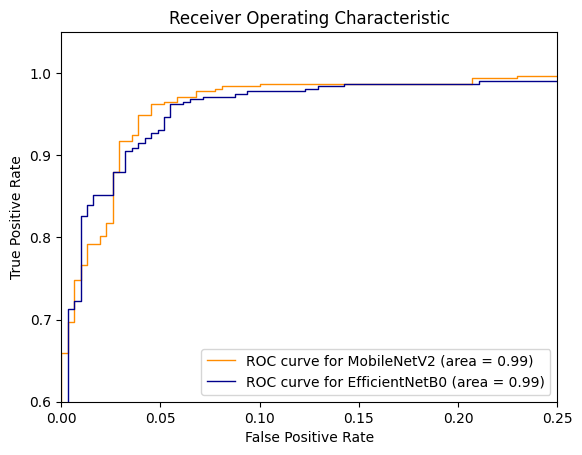

In [ ]:
fpr1, tpr1, _ = roc_curve(Mobile_y_true, Mobile_Y_pred)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(EfficientNet_y_true, EfficientNet_Y_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=1, label='ROC curve for MobileNetV2 (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='darkblue', lw=1, label='ROC curve for EfficientNetB0 (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 0.25])
plt.ylim([0.6, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Evaluate MobileNet on the test set
MobileNet_loss = MobileNet.evaluate(test_gen, verbose=1)

# Evaluate EfficientNet on the test set
EfficientNet_loss = EfficientNet.evaluate(test_gen, verbose=1)

# Print the loss values
print("MobileNet Loss on Test Set:", MobileNet_loss)
print("EfficientNet Loss on Test Set:", EfficientNet_loss)

79/79 [==============================] - 12s 100ms/step - loss: 0.1490 - accuracy: 0.9489
MobileNet Loss on Test Set: [0.13429979979991913, 0.9552715420722961]
EfficientNet Loss on Test Set: [0.14895294606685638, 0.9488818049430847]


In [ ]:
#memory usage evaluation
!pip install psutil
import psutil
import time

# Before evaluation
process = psutil.Process()
start_memory = process.memory_info().rss
start_cpu = psutil.cpu_percent()

# Evaluate MobileNet on the test set
MobileNet_loss = MobileNet.evaluate(test_gen, verbose=1)

# After evaluation
end_memory = process.memory_info().rss
end_cpu = psutil.cpu_percent()

print("Memory Used for MobileNet (bytes):", end_memory - start_memory)
print("Average CPU Usage for MobileNet (%):", (end_cpu - start_cpu) / time.process_time())

79/79 [==============================] - 8s 101ms/step - loss: 0.1343 - accuracy: 0.9553
Memory Used for MobileNet (bytes): 6438912
Average CPU Usage for MobileNet (%): 0.04394306856926556


In [ ]:
# Before evaluation
process = psutil.Process()
start_memory = process.memory_info().rss
start_cpu = psutil.cpu_percent()

# Evaluate EfficientNet on the test set
EfficientNet_loss = EfficientNet.evaluate(test_gen, verbose=1)

# After evaluation
end_memory = process.memory_info().rss
end_cpu = psutil.cpu_percent()

print("Memory Used for EfficientNet (bytes):", end_memory - start_memory)
print("Average CPU Usage for EfficientNet (%):", (end_cpu - start_cpu) / time.process_time())

79/79 [==============================] - 7s 90ms/step - loss: 0.1490 - accuracy: 0.9489
Memory Used for EfficientNet (bytes): 843776
Average CPU Usage for EfficientNet (%): 0.3404966754508679


9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/35
1644/1644 [==============================] - 484s 282ms/step - loss: 4.2185 - accuracy: 0.7901 - val_loss: 2.9631 - val_accuracy: 0.8899 - lr: 3.0000e-04
Epoch 2/35
1644/1644 [==============================] - 458s 279ms/step - loss: 1.6581 - accuracy: 0.8804 - val_loss: 1.2035 - val_accuracy: 0.9290 - lr: 3.0000e-04
Epoch 3/35
1644/1644 [==============================] - 457s 278ms/step - loss: 0.6955 - accuracy: 0.9043 - val_loss: 0.6130 - val_accuracy: 0.9338 - lr: 3.0000e-04
Epoch 4/35
1644/1644 [==============================] - 458s 279ms/step - loss: 0.4194 - accuracy: 0.9164 - val_loss: 0.3615 - val_accuracy: 0.9465 - lr: 3.0000e-04
Epoch 5/35
1644/1644 [==============================] - 457s 278ms/step - loss: 0.3491 - accuracy: 0.9162 - val_loss: 0.6551 - val_accuracy: 0.9537 - lr: 3.0000e-04
Epoch 6/35
1644/1644 [==============================] - 466s 283ms/step - loss: 0.3065 - accuracy: 0.9209 - val_

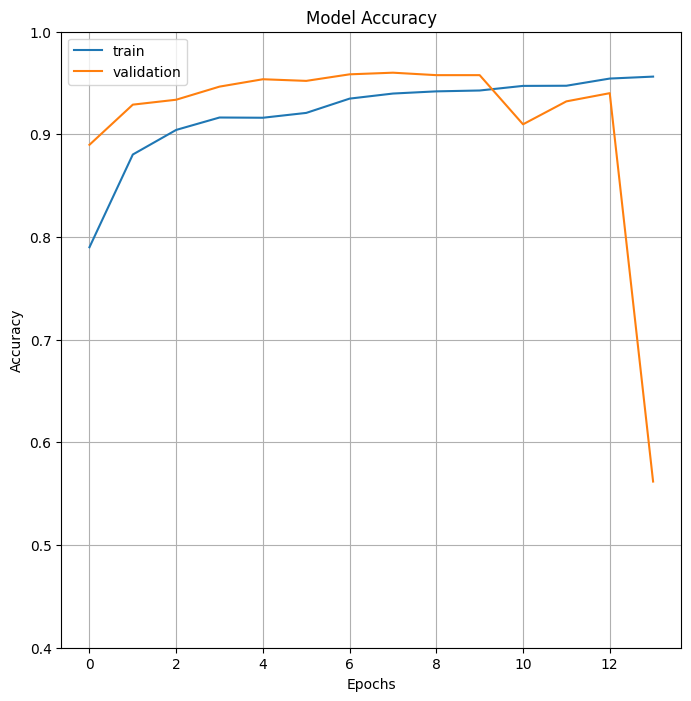

In [ ]:
#Maximum optimization of MobileNetV2
SuperMobileNet = MobileNetV2(
    input_shape=(height, width, 3),
    include_top=False,
    weights="imagenet",
)


SuperMobileNet.trainable = True

#new model using mobile
model = Sequential([
    SuperMobileNet,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate = 3e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Research - Horizon/Keras models/super_mobilenet_v1_MAX.keras',
    monitor='val_loss',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=35,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

model.save("/content/drive/MyDrive/Research - Horizon/Keras models/super_mobilenet_v1.keras")

# Plot data
plt.figure(figsize=(8, 8))
epochs_range = range(len(history.history['accuracy']))
plt.plot(epochs_range, history.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras

custom_objects = {'CustomMobileNetV2': MobileNetV2}

# Load the model with custom objects
SuperEfficientNet = keras.models.load_model(
    '/content/drive/MyDrive/Research - Horizon/Keras models/malaria_efficientnet_v2.keras',
    custom_objects=custom_objects
)

# Continue with your predictions
SuperEfficientNet_Y_pred = SuperEfficientNet.predict(test_gen, test_gen.samples // test_gen.batch_size + 1)
SuperEfficientNet_y_pred = np.round(SuperEfficientNet_Y_pred).astype(int).flatten()
SuperEfficientNet_y_true = test_gen.classes


# # Load the model
# SuperEfficientNet = keras.models.load_model('/content/drive/MyDrive/Research - Horizon/Keras models/malaria_efficientnet_v2.keras')

# # Continue with your predictions
# SuperEfficientNet_Y_pred = SuperEfficientNet.predict(test_gen, test_gen.samples // test_gen.batch_size + 1)
# SuperEfficientNet_y_pred = np.round(SuperEfficientNet_Y_pred).astype(int).flatten()
# SuperEfficientNet_y_true = test_gen.classes

KeyboardInterrupt: 

In [ ]:
cr = classification_report(SuperEfficientNet_y_true, SuperEfficientNet_y_pred, target_names=['Parasitized', 'Uninfected'])
print(cr)


              precision    recall  f1-score   support

 Parasitized       0.98      0.91      0.94       309
  Uninfected       0.92      0.98      0.95       317

    accuracy                           0.94       626
   macro avg       0.95      0.94      0.94       626
weighted avg       0.95      0.94      0.94       626



In [ ]:
#testing supermobilenet model
import tensorflow as tf
import keras

SuperMobileNet = keras.models.load_model('/content/drive/MyDrive/Research - Horizon/Keras models/super_mobilenet_v1_MAX.keras')
SuperMobileNet_Y_pred = SuperMobileNet.predict(test_gen, test_gen.samples // test_gen.batch_size + 1)
SuperMobileNet_y_pred = np.round(SuperMobileNet_Y_pred).astype(int).flatten()
SuperMobileNet_y_true = test_gen.classes

79/79 [==============================] - 5s 53ms/step


In [ ]:
cr = classification_report(SuperMobileNet_y_true, SuperMobileNet_y_pred, target_names=['Parasitized', 'Uninfected'])
print(cr)

              precision    recall  f1-score   support

 Parasitized       0.95      0.94      0.94       309
  Uninfected       0.94      0.95      0.95       317

    accuracy                           0.95       626
   macro avg       0.95      0.95      0.95       626
weighted avg       0.95      0.95      0.95       626



# Discussion section -> model mistakes and how to improve

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Assuming EfficientNetB0 and MobileNetV2 are defined somewhere
custom_objects = {'CustomEfficientNetB0': EfficientNetB0, 'CustomMobileNetV2': MobileNetV2}

# Load the models with custom objects, specifying the 'tf.keras' path
SuperEfficientNet = tf.keras.models.load_model(
    '/content/drive/MyDrive/Research - Horizon/Keras models/malaria_efficientnet_v2.keras',
    custom_objects=custom_objects
)

SuperMobileNet = tf.keras.models.load_model(
    '/content/drive/MyDrive/Research - Horizon/Keras models/super_mobilenet_v1_MAX.keras',
    custom_objects=custom_objects
)

TypeError: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential_4', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 92, 92, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'efficientnetb0_input'}, 'registered_name': None}, {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'efficientnetb0', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 92, 92, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_5'}, 'registered_name': None, 'name': 'input_5', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Rescaling', 'config': {'name': 'rescaling_8', 'trainable': True, 'dtype': 'float32', 'scale': 0.00392156862745098, 'offset': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 92, 92, 3]}, 'name': 'rescaling_8', 'inbound_nodes': [[['input_5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Normalization', 'config': {'name': 'normalization_4', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'invert': False, 'mean': None, 'variance': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 92, 92, 3]}, 'name': 'normalization_4', 'inbound_nodes': [[['rescaling_8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Rescaling', 'config': {'name': 'rescaling_9', 'trainable': True, 'dtype': 'float32', 'scale': [2.0896918976428642, 2.1128856368212916, 2.1081851067789197], 'offset': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 92, 92, 3]}, 'name': 'rescaling_9', 'inbound_nodes': [[['normalization_4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'stem_conv_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 92, 92, 3]}, 'name': 'stem_conv_pad', 'inbound_nodes': [[['rescaling_9', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'stem_conv', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 93, 93, 3]}, 'name': 'stem_conv', 'inbound_nodes': [[['stem_conv_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'stem_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'stem_bn', 'inbound_nodes': [[['stem_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'stem_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'stem_activation', 'inbound_nodes': [[['stem_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block1a_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'block1a_dwconv', 'inbound_nodes': [[['stem_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block1a_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'block1a_bn', 'inbound_nodes': [[['block1a_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block1a_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'block1a_activation', 'inbound_nodes': [[['block1a_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block1a_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'block1a_se_squeeze', 'inbound_nodes': [[['block1a_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block1a_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 32]}, 'registered_name': None, 'build_config': {'input_shape': [None, 32]}, 'name': 'block1a_se_reshape', 'inbound_nodes': [[['block1a_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1a_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 8, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 32]}, 'name': 'block1a_se_reduce', 'inbound_nodes': [[['block1a_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1a_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 8]}, 'name': 'block1a_se_expand', 'inbound_nodes': [[['block1a_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block1a_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 46, 46, 32], [None, 1, 1, 32]]}, 'name': 'block1a_se_excite', 'inbound_nodes': [[['block1a_activation', 0, 0, {}], ['block1a_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1a_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'block1a_project_conv', 'inbound_nodes': [[['block1a_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block1a_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 16]}, 'name': 'block1a_project_bn', 'inbound_nodes': [[['block1a_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2a_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 16]}, 'name': 'block2a_expand_conv', 'inbound_nodes': [[['block1a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block2a_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 96]}, 'name': 'block2a_expand_bn', 'inbound_nodes': [[['block2a_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block2a_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 96]}, 'name': 'block2a_expand_activation', 'inbound_nodes': [[['block2a_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block2a_dwconv_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 96]}, 'name': 'block2a_dwconv_pad', 'inbound_nodes': [[['block2a_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block2a_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 47, 47, 96]}, 'name': 'block2a_dwconv', 'inbound_nodes': [[['block2a_dwconv_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block2a_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block2a_bn', 'inbound_nodes': [[['block2a_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block2a_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block2a_activation', 'inbound_nodes': [[['block2a_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block2a_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block2a_se_squeeze', 'inbound_nodes': [[['block2a_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block2a_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 96]}, 'registered_name': None, 'build_config': {'input_shape': [None, 96]}, 'name': 'block2a_se_reshape', 'inbound_nodes': [[['block2a_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2a_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 4, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 96]}, 'name': 'block2a_se_reduce', 'inbound_nodes': [[['block2a_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2a_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 4]}, 'name': 'block2a_se_expand', 'inbound_nodes': [[['block2a_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block2a_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 23, 23, 96], [None, 1, 1, 96]]}, 'name': 'block2a_se_excite', 'inbound_nodes': [[['block2a_activation', 0, 0, {}], ['block2a_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2a_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 24, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block2a_project_conv', 'inbound_nodes': [[['block2a_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block2a_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block2a_project_bn', 'inbound_nodes': [[['block2a_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2b_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 144, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block2b_expand_conv', 'inbound_nodes': [[['block2a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block2b_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block2b_expand_bn', 'inbound_nodes': [[['block2b_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block2b_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block2b_expand_activation', 'inbound_nodes': [[['block2b_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block2b_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block2b_dwconv', 'inbound_nodes': [[['block2b_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block2b_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block2b_bn', 'inbound_nodes': [[['block2b_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block2b_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block2b_activation', 'inbound_nodes': [[['block2b_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block2b_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block2b_se_squeeze', 'inbound_nodes': [[['block2b_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block2b_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 144]}, 'registered_name': None, 'build_config': {'input_shape': [None, 144]}, 'name': 'block2b_se_reshape', 'inbound_nodes': [[['block2b_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2b_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 6, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 144]}, 'name': 'block2b_se_reduce', 'inbound_nodes': [[['block2b_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2b_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 144, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 6]}, 'name': 'block2b_se_expand', 'inbound_nodes': [[['block2b_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block2b_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 23, 23, 144], [None, 1, 1, 144]]}, 'name': 'block2b_se_excite', 'inbound_nodes': [[['block2b_activation', 0, 0, {}], ['block2b_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2b_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 24, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block2b_project_conv', 'inbound_nodes': [[['block2b_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block2b_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block2b_project_bn', 'inbound_nodes': [[['block2b_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'block2b_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.025, 'noise_shape': [None, 1, 1, 1], 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block2b_drop', 'inbound_nodes': [[['block2b_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block2b_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 23, 23, 24], [None, 23, 23, 24]]}, 'name': 'block2b_add', 'inbound_nodes': [[['block2b_drop', 0, 0, {}], ['block2a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3a_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 144, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block3a_expand_conv', 'inbound_nodes': [[['block2b_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block3a_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block3a_expand_bn', 'inbound_nodes': [[['block3a_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block3a_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block3a_expand_activation', 'inbound_nodes': [[['block3a_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block3a_dwconv_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[2, 2], [2, 2]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block3a_dwconv_pad', 'inbound_nodes': [[['block3a_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block3a_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 27, 27, 144]}, 'name': 'block3a_dwconv', 'inbound_nodes': [[['block3a_dwconv_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block3a_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block3a_bn', 'inbound_nodes': [[['block3a_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block3a_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block3a_activation', 'inbound_nodes': [[['block3a_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block3a_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block3a_se_squeeze', 'inbound_nodes': [[['block3a_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block3a_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 144]}, 'registered_name': None, 'build_config': {'input_shape': [None, 144]}, 'name': 'block3a_se_reshape', 'inbound_nodes': [[['block3a_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3a_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 6, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 144]}, 'name': 'block3a_se_reduce', 'inbound_nodes': [[['block3a_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3a_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 144, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 6]}, 'name': 'block3a_se_expand', 'inbound_nodes': [[['block3a_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block3a_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 144], [None, 1, 1, 144]]}, 'name': 'block3a_se_excite', 'inbound_nodes': [[['block3a_activation', 0, 0, {}], ['block3a_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3a_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 40, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block3a_project_conv', 'inbound_nodes': [[['block3a_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block3a_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 40]}, 'name': 'block3a_project_bn', 'inbound_nodes': [[['block3a_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3b_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 240, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 40]}, 'name': 'block3b_expand_conv', 'inbound_nodes': [[['block3a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block3b_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block3b_expand_bn', 'inbound_nodes': [[['block3b_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block3b_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block3b_expand_activation', 'inbound_nodes': [[['block3b_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block3b_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block3b_dwconv', 'inbound_nodes': [[['block3b_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block3b_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block3b_bn', 'inbound_nodes': [[['block3b_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block3b_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block3b_activation', 'inbound_nodes': [[['block3b_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block3b_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block3b_se_squeeze', 'inbound_nodes': [[['block3b_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block3b_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 240]}, 'registered_name': None, 'build_config': {'input_shape': [None, 240]}, 'name': 'block3b_se_reshape', 'inbound_nodes': [[['block3b_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3b_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 10, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 240]}, 'name': 'block3b_se_reduce', 'inbound_nodes': [[['block3b_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3b_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 240, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 10]}, 'name': 'block3b_se_expand', 'inbound_nodes': [[['block3b_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block3b_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 240], [None, 1, 1, 240]]}, 'name': 'block3b_se_excite', 'inbound_nodes': [[['block3b_activation', 0, 0, {}], ['block3b_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3b_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 40, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block3b_project_conv', 'inbound_nodes': [[['block3b_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block3b_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 40]}, 'name': 'block3b_project_bn', 'inbound_nodes': [[['block3b_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'block3b_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.05, 'noise_shape': [None, 1, 1, 1], 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 40]}, 'name': 'block3b_drop', 'inbound_nodes': [[['block3b_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block3b_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 40], [None, 12, 12, 40]]}, 'name': 'block3b_add', 'inbound_nodes': [[['block3b_drop', 0, 0, {}], ['block3a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4a_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 240, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 40]}, 'name': 'block4a_expand_conv', 'inbound_nodes': [[['block3b_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4a_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block4a_expand_bn', 'inbound_nodes': [[['block4a_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block4a_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block4a_expand_activation', 'inbound_nodes': [[['block4a_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block4a_dwconv_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block4a_dwconv_pad', 'inbound_nodes': [[['block4a_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block4a_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 13, 13, 240]}, 'name': 'block4a_dwconv', 'inbound_nodes': [[['block4a_dwconv_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4a_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 240]}, 'name': 'block4a_bn', 'inbound_nodes': [[['block4a_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block4a_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 240]}, 'name': 'block4a_activation', 'inbound_nodes': [[['block4a_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block4a_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 240]}, 'name': 'block4a_se_squeeze', 'inbound_nodes': [[['block4a_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block4a_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 240]}, 'registered_name': None, 'build_config': {'input_shape': [None, 240]}, 'name': 'block4a_se_reshape', 'inbound_nodes': [[['block4a_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4a_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 10, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 240]}, 'name': 'block4a_se_reduce', 'inbound_nodes': [[['block4a_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4a_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 240, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 10]}, 'name': 'block4a_se_expand', 'inbound_nodes': [[['block4a_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block4a_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 240], [None, 1, 1, 240]]}, 'name': 'block4a_se_excite', 'inbound_nodes': [[['block4a_activation', 0, 0, {}], ['block4a_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4a_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 80, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 240]}, 'name': 'block4a_project_conv', 'inbound_nodes': [[['block4a_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4a_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 80]}, 'name': 'block4a_project_bn', 'inbound_nodes': [[['block4a_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4b_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 480, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 80]}, 'name': 'block4b_expand_conv', 'inbound_nodes': [[['block4a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4b_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4b_expand_bn', 'inbound_nodes': [[['block4b_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block4b_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4b_expand_activation', 'inbound_nodes': [[['block4b_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block4b_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4b_dwconv', 'inbound_nodes': [[['block4b_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4b_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4b_bn', 'inbound_nodes': [[['block4b_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block4b_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4b_activation', 'inbound_nodes': [[['block4b_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block4b_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4b_se_squeeze', 'inbound_nodes': [[['block4b_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block4b_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 480]}, 'registered_name': None, 'build_config': {'input_shape': [None, 480]}, 'name': 'block4b_se_reshape', 'inbound_nodes': [[['block4b_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4b_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 20, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 480]}, 'name': 'block4b_se_reduce', 'inbound_nodes': [[['block4b_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4b_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 480, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 20]}, 'name': 'block4b_se_expand', 'inbound_nodes': [[['block4b_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block4b_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 480], [None, 1, 1, 480]]}, 'name': 'block4b_se_excite', 'inbound_nodes': [[['block4b_activation', 0, 0, {}], ['block4b_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4b_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 80, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4b_project_conv', 'inbound_nodes': [[['block4b_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4b_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 80]}, 'name': 'block4b_project_bn', 'inbound_nodes': [[['block4b_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'block4b_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.07500000000000001, 'noise_shape': [None, 1, 1, 1], 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 80]}, 'name': 'block4b_drop', 'inbound_nodes': [[['block4b_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block4b_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 80], [None, 6, 6, 80]]}, 'name': 'block4b_add', 'inbound_nodes': [[['block4b_drop', 0, 0, {}], ['block4a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4c_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 480, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 80]}, 'name': 'block4c_expand_conv', 'inbound_nodes': [[['block4b_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4c_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4c_expand_bn', 'inbound_nodes': [[['block4c_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block4c_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4c_expand_activation', 'inbound_nodes': [[['block4c_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block4c_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4c_dwconv', 'inbound_nodes': [[['block4c_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4c_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4c_bn', 'inbound_nodes': [[['block4c_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block4c_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4c_activation', 'inbound_nodes': [[['block4c_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block4c_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4c_se_squeeze', 'inbound_nodes': [[['block4c_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block4c_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 480]}, 'registered_name': None, 'build_config': {'input_shape': [None, 480]}, 'name': 'block4c_se_reshape', 'inbound_nodes': [[['block4c_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4c_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 20, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 480]}, 'name': 'block4c_se_reduce', 'inbound_nodes': [[['block4c_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4c_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 480, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 20]}, 'name': 'block4c_se_expand', 'inbound_nodes': [[['block4c_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block4c_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 480], [None, 1, 1, 480]]}, 'name': 'block4c_se_excite', 'inbound_nodes': [[['block4c_activation', 0, 0, {}], ['block4c_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4c_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 80, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4c_project_conv', 'inbound_nodes': [[['block4c_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4c_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 80]}, 'name': 'block4c_project_bn', 'inbound_nodes': [[['block4c_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'block4c_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.08750000000000001, 'noise_shape': [None, 1, 1, 1], 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 80]}, 'name': 'block4c_drop', 'inbound_nodes': [[['block4c_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block4c_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 80], [None, 6, 6, 80]]}, 'name': 'block4c_add', 'inbound_nodes': [[['block4c_drop', 0, 0, {}], ['block4b_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5a_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 480, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 80]}, 'name': 'block5a_expand_conv', 'inbound_nodes': [[['block4c_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5a_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block5a_expand_bn', 'inbound_nodes': [[['block5a_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block5a_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block5a_expand_activation', 'inbound_nodes': [[['block5a_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block5a_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block5a_dwconv', 'inbound_nodes': [[['block5a_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5a_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block5a_bn', 'inbound_nodes': [[['block5a_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block5a_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block5a_activation', 'inbound_nodes': [[['block5a_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block5a_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block5a_se_squeeze', 'inbound_nodes': [[['block5a_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block5a_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 480]}, 'registered_name': None, 'build_config': {'input_shape': [None, 480]}, 'name': 'block5a_se_reshape', 'inbound_nodes': [[['block5a_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5a_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 20, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 480]}, 'name': 'block5a_se_reduce', 'inbound_nodes': [[['block5a_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5a_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 480, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 20]}, 'name': 'block5a_se_expand', 'inbound_nodes': [[['block5a_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block5a_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 480], [None, 1, 1, 480]]}, 'name': 'block5a_se_excite', 'inbound_nodes': [[['block5a_activation', 0, 0, {}], ['block5a_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5a_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 112, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block5a_project_conv', 'inbound_nodes': [[['block5a_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5a_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 112]}, 'name': 'block5a_project_bn', 'inbound_nodes': [[['block5a_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5b_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 112]}, 'name': 'block5b_expand_conv', 'inbound_nodes': [[['block5a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5b_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5b_expand_bn', 'inbound_nodes': [[['block5b_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block5b_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5b_expand_activation', 'inbound_nodes': [[['block5b_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block5b_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5b_dwconv', 'inbound_nodes': [[['block5b_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5b_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5b_bn', 'inbound_nodes': [[['block5b_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block5b_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5b_activation', 'inbound_nodes': [[['block5b_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block5b_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5b_se_squeeze', 'inbound_nodes': [[['block5b_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block5b_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 672]}, 'registered_name': None, 'build_config': {'input_shape': [None, 672]}, 'name': 'block5b_se_reshape', 'inbound_nodes': [[['block5b_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5b_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 28, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 672]}, 'name': 'block5b_se_reduce', 'inbound_nodes': [[['block5b_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5b_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 28]}, 'name': 'block5b_se_expand', 'inbound_nodes': [[['block5b_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block5b_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 672], [None, 1, 1, 672]]}, 'name': 'block5b_se_excite', 'inbound_nodes': [[['block5b_activation', 0, 0, {}], ['block5b_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5b_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 112, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5b_project_conv', 'inbound_nodes': [[['block5b_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5b_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 112]}, 'name': 'block5b_project_bn', 'inbound_nodes': [[['block5b_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'block5b_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.1125, 'noise_shape': [None, 1, 1, 1], 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 112]}, 'name': 'block5b_drop', 'inbound_nodes': [[['block5b_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block5b_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 112], [None, 6, 6, 112]]}, 'name': 'block5b_add', 'inbound_nodes': [[['block5b_drop', 0, 0, {}], ['block5a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5c_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 112]}, 'name': 'block5c_expand_conv', 'inbound_nodes': [[['block5b_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5c_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5c_expand_bn', 'inbound_nodes': [[['block5c_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block5c_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5c_expand_activation', 'inbound_nodes': [[['block5c_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block5c_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5c_dwconv', 'inbound_nodes': [[['block5c_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5c_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5c_bn', 'inbound_nodes': [[['block5c_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block5c_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5c_activation', 'inbound_nodes': [[['block5c_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block5c_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5c_se_squeeze', 'inbound_nodes': [[['block5c_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block5c_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 672]}, 'registered_name': None, 'build_config': {'input_shape': [None, 672]}, 'name': 'block5c_se_reshape', 'inbound_nodes': [[['block5c_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5c_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 28, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 672]}, 'name': 'block5c_se_reduce', 'inbound_nodes': [[['block5c_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5c_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 28]}, 'name': 'block5c_se_expand', 'inbound_nodes': [[['block5c_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block5c_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 672], [None, 1, 1, 672]]}, 'name': 'block5c_se_excite', 'inbound_nodes': [[['block5c_activation', 0, 0, {}], ['block5c_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5c_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 112, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5c_project_conv', 'inbound_nodes': [[['block5c_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5c_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 112]}, 'name': 'block5c_project_bn', 'inbound_nodes': [[['block5c_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'block5c_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.125, 'noise_shape': [None, 1, 1, 1], 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 112]}, 'name': 'block5c_drop', 'inbound_nodes': [[['block5c_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block5c_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 112], [None, 6, 6, 112]]}, 'name': 'block5c_add', 'inbound_nodes': [[['block5c_drop', 0, 0, {}], ['block5b_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6a_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 112]}, 'name': 'block6a_expand_conv', 'inbound_nodes': [[['block5c_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6a_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block6a_expand_bn', 'inbound_nodes': [[['block6a_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6a_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block6a_expand_activation', 'inbound_nodes': [[['block6a_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block6a_dwconv_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 2], [1, 2]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block6a_dwconv_pad', 'inbound_nodes': [[['block6a_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block6a_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 9, 9, 672]}, 'name': 'block6a_dwconv', 'inbound_nodes': [[['block6a_dwconv_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6a_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 672]}, 'name': 'block6a_bn', 'inbound_nodes': [[['block6a_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6a_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 672]}, 'name': 'block6a_activation', 'inbound_nodes': [[['block6a_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block6a_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 672]}, 'name': 'block6a_se_squeeze', 'inbound_nodes': [[['block6a_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block6a_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 672]}, 'registered_name': None, 'build_config': {'input_shape': [None, 672]}, 'name': 'block6a_se_reshape', 'inbound_nodes': [[['block6a_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6a_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 28, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 672]}, 'name': 'block6a_se_reduce', 'inbound_nodes': [[['block6a_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6a_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 28]}, 'name': 'block6a_se_expand', 'inbound_nodes': [[['block6a_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block6a_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 672], [None, 1, 1, 672]]}, 'name': 'block6a_se_excite', 'inbound_nodes': [[['block6a_activation', 0, 0, {}], ['block6a_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6a_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 672]}, 'name': 'block6a_project_conv', 'inbound_nodes': [[['block6a_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6a_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6a_project_bn', 'inbound_nodes': [[['block6a_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6b_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1152, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6b_expand_conv', 'inbound_nodes': [[['block6a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6b_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6b_expand_bn', 'inbound_nodes': [[['block6b_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6b_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6b_expand_activation', 'inbound_nodes': [[['block6b_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block6b_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6b_dwconv', 'inbound_nodes': [[['block6b_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6b_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6b_bn', 'inbound_nodes': [[['block6b_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6b_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6b_activation', 'inbound_nodes': [[['block6b_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block6b_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6b_se_squeeze', 'inbound_nodes': [[['block6b_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block6b_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 1152]}, 'registered_name': None, 'build_config': {'input_shape': [None, 1152]}, 'name': 'block6b_se_reshape', 'inbound_nodes': [[['block6b_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6b_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 48, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 1152]}, 'name': 'block6b_se_reduce', 'inbound_nodes': [[['block6b_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6b_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 1152, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 48]}, 'name': 'block6b_se_expand', 'inbound_nodes': [[['block6b_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block6b_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 1152], [None, 1, 1, 1152]]}, 'name': 'block6b_se_excite', 'inbound_nodes': [[['block6b_activation', 0, 0, {}], ['block6b_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6b_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6b_project_conv', 'inbound_nodes': [[['block6b_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6b_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6b_project_bn', 'inbound_nodes': [[['block6b_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'block6b_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.15000000000000002, 'noise_shape': [None, 1, 1, 1], 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6b_drop', 'inbound_nodes': [[['block6b_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block6b_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 192], [None, 3, 3, 192]]}, 'name': 'block6b_add', 'inbound_nodes': [[['block6b_drop', 0, 0, {}], ['block6a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6c_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1152, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6c_expand_conv', 'inbound_nodes': [[['block6b_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6c_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6c_expand_bn', 'inbound_nodes': [[['block6c_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6c_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6c_expand_activation', 'inbound_nodes': [[['block6c_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block6c_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6c_dwconv', 'inbound_nodes': [[['block6c_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6c_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6c_bn', 'inbound_nodes': [[['block6c_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6c_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6c_activation', 'inbound_nodes': [[['block6c_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block6c_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6c_se_squeeze', 'inbound_nodes': [[['block6c_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block6c_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 1152]}, 'registered_name': None, 'build_config': {'input_shape': [None, 1152]}, 'name': 'block6c_se_reshape', 'inbound_nodes': [[['block6c_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6c_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 48, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 1152]}, 'name': 'block6c_se_reduce', 'inbound_nodes': [[['block6c_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6c_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 1152, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 48]}, 'name': 'block6c_se_expand', 'inbound_nodes': [[['block6c_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block6c_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 1152], [None, 1, 1, 1152]]}, 'name': 'block6c_se_excite', 'inbound_nodes': [[['block6c_activation', 0, 0, {}], ['block6c_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6c_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6c_project_conv', 'inbound_nodes': [[['block6c_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6c_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6c_project_bn', 'inbound_nodes': [[['block6c_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'block6c_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.1625, 'noise_shape': [None, 1, 1, 1], 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6c_drop', 'inbound_nodes': [[['block6c_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block6c_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 192], [None, 3, 3, 192]]}, 'name': 'block6c_add', 'inbound_nodes': [[['block6c_drop', 0, 0, {}], ['block6b_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6d_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1152, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6d_expand_conv', 'inbound_nodes': [[['block6c_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6d_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6d_expand_bn', 'inbound_nodes': [[['block6d_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6d_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6d_expand_activation', 'inbound_nodes': [[['block6d_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block6d_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6d_dwconv', 'inbound_nodes': [[['block6d_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6d_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6d_bn', 'inbound_nodes': [[['block6d_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6d_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6d_activation', 'inbound_nodes': [[['block6d_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block6d_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6d_se_squeeze', 'inbound_nodes': [[['block6d_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block6d_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 1152]}, 'registered_name': None, 'build_config': {'input_shape': [None, 1152]}, 'name': 'block6d_se_reshape', 'inbound_nodes': [[['block6d_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6d_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 48, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 1152]}, 'name': 'block6d_se_reduce', 'inbound_nodes': [[['block6d_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6d_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 1152, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 48]}, 'name': 'block6d_se_expand', 'inbound_nodes': [[['block6d_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block6d_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 1152], [None, 1, 1, 1152]]}, 'name': 'block6d_se_excite', 'inbound_nodes': [[['block6d_activation', 0, 0, {}], ['block6d_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6d_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6d_project_conv', 'inbound_nodes': [[['block6d_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6d_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6d_project_bn', 'inbound_nodes': [[['block6d_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'block6d_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.17500000000000002, 'noise_shape': [None, 1, 1, 1], 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6d_drop', 'inbound_nodes': [[['block6d_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block6d_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 192], [None, 3, 3, 192]]}, 'name': 'block6d_add', 'inbound_nodes': [[['block6d_drop', 0, 0, {}], ['block6c_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block7a_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1152, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block7a_expand_conv', 'inbound_nodes': [[['block6d_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block7a_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block7a_expand_bn', 'inbound_nodes': [[['block7a_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block7a_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block7a_expand_activation', 'inbound_nodes': [[['block7a_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block7a_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block7a_dwconv', 'inbound_nodes': [[['block7a_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block7a_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block7a_bn', 'inbound_nodes': [[['block7a_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block7a_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block7a_activation', 'inbound_nodes': [[['block7a_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block7a_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block7a_se_squeeze', 'inbound_nodes': [[['block7a_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block7a_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 1152]}, 'registered_name': None, 'build_config': {'input_shape': [None, 1152]}, 'name': 'block7a_se_reshape', 'inbound_nodes': [[['block7a_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block7a_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 48, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 1152]}, 'name': 'block7a_se_reduce', 'inbound_nodes': [[['block7a_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block7a_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 1152, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 48]}, 'name': 'block7a_se_expand', 'inbound_nodes': [[['block7a_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block7a_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 1152], [None, 1, 1, 1152]]}, 'name': 'block7a_se_excite', 'inbound_nodes': [[['block7a_activation', 0, 0, {}], ['block7a_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block7a_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 320, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block7a_project_conv', 'inbound_nodes': [[['block7a_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block7a_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 320]}, 'name': 'block7a_project_bn', 'inbound_nodes': [[['block7a_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'top_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1280, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 320]}, 'name': 'top_conv', 'inbound_nodes': [[['block7a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'top_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1280]}, 'name': 'top_bn', 'inbound_nodes': [[['top_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'top_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1280]}, 'name': 'top_activation', 'inbound_nodes': [[['top_bn', 0, 0, {}]]]}], 'input_layers': [['input_5', 0, 0]], 'output_layers': [['top_activation', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, 92, 92, 3]}}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten_4', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1280]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_8', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 11520]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_4', 'trainable': True, 'dtype': 'float32', 'axis': [1], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_9', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128]}}]}, 'registered_name': None, 'build_config': {'input_shape': [None, 92, 92, 3]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.0003000000142492354, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'binary_crossentropy', 'metrics': ['accuracy'], 'loss_weights': None, 'weighted_metrics': None, 'run_eagerly': None, 'steps_per_execution': None, 'jit_compile': None}}.

Exception encountered: Could not deserialize class 'Functional' because its parent module keras.src.engine.functional cannot be imported. Full object config: {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'efficientnetb0', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 92, 92, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_5'}, 'registered_name': None, 'name': 'input_5', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Rescaling', 'config': {'name': 'rescaling_8', 'trainable': True, 'dtype': 'float32', 'scale': 0.00392156862745098, 'offset': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 92, 92, 3]}, 'name': 'rescaling_8', 'inbound_nodes': [[['input_5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Normalization', 'config': {'name': 'normalization_4', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'invert': False, 'mean': None, 'variance': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 92, 92, 3]}, 'name': 'normalization_4', 'inbound_nodes': [[['rescaling_8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Rescaling', 'config': {'name': 'rescaling_9', 'trainable': True, 'dtype': 'float32', 'scale': [2.0896918976428642, 2.1128856368212916, 2.1081851067789197], 'offset': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 92, 92, 3]}, 'name': 'rescaling_9', 'inbound_nodes': [[['normalization_4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'stem_conv_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 92, 92, 3]}, 'name': 'stem_conv_pad', 'inbound_nodes': [[['rescaling_9', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'stem_conv', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 93, 93, 3]}, 'name': 'stem_conv', 'inbound_nodes': [[['stem_conv_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'stem_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'stem_bn', 'inbound_nodes': [[['stem_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'stem_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'stem_activation', 'inbound_nodes': [[['stem_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block1a_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'block1a_dwconv', 'inbound_nodes': [[['stem_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block1a_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'block1a_bn', 'inbound_nodes': [[['block1a_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block1a_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'block1a_activation', 'inbound_nodes': [[['block1a_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block1a_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'block1a_se_squeeze', 'inbound_nodes': [[['block1a_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block1a_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 32]}, 'registered_name': None, 'build_config': {'input_shape': [None, 32]}, 'name': 'block1a_se_reshape', 'inbound_nodes': [[['block1a_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1a_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 8, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 32]}, 'name': 'block1a_se_reduce', 'inbound_nodes': [[['block1a_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1a_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 8]}, 'name': 'block1a_se_expand', 'inbound_nodes': [[['block1a_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block1a_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 46, 46, 32], [None, 1, 1, 32]]}, 'name': 'block1a_se_excite', 'inbound_nodes': [[['block1a_activation', 0, 0, {}], ['block1a_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1a_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'block1a_project_conv', 'inbound_nodes': [[['block1a_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block1a_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 16]}, 'name': 'block1a_project_bn', 'inbound_nodes': [[['block1a_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2a_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 16]}, 'name': 'block2a_expand_conv', 'inbound_nodes': [[['block1a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block2a_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 96]}, 'name': 'block2a_expand_bn', 'inbound_nodes': [[['block2a_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block2a_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 96]}, 'name': 'block2a_expand_activation', 'inbound_nodes': [[['block2a_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block2a_dwconv_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 96]}, 'name': 'block2a_dwconv_pad', 'inbound_nodes': [[['block2a_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block2a_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 47, 47, 96]}, 'name': 'block2a_dwconv', 'inbound_nodes': [[['block2a_dwconv_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block2a_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block2a_bn', 'inbound_nodes': [[['block2a_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block2a_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block2a_activation', 'inbound_nodes': [[['block2a_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block2a_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block2a_se_squeeze', 'inbound_nodes': [[['block2a_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block2a_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 96]}, 'registered_name': None, 'build_config': {'input_shape': [None, 96]}, 'name': 'block2a_se_reshape', 'inbound_nodes': [[['block2a_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2a_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 4, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 96]}, 'name': 'block2a_se_reduce', 'inbound_nodes': [[['block2a_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2a_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 4]}, 'name': 'block2a_se_expand', 'inbound_nodes': [[['block2a_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block2a_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 23, 23, 96], [None, 1, 1, 96]]}, 'name': 'block2a_se_excite', 'inbound_nodes': [[['block2a_activation', 0, 0, {}], ['block2a_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2a_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 24, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block2a_project_conv', 'inbound_nodes': [[['block2a_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block2a_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block2a_project_bn', 'inbound_nodes': [[['block2a_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2b_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 144, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block2b_expand_conv', 'inbound_nodes': [[['block2a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block2b_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block2b_expand_bn', 'inbound_nodes': [[['block2b_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block2b_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block2b_expand_activation', 'inbound_nodes': [[['block2b_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block2b_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block2b_dwconv', 'inbound_nodes': [[['block2b_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block2b_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block2b_bn', 'inbound_nodes': [[['block2b_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block2b_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block2b_activation', 'inbound_nodes': [[['block2b_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block2b_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block2b_se_squeeze', 'inbound_nodes': [[['block2b_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block2b_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 144]}, 'registered_name': None, 'build_config': {'input_shape': [None, 144]}, 'name': 'block2b_se_reshape', 'inbound_nodes': [[['block2b_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2b_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 6, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 144]}, 'name': 'block2b_se_reduce', 'inbound_nodes': [[['block2b_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2b_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 144, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 6]}, 'name': 'block2b_se_expand', 'inbound_nodes': [[['block2b_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block2b_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 23, 23, 144], [None, 1, 1, 144]]}, 'name': 'block2b_se_excite', 'inbound_nodes': [[['block2b_activation', 0, 0, {}], ['block2b_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2b_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 24, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block2b_project_conv', 'inbound_nodes': [[['block2b_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block2b_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block2b_project_bn', 'inbound_nodes': [[['block2b_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'block2b_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.025, 'noise_shape': [None, 1, 1, 1], 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block2b_drop', 'inbound_nodes': [[['block2b_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block2b_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 23, 23, 24], [None, 23, 23, 24]]}, 'name': 'block2b_add', 'inbound_nodes': [[['block2b_drop', 0, 0, {}], ['block2a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3a_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 144, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block3a_expand_conv', 'inbound_nodes': [[['block2b_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block3a_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block3a_expand_bn', 'inbound_nodes': [[['block3a_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block3a_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block3a_expand_activation', 'inbound_nodes': [[['block3a_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block3a_dwconv_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[2, 2], [2, 2]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block3a_dwconv_pad', 'inbound_nodes': [[['block3a_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block3a_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 27, 27, 144]}, 'name': 'block3a_dwconv', 'inbound_nodes': [[['block3a_dwconv_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block3a_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block3a_bn', 'inbound_nodes': [[['block3a_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block3a_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block3a_activation', 'inbound_nodes': [[['block3a_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block3a_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block3a_se_squeeze', 'inbound_nodes': [[['block3a_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block3a_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 144]}, 'registered_name': None, 'build_config': {'input_shape': [None, 144]}, 'name': 'block3a_se_reshape', 'inbound_nodes': [[['block3a_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3a_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 6, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 144]}, 'name': 'block3a_se_reduce', 'inbound_nodes': [[['block3a_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3a_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 144, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 6]}, 'name': 'block3a_se_expand', 'inbound_nodes': [[['block3a_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block3a_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 144], [None, 1, 1, 144]]}, 'name': 'block3a_se_excite', 'inbound_nodes': [[['block3a_activation', 0, 0, {}], ['block3a_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3a_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 40, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block3a_project_conv', 'inbound_nodes': [[['block3a_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block3a_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 40]}, 'name': 'block3a_project_bn', 'inbound_nodes': [[['block3a_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3b_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 240, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 40]}, 'name': 'block3b_expand_conv', 'inbound_nodes': [[['block3a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block3b_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block3b_expand_bn', 'inbound_nodes': [[['block3b_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block3b_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block3b_expand_activation', 'inbound_nodes': [[['block3b_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block3b_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block3b_dwconv', 'inbound_nodes': [[['block3b_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block3b_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block3b_bn', 'inbound_nodes': [[['block3b_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block3b_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block3b_activation', 'inbound_nodes': [[['block3b_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block3b_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block3b_se_squeeze', 'inbound_nodes': [[['block3b_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block3b_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 240]}, 'registered_name': None, 'build_config': {'input_shape': [None, 240]}, 'name': 'block3b_se_reshape', 'inbound_nodes': [[['block3b_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3b_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 10, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 240]}, 'name': 'block3b_se_reduce', 'inbound_nodes': [[['block3b_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3b_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 240, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 10]}, 'name': 'block3b_se_expand', 'inbound_nodes': [[['block3b_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block3b_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 240], [None, 1, 1, 240]]}, 'name': 'block3b_se_excite', 'inbound_nodes': [[['block3b_activation', 0, 0, {}], ['block3b_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3b_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 40, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block3b_project_conv', 'inbound_nodes': [[['block3b_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block3b_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 40]}, 'name': 'block3b_project_bn', 'inbound_nodes': [[['block3b_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'block3b_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.05, 'noise_shape': [None, 1, 1, 1], 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 40]}, 'name': 'block3b_drop', 'inbound_nodes': [[['block3b_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block3b_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 40], [None, 12, 12, 40]]}, 'name': 'block3b_add', 'inbound_nodes': [[['block3b_drop', 0, 0, {}], ['block3a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4a_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 240, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 40]}, 'name': 'block4a_expand_conv', 'inbound_nodes': [[['block3b_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4a_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block4a_expand_bn', 'inbound_nodes': [[['block4a_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block4a_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block4a_expand_activation', 'inbound_nodes': [[['block4a_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block4a_dwconv_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 240]}, 'name': 'block4a_dwconv_pad', 'inbound_nodes': [[['block4a_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block4a_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 13, 13, 240]}, 'name': 'block4a_dwconv', 'inbound_nodes': [[['block4a_dwconv_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4a_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 240]}, 'name': 'block4a_bn', 'inbound_nodes': [[['block4a_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block4a_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 240]}, 'name': 'block4a_activation', 'inbound_nodes': [[['block4a_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block4a_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 240]}, 'name': 'block4a_se_squeeze', 'inbound_nodes': [[['block4a_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block4a_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 240]}, 'registered_name': None, 'build_config': {'input_shape': [None, 240]}, 'name': 'block4a_se_reshape', 'inbound_nodes': [[['block4a_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4a_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 10, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 240]}, 'name': 'block4a_se_reduce', 'inbound_nodes': [[['block4a_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4a_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 240, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 10]}, 'name': 'block4a_se_expand', 'inbound_nodes': [[['block4a_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block4a_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 240], [None, 1, 1, 240]]}, 'name': 'block4a_se_excite', 'inbound_nodes': [[['block4a_activation', 0, 0, {}], ['block4a_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4a_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 80, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 240]}, 'name': 'block4a_project_conv', 'inbound_nodes': [[['block4a_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4a_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 80]}, 'name': 'block4a_project_bn', 'inbound_nodes': [[['block4a_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4b_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 480, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 80]}, 'name': 'block4b_expand_conv', 'inbound_nodes': [[['block4a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4b_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4b_expand_bn', 'inbound_nodes': [[['block4b_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block4b_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4b_expand_activation', 'inbound_nodes': [[['block4b_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block4b_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4b_dwconv', 'inbound_nodes': [[['block4b_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4b_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4b_bn', 'inbound_nodes': [[['block4b_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block4b_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4b_activation', 'inbound_nodes': [[['block4b_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block4b_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4b_se_squeeze', 'inbound_nodes': [[['block4b_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block4b_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 480]}, 'registered_name': None, 'build_config': {'input_shape': [None, 480]}, 'name': 'block4b_se_reshape', 'inbound_nodes': [[['block4b_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4b_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 20, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 480]}, 'name': 'block4b_se_reduce', 'inbound_nodes': [[['block4b_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4b_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 480, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 20]}, 'name': 'block4b_se_expand', 'inbound_nodes': [[['block4b_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block4b_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 480], [None, 1, 1, 480]]}, 'name': 'block4b_se_excite', 'inbound_nodes': [[['block4b_activation', 0, 0, {}], ['block4b_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4b_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 80, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4b_project_conv', 'inbound_nodes': [[['block4b_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4b_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 80]}, 'name': 'block4b_project_bn', 'inbound_nodes': [[['block4b_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'block4b_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.07500000000000001, 'noise_shape': [None, 1, 1, 1], 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 80]}, 'name': 'block4b_drop', 'inbound_nodes': [[['block4b_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block4b_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 80], [None, 6, 6, 80]]}, 'name': 'block4b_add', 'inbound_nodes': [[['block4b_drop', 0, 0, {}], ['block4a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4c_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 480, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 80]}, 'name': 'block4c_expand_conv', 'inbound_nodes': [[['block4b_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4c_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4c_expand_bn', 'inbound_nodes': [[['block4c_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block4c_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4c_expand_activation', 'inbound_nodes': [[['block4c_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block4c_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4c_dwconv', 'inbound_nodes': [[['block4c_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4c_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4c_bn', 'inbound_nodes': [[['block4c_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block4c_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4c_activation', 'inbound_nodes': [[['block4c_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block4c_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4c_se_squeeze', 'inbound_nodes': [[['block4c_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block4c_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 480]}, 'registered_name': None, 'build_config': {'input_shape': [None, 480]}, 'name': 'block4c_se_reshape', 'inbound_nodes': [[['block4c_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4c_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 20, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 480]}, 'name': 'block4c_se_reduce', 'inbound_nodes': [[['block4c_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4c_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 480, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 20]}, 'name': 'block4c_se_expand', 'inbound_nodes': [[['block4c_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block4c_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 480], [None, 1, 1, 480]]}, 'name': 'block4c_se_excite', 'inbound_nodes': [[['block4c_activation', 0, 0, {}], ['block4c_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4c_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 80, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block4c_project_conv', 'inbound_nodes': [[['block4c_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4c_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 80]}, 'name': 'block4c_project_bn', 'inbound_nodes': [[['block4c_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'block4c_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.08750000000000001, 'noise_shape': [None, 1, 1, 1], 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 80]}, 'name': 'block4c_drop', 'inbound_nodes': [[['block4c_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block4c_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 80], [None, 6, 6, 80]]}, 'name': 'block4c_add', 'inbound_nodes': [[['block4c_drop', 0, 0, {}], ['block4b_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5a_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 480, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 80]}, 'name': 'block5a_expand_conv', 'inbound_nodes': [[['block4c_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5a_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block5a_expand_bn', 'inbound_nodes': [[['block5a_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block5a_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block5a_expand_activation', 'inbound_nodes': [[['block5a_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block5a_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block5a_dwconv', 'inbound_nodes': [[['block5a_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5a_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block5a_bn', 'inbound_nodes': [[['block5a_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block5a_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block5a_activation', 'inbound_nodes': [[['block5a_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block5a_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block5a_se_squeeze', 'inbound_nodes': [[['block5a_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block5a_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 480]}, 'registered_name': None, 'build_config': {'input_shape': [None, 480]}, 'name': 'block5a_se_reshape', 'inbound_nodes': [[['block5a_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5a_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 20, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 480]}, 'name': 'block5a_se_reduce', 'inbound_nodes': [[['block5a_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5a_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 480, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 20]}, 'name': 'block5a_se_expand', 'inbound_nodes': [[['block5a_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block5a_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 480], [None, 1, 1, 480]]}, 'name': 'block5a_se_excite', 'inbound_nodes': [[['block5a_activation', 0, 0, {}], ['block5a_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5a_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 112, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 480]}, 'name': 'block5a_project_conv', 'inbound_nodes': [[['block5a_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5a_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 112]}, 'name': 'block5a_project_bn', 'inbound_nodes': [[['block5a_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5b_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 112]}, 'name': 'block5b_expand_conv', 'inbound_nodes': [[['block5a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5b_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5b_expand_bn', 'inbound_nodes': [[['block5b_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block5b_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5b_expand_activation', 'inbound_nodes': [[['block5b_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block5b_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5b_dwconv', 'inbound_nodes': [[['block5b_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5b_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5b_bn', 'inbound_nodes': [[['block5b_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block5b_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5b_activation', 'inbound_nodes': [[['block5b_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block5b_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5b_se_squeeze', 'inbound_nodes': [[['block5b_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block5b_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 672]}, 'registered_name': None, 'build_config': {'input_shape': [None, 672]}, 'name': 'block5b_se_reshape', 'inbound_nodes': [[['block5b_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5b_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 28, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 672]}, 'name': 'block5b_se_reduce', 'inbound_nodes': [[['block5b_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5b_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 28]}, 'name': 'block5b_se_expand', 'inbound_nodes': [[['block5b_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block5b_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 672], [None, 1, 1, 672]]}, 'name': 'block5b_se_excite', 'inbound_nodes': [[['block5b_activation', 0, 0, {}], ['block5b_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5b_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 112, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5b_project_conv', 'inbound_nodes': [[['block5b_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5b_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 112]}, 'name': 'block5b_project_bn', 'inbound_nodes': [[['block5b_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'block5b_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.1125, 'noise_shape': [None, 1, 1, 1], 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 112]}, 'name': 'block5b_drop', 'inbound_nodes': [[['block5b_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block5b_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 112], [None, 6, 6, 112]]}, 'name': 'block5b_add', 'inbound_nodes': [[['block5b_drop', 0, 0, {}], ['block5a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5c_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 112]}, 'name': 'block5c_expand_conv', 'inbound_nodes': [[['block5b_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5c_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5c_expand_bn', 'inbound_nodes': [[['block5c_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block5c_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5c_expand_activation', 'inbound_nodes': [[['block5c_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block5c_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5c_dwconv', 'inbound_nodes': [[['block5c_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5c_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5c_bn', 'inbound_nodes': [[['block5c_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block5c_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5c_activation', 'inbound_nodes': [[['block5c_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block5c_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5c_se_squeeze', 'inbound_nodes': [[['block5c_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block5c_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 672]}, 'registered_name': None, 'build_config': {'input_shape': [None, 672]}, 'name': 'block5c_se_reshape', 'inbound_nodes': [[['block5c_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5c_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 28, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 672]}, 'name': 'block5c_se_reduce', 'inbound_nodes': [[['block5c_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5c_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 28]}, 'name': 'block5c_se_expand', 'inbound_nodes': [[['block5c_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block5c_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 672], [None, 1, 1, 672]]}, 'name': 'block5c_se_excite', 'inbound_nodes': [[['block5c_activation', 0, 0, {}], ['block5c_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5c_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 112, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block5c_project_conv', 'inbound_nodes': [[['block5c_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5c_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 112]}, 'name': 'block5c_project_bn', 'inbound_nodes': [[['block5c_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'block5c_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.125, 'noise_shape': [None, 1, 1, 1], 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 112]}, 'name': 'block5c_drop', 'inbound_nodes': [[['block5c_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block5c_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 112], [None, 6, 6, 112]]}, 'name': 'block5c_add', 'inbound_nodes': [[['block5c_drop', 0, 0, {}], ['block5b_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6a_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 112]}, 'name': 'block6a_expand_conv', 'inbound_nodes': [[['block5c_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6a_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block6a_expand_bn', 'inbound_nodes': [[['block6a_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6a_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block6a_expand_activation', 'inbound_nodes': [[['block6a_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block6a_dwconv_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 2], [1, 2]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 672]}, 'name': 'block6a_dwconv_pad', 'inbound_nodes': [[['block6a_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block6a_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 9, 9, 672]}, 'name': 'block6a_dwconv', 'inbound_nodes': [[['block6a_dwconv_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6a_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 672]}, 'name': 'block6a_bn', 'inbound_nodes': [[['block6a_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6a_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 672]}, 'name': 'block6a_activation', 'inbound_nodes': [[['block6a_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block6a_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 672]}, 'name': 'block6a_se_squeeze', 'inbound_nodes': [[['block6a_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block6a_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 672]}, 'registered_name': None, 'build_config': {'input_shape': [None, 672]}, 'name': 'block6a_se_reshape', 'inbound_nodes': [[['block6a_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6a_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 28, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 672]}, 'name': 'block6a_se_reduce', 'inbound_nodes': [[['block6a_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6a_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 28]}, 'name': 'block6a_se_expand', 'inbound_nodes': [[['block6a_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block6a_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 672], [None, 1, 1, 672]]}, 'name': 'block6a_se_excite', 'inbound_nodes': [[['block6a_activation', 0, 0, {}], ['block6a_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6a_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 672]}, 'name': 'block6a_project_conv', 'inbound_nodes': [[['block6a_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6a_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6a_project_bn', 'inbound_nodes': [[['block6a_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6b_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1152, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6b_expand_conv', 'inbound_nodes': [[['block6a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6b_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6b_expand_bn', 'inbound_nodes': [[['block6b_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6b_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6b_expand_activation', 'inbound_nodes': [[['block6b_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block6b_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6b_dwconv', 'inbound_nodes': [[['block6b_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6b_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6b_bn', 'inbound_nodes': [[['block6b_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6b_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6b_activation', 'inbound_nodes': [[['block6b_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block6b_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6b_se_squeeze', 'inbound_nodes': [[['block6b_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block6b_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 1152]}, 'registered_name': None, 'build_config': {'input_shape': [None, 1152]}, 'name': 'block6b_se_reshape', 'inbound_nodes': [[['block6b_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6b_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 48, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 1152]}, 'name': 'block6b_se_reduce', 'inbound_nodes': [[['block6b_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6b_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 1152, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 48]}, 'name': 'block6b_se_expand', 'inbound_nodes': [[['block6b_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block6b_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 1152], [None, 1, 1, 1152]]}, 'name': 'block6b_se_excite', 'inbound_nodes': [[['block6b_activation', 0, 0, {}], ['block6b_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6b_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6b_project_conv', 'inbound_nodes': [[['block6b_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6b_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6b_project_bn', 'inbound_nodes': [[['block6b_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'block6b_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.15000000000000002, 'noise_shape': [None, 1, 1, 1], 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6b_drop', 'inbound_nodes': [[['block6b_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block6b_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 192], [None, 3, 3, 192]]}, 'name': 'block6b_add', 'inbound_nodes': [[['block6b_drop', 0, 0, {}], ['block6a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6c_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1152, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6c_expand_conv', 'inbound_nodes': [[['block6b_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6c_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6c_expand_bn', 'inbound_nodes': [[['block6c_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6c_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6c_expand_activation', 'inbound_nodes': [[['block6c_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block6c_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6c_dwconv', 'inbound_nodes': [[['block6c_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6c_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6c_bn', 'inbound_nodes': [[['block6c_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6c_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6c_activation', 'inbound_nodes': [[['block6c_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block6c_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6c_se_squeeze', 'inbound_nodes': [[['block6c_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block6c_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 1152]}, 'registered_name': None, 'build_config': {'input_shape': [None, 1152]}, 'name': 'block6c_se_reshape', 'inbound_nodes': [[['block6c_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6c_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 48, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 1152]}, 'name': 'block6c_se_reduce', 'inbound_nodes': [[['block6c_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6c_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 1152, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 48]}, 'name': 'block6c_se_expand', 'inbound_nodes': [[['block6c_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block6c_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 1152], [None, 1, 1, 1152]]}, 'name': 'block6c_se_excite', 'inbound_nodes': [[['block6c_activation', 0, 0, {}], ['block6c_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6c_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6c_project_conv', 'inbound_nodes': [[['block6c_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6c_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6c_project_bn', 'inbound_nodes': [[['block6c_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'block6c_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.1625, 'noise_shape': [None, 1, 1, 1], 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6c_drop', 'inbound_nodes': [[['block6c_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block6c_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 192], [None, 3, 3, 192]]}, 'name': 'block6c_add', 'inbound_nodes': [[['block6c_drop', 0, 0, {}], ['block6b_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6d_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1152, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6d_expand_conv', 'inbound_nodes': [[['block6c_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6d_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6d_expand_bn', 'inbound_nodes': [[['block6d_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6d_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6d_expand_activation', 'inbound_nodes': [[['block6d_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block6d_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6d_dwconv', 'inbound_nodes': [[['block6d_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6d_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6d_bn', 'inbound_nodes': [[['block6d_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6d_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6d_activation', 'inbound_nodes': [[['block6d_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block6d_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6d_se_squeeze', 'inbound_nodes': [[['block6d_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block6d_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 1152]}, 'registered_name': None, 'build_config': {'input_shape': [None, 1152]}, 'name': 'block6d_se_reshape', 'inbound_nodes': [[['block6d_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6d_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 48, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 1152]}, 'name': 'block6d_se_reduce', 'inbound_nodes': [[['block6d_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6d_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 1152, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 48]}, 'name': 'block6d_se_expand', 'inbound_nodes': [[['block6d_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block6d_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 1152], [None, 1, 1, 1152]]}, 'name': 'block6d_se_excite', 'inbound_nodes': [[['block6d_activation', 0, 0, {}], ['block6d_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block6d_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block6d_project_conv', 'inbound_nodes': [[['block6d_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6d_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6d_project_bn', 'inbound_nodes': [[['block6d_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'block6d_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.17500000000000002, 'noise_shape': [None, 1, 1, 1], 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block6d_drop', 'inbound_nodes': [[['block6d_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block6d_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 192], [None, 3, 3, 192]]}, 'name': 'block6d_add', 'inbound_nodes': [[['block6d_drop', 0, 0, {}], ['block6c_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block7a_expand_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1152, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 192]}, 'name': 'block7a_expand_conv', 'inbound_nodes': [[['block6d_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block7a_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block7a_expand_bn', 'inbound_nodes': [[['block7a_expand_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block7a_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block7a_expand_activation', 'inbound_nodes': [[['block7a_expand_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block7a_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block7a_dwconv', 'inbound_nodes': [[['block7a_expand_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block7a_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block7a_bn', 'inbound_nodes': [[['block7a_dwconv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block7a_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block7a_activation', 'inbound_nodes': [[['block7a_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'block7a_se_squeeze', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block7a_se_squeeze', 'inbound_nodes': [[['block7a_activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'block7a_se_reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': [1, 1, 1152]}, 'registered_name': None, 'build_config': {'input_shape': [None, 1152]}, 'name': 'block7a_se_reshape', 'inbound_nodes': [[['block7a_se_squeeze', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block7a_se_reduce', 'trainable': True, 'dtype': 'float32', 'filters': 48, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 1152]}, 'name': 'block7a_se_reduce', 'inbound_nodes': [[['block7a_se_reshape', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block7a_se_expand', 'trainable': True, 'dtype': 'float32', 'filters': 1152, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 48]}, 'name': 'block7a_se_expand', 'inbound_nodes': [[['block7a_se_reduce', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'block7a_se_excite', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 1152], [None, 1, 1, 1152]]}, 'name': 'block7a_se_excite', 'inbound_nodes': [[['block7a_activation', 0, 0, {}], ['block7a_se_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block7a_project_conv', 'trainable': True, 'dtype': 'float32', 'filters': 320, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1152]}, 'name': 'block7a_project_conv', 'inbound_nodes': [[['block7a_se_excite', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block7a_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 320]}, 'name': 'block7a_project_bn', 'inbound_nodes': [[['block7a_project_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'top_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1280, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_out', 'distribution': 'truncated_normal', 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 320]}, 'name': 'top_conv', 'inbound_nodes': [[['block7a_project_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'top_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1280]}, 'name': 'top_bn', 'inbound_nodes': [[['top_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'top_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1280]}, 'name': 'top_activation', 'inbound_nodes': [[['top_bn', 0, 0, {}]]]}], 'input_layers': [['input_5', 0, 0]], 'output_layers': [['top_activation', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, 92, 92, 3]}}

In [ ]:
# Predict using SuperEfficientNet
SuperEfficientNet_Y_pred = SuperEfficientNet.predict(test_gen) # remove the second argument as it's not needed for prediction
SuperEfficientNet_y_pred = np.round(SuperEfficientNet_Y_pred).astype(int).flatten()
SuperEfficientNet_y_true = test_gen.classes

# Generate classification report for SuperEfficientNet
cr_efficientnet = classification_report(SuperEfficientNet_y_true, SuperEfficientNet_y_pred, target_names=['Parasitized', 'Uninfected'])
print("Classification Report for SuperEfficientNet:\n", cr_efficientnet)

# Predict using SuperMobileNet
SuperMobileNet_Y_pred = SuperMobileNet.predict(test_gen) # remove the second argument as it's not needed for prediction
SuperMobileNet_y_pred = np.round(SuperMobileNet_Y_pred).astype(int).flatten()
SuperMobileNet_y_true = test_gen.classes

# Generate classification report for SuperMobileNet
cr_mobilenet = classification_report(SuperMobileNet_y_true, SuperMobileNet_y_pred, target_names=['Parasitized', 'Uninfected'])
print("Classification Report for SuperMobileNet:\n", cr_mobilenet)

626/626 [==============================] - 14s 23ms/step
Classification Report for SuperEfficientNet:
               precision    recall  f1-score   support

 Parasitized       0.00      0.00      0.00       309
  Uninfected       0.51      1.00      0.67       317

    accuracy                           0.51       626
   macro avg       0.25      0.50      0.34       626
weighted avg       0.26      0.51      0.34       626

  9/626 [..............................] - ETA: 7s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


626/626 [==============================] - 7s 12ms/step
Classification Report for SuperMobileNet:
               precision    recall  f1-score   support

 Parasitized       0.00      0.00      0.00       309
  Uninfected       0.51      1.00      0.67       317

    accuracy                           0.51       626
   macro avg       0.25      0.50      0.34       626
weighted avg       0.26      0.51      0.34       626



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
SuperMobileNet_y_pred
test_gen.classes

EfficientNetErrors = [];
MobileNetErrors = [];

for i in range(len(test_gen.classes)):
  if SuperMobileNet_y_pred[i] != test_gen.classes[i]:
    MobileNetErrors.append(i)

for i in range(len(test_gen.classes)):
  if SuperEfficientNet_y_pred[i] != test_gen.classes[i]:
    EfficientNetErrors.append(i)

print("Errors for efficient net model: ", EfficientNetErrors)
print("Errors for mobile net model: ", MobileNetErrors)

Errors for efficient net model:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 2

In [ ]:
differences = (np.abs(np.subtract(SuperMobileNet_y_pred, SuperEfficientNet_y_pred)))
print(differences)
indeciesOfDiff = []
for i in range(len(differences)):
  if differences[i] != 0:
    indeciesOfDiff.append(i)
print(indeciesOfDiff)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

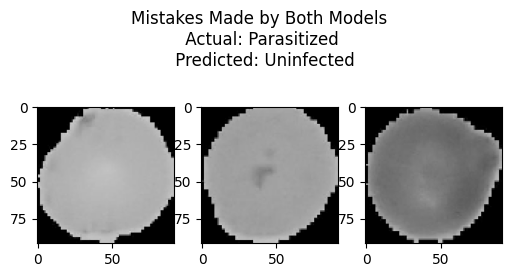

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6,6))
classes = ['Parasitized', 'Uninfected']
fig.suptitle('Mistakes Made by Both Models \n Actual: Parasitized \n Predicted: Uninfected')

fig.subplots_adjust(top=1.3)

for i in range(3):
  #ax[i].set_title('Actual: ' + classes[test_gen.classes[MobileNetErrors[i]]] + "Predicted: " + classes[SuperMobileNet_y_pred[MobileNetErrors[i]]], fontsize=4)
  ax[i].imshow(test_gen[MobileNetErrors[i]][0][0])

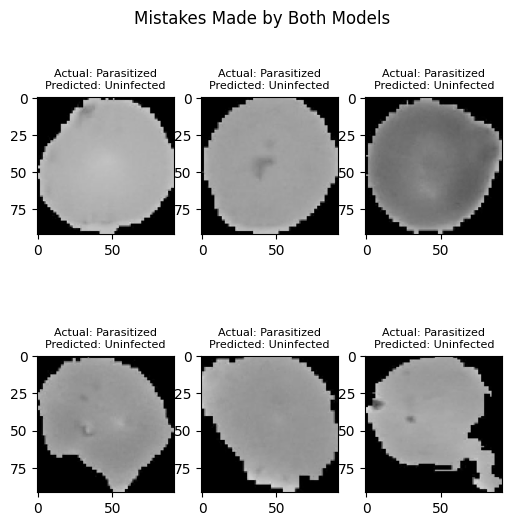

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(6,6))
classes = ['Parasitized', 'Uninfected']
fig.suptitle('Mistakes Made by Both Models')
fig.subplots_adjust(top=0.9)

for i in range(2):
  for j in range(3):
    chunk = 3*i + j
    ax[i, j].set_title('Actual: ' + classes[test_gen.classes[MobileNetErrors[chunk]]] + "\nPredicted: " + classes[SuperMobileNet_y_pred[MobileNetErrors[chunk]]], fontsize=8)
    ax[i, j].imshow(test_gen[MobileNetErrors[chunk]][0][0])

In [ ]:
#New MobileNetV2 model with gamma corrected images

In [ ]:
MobileNetV2Gamma = MobileNetV2(
    input_shape=(height, width, 3),
    include_top=False,
    weights="imagenet",
)


MobileNetV2Gamma.trainable = True

#new model using MobileNetV2Gamma
model = Sequential([
    MobileNetV2Gamma,
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate = 3e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Research - Horizon/Keras models/malaria_MobileNetV2Gamma_best.keras',
    monitor='val_loss',
    save_best_only=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

model.save("/content/drive/MyDrive/Research - Horizon/Keras models/malaria_MobileNetV2Gamma_v1.keras")

#plot results
plt.figure(figsize=(8, 8))
epochs_range = range(len(history.history.get('accuracy', [])))  # Use get to avoid KeyError
plt.plot(epochs_range, history.history.get('accuracy', []), label="Training Accuracy")
plt.plot(epochs_range, history.history.get('val_accuracy', []), label="Validation Accuracy")
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Epoch 1/30
1644/1644 [==============================] - 491s 289ms/step - loss: 0.7331 - accuracy: 0.5451 - val_loss: 1.2248 - val_accuracy: 0.4988 - lr: 3.0000e-04
Epoch 2/30
1644/1644 [==============================] - 470s 286ms/step - loss: 0.6801 - accuracy: 0.5776 - val_loss: 0.8469 - val_accuracy: 0.4972 - lr: 3.0000e-04
Epoch 3/30
1644/1644 [==============================] - 468s 284ms/step - loss: 0.6678 - accuracy: 0.5905 - val_loss: 0.8817 - val_accuracy: 0.4980 - lr: 3.0000e-04
Epoch 4/30
1252/1644 [=====================>........] - ETA: 1:50 - loss: 0.6684 - accuracy: 0.5953

KeyboardInterrupt: 

# TA Suggestions and ideas

In [ ]:
#feature extraction function
def extract_features(generator, model):
    features = []
    img_names = []
    for batch, labels in tqdm(generator):
        batch_features = model.predict(batch)
        batch_features = batch_features.reshape((batch_features.shape[0], -1))  # Flatten
        features.append(batch_features)
        img_names.extend(generator.filenames[:batch_features.shape[0]])
        if len(features) * generator.batch_size >= generator.samples:
            break
    features = np.vstack(features)
    return features, img_names

# Initialize InceptionV3 model
model = InceptionV3(include_top=False, weights='imagenet')
model.trainable = False

# Extract features using the function
train_features, train_img_names = extract_features(train_gen, model)

  0%|          | 0/1644 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  0%|          | 1/1644 [00:03<1:41:51,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


  0%|          | 2/1644 [00:04<49:43,  1.82s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


  0%|          | 3/1644 [00:04<32:50,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


  0%|          | 4/1644 [00:05<24:19,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


  0%|          | 5/1644 [00:05<19:21,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


  0%|          | 6/1644 [00:05<17:10,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


  0%|          | 7/1644 [00:06<15:22,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


  0%|          | 8/1644 [00:06<14:11,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  1%|          | 9/1644 [00:07<12:34,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  1%|          | 10/1644 [00:07<10:41,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  1%|          | 11/1644 [00:07<09:34,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  1%|          | 12/1644 [00:07<08:51,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  1%|          | 13/1644 [00:08<08:34,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  1%|          | 14/1644 [00:08<07:57,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|          | 15/1644 [00:08<07:35,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  1%|          | 16/1644 [00:08<07:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  1%|          | 17/1644 [00:09<07:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  1%|          | 18/1644 [00:09<07:11,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  1%|          | 19/1644 [00:09<07:01,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  1%|          | 20/1644 [00:09<06:54,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|▏         | 21/1644 [00:10<06:53,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  1%|▏         | 22/1644 [00:10<06:44,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  1%|▏         | 23/1644 [00:10<06:51,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  1%|▏         | 24/1644 [00:10<06:54,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  2%|▏         | 25/1644 [00:11<06:58,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  2%|▏         | 26/1644 [00:11<06:57,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  2%|▏         | 27/1644 [00:11<06:51,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  2%|▏         | 28/1644 [00:11<06:51,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  2%|▏         | 29/1644 [00:12<06:44,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  2%|▏         | 30/1644 [00:12<06:38,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  2%|▏         | 31/1644 [00:12<06:38,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  2%|▏         | 32/1644 [00:12<06:34,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  2%|▏         | 33/1644 [00:13<06:35,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  2%|▏         | 34/1644 [00:13<06:36,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  2%|▏         | 35/1644 [00:13<06:38,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|▏         | 36/1644 [00:13<06:38,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  2%|▏         | 37/1644 [00:14<06:50,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  2%|▏         | 38/1644 [00:14<06:52,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  2%|▏         | 39/1644 [00:14<06:50,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  2%|▏         | 40/1644 [00:14<06:49,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  2%|▏         | 41/1644 [00:15<06:53,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  3%|▎         | 42/1644 [00:15<06:55,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  3%|▎         | 43/1644 [00:15<06:45,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  3%|▎         | 44/1644 [00:15<06:41,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  3%|▎         | 45/1644 [00:16<06:39,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  3%|▎         | 46/1644 [00:16<06:36,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  3%|▎         | 47/1644 [00:16<06:36,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  3%|▎         | 48/1644 [00:16<06:41,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


  3%|▎         | 49/1644 [00:17<08:31,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


  3%|▎         | 50/1644 [00:17<08:54,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


  3%|▎         | 51/1644 [00:18<09:21,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


  3%|▎         | 52/1644 [00:18<10:16,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


  3%|▎         | 53/1644 [00:19<10:17,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


  3%|▎         | 54/1644 [00:19<10:05,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


  3%|▎         | 55/1644 [00:19<10:09,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


  3%|▎         | 56/1644 [00:20<10:08,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


  3%|▎         | 57/1644 [00:20<10:12,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


  4%|▎         | 58/1644 [00:21<10:20,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


  4%|▎         | 59/1644 [00:21<10:42,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  4%|▎         | 60/1644 [00:21<11:19,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  4%|▎         | 61/1644 [00:22<09:57,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  4%|▍         | 62/1644 [00:22<08:57,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  4%|▍         | 63/1644 [00:22<08:20,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  4%|▍         | 64/1644 [00:22<07:50,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  4%|▍         | 65/1644 [00:23<07:23,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  4%|▍         | 66/1644 [00:23<07:00,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|▍         | 67/1644 [00:23<06:50,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  4%|▍         | 68/1644 [00:23<06:42,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  4%|▍         | 69/1644 [00:24<06:46,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  4%|▍         | 70/1644 [00:24<06:34,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  4%|▍         | 71/1644 [00:24<06:30,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  4%|▍         | 72/1644 [00:24<06:34,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  4%|▍         | 73/1644 [00:25<06:39,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  5%|▍         | 74/1644 [00:25<06:31,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  5%|▍         | 75/1644 [00:25<06:27,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  5%|▍         | 76/1644 [00:25<06:27,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  5%|▍         | 77/1644 [00:26<06:31,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  5%|▍         | 78/1644 [00:26<06:22,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  5%|▍         | 79/1644 [00:26<06:20,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  5%|▍         | 80/1644 [00:26<06:22,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  5%|▍         | 81/1644 [00:27<06:32,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  5%|▍         | 82/1644 [00:27<06:19,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  5%|▌         | 83/1644 [00:27<06:23,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  5%|▌         | 84/1644 [00:27<06:29,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  5%|▌         | 85/1644 [00:28<06:35,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  5%|▌         | 86/1644 [00:28<06:35,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  5%|▌         | 87/1644 [00:28<06:33,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|▌         | 88/1644 [00:28<06:35,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  5%|▌         | 89/1644 [00:29<06:42,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  5%|▌         | 90/1644 [00:29<06:33,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  6%|▌         | 91/1644 [00:29<06:33,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  6%|▌         | 92/1644 [00:29<06:37,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  6%|▌         | 93/1644 [00:30<06:32,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  6%|▌         | 94/1644 [00:30<06:23,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  6%|▌         | 95/1644 [00:30<06:29,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  6%|▌         | 96/1644 [00:31<06:57,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  6%|▌         | 97/1644 [00:31<06:46,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  6%|▌         | 98/1644 [00:31<06:41,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  6%|▌         | 99/1644 [00:31<06:39,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


  6%|▌         | 100/1644 [00:32<07:52,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


  6%|▌         | 101/1644 [00:32<09:05,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


  6%|▌         | 102/1644 [00:33<09:48,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


  6%|▋         | 103/1644 [00:33<09:41,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


  6%|▋         | 104/1644 [00:33<09:44,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


  6%|▋         | 105/1644 [00:34<09:51,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


  6%|▋         | 106/1644 [00:34<10:23,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


  7%|▋         | 107/1644 [00:35<10:57,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


  7%|▋         | 108/1644 [00:35<11:12,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


  7%|▋         | 109/1644 [00:36<11:40,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  7%|▋         | 110/1644 [00:36<10:12,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  7%|▋         | 111/1644 [00:36<09:08,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  7%|▋         | 112/1644 [00:36<08:20,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  7%|▋         | 113/1644 [00:37<07:55,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  7%|▋         | 114/1644 [00:37<07:30,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  7%|▋         | 115/1644 [00:37<07:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  7%|▋         | 116/1644 [00:37<06:50,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  7%|▋         | 117/1644 [00:38<06:47,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  7%|▋         | 118/1644 [00:38<06:34,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  7%|▋         | 119/1644 [00:38<06:32,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  7%|▋         | 120/1644 [00:38<06:34,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  7%|▋         | 121/1644 [00:39<06:41,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  7%|▋         | 122/1644 [00:39<06:43,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  7%|▋         | 123/1644 [00:39<06:30,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  8%|▊         | 124/1644 [00:39<06:30,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  8%|▊         | 125/1644 [00:40<06:23,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  8%|▊         | 126/1644 [00:40<06:16,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  8%|▊         | 127/1644 [00:40<06:13,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  8%|▊         | 128/1644 [00:40<06:08,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  8%|▊         | 129/1644 [00:41<06:15,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  8%|▊         | 130/1644 [00:41<06:14,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  8%|▊         | 131/1644 [00:41<06:24,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  8%|▊         | 132/1644 [00:41<06:26,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  8%|▊         | 133/1644 [00:42<06:25,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  8%|▊         | 134/1644 [00:42<06:25,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  8%|▊         | 135/1644 [00:42<06:19,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  8%|▊         | 136/1644 [00:42<06:23,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  8%|▊         | 137/1644 [00:43<06:19,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  8%|▊         | 138/1644 [00:43<06:16,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  8%|▊         | 139/1644 [00:43<06:21,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  9%|▊         | 140/1644 [00:43<06:16,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  9%|▊         | 141/1644 [00:44<06:15,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  9%|▊         | 142/1644 [00:44<06:13,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  9%|▊         | 143/1644 [00:44<06:17,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  9%|▉         | 144/1644 [00:44<06:15,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  9%|▉         | 145/1644 [00:45<06:17,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  9%|▉         | 146/1644 [00:45<06:17,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  9%|▉         | 147/1644 [00:45<06:13,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  9%|▉         | 148/1644 [00:46<06:16,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  9%|▉         | 149/1644 [00:46<06:22,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


  9%|▉         | 150/1644 [00:46<07:54,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


  9%|▉         | 151/1644 [00:47<08:21,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


  9%|▉         | 152/1644 [00:47<08:31,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


  9%|▉         | 153/1644 [00:47<09:32,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


  9%|▉         | 154/1644 [00:48<09:36,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


  9%|▉         | 155/1644 [00:48<09:42,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


  9%|▉         | 156/1644 [00:49<09:42,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 10%|▉         | 157/1644 [00:49<10:15,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 10%|▉         | 158/1644 [00:50<10:49,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 10%|▉         | 159/1644 [00:50<11:06,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 10%|▉         | 160/1644 [00:50<09:59,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 10%|▉         | 161/1644 [00:51<08:55,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 10%|▉         | 162/1644 [00:51<08:00,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 10%|▉         | 163/1644 [00:51<07:24,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 10%|▉         | 164/1644 [00:51<06:56,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 10%|█         | 165/1644 [00:52<06:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 10%|█         | 166/1644 [00:52<06:30,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 10%|█         | 167/1644 [00:52<06:24,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 10%|█         | 168/1644 [00:52<06:20,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 10%|█         | 169/1644 [00:53<06:25,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 10%|█         | 170/1644 [00:53<06:25,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 10%|█         | 171/1644 [00:53<06:22,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 10%|█         | 172/1644 [00:53<06:20,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 11%|█         | 173/1644 [00:54<06:25,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 11%|█         | 174/1644 [00:54<06:11,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 11%|█         | 175/1644 [00:54<06:09,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 11%|█         | 176/1644 [00:54<05:59,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 11%|█         | 177/1644 [00:55<06:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 11%|█         | 178/1644 [00:55<05:59,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 11%|█         | 179/1644 [00:55<05:59,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 11%|█         | 180/1644 [00:55<05:58,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 11%|█         | 181/1644 [00:56<06:12,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 11%|█         | 182/1644 [00:56<06:12,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 11%|█         | 183/1644 [00:56<06:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 11%|█         | 184/1644 [00:56<06:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 11%|█▏        | 185/1644 [00:57<07:22,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 11%|█▏        | 186/1644 [00:57<06:50,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|█▏        | 187/1644 [00:57<06:31,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 11%|█▏        | 188/1644 [00:58<06:20,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 11%|█▏        | 189/1644 [00:58<06:11,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 12%|█▏        | 190/1644 [00:58<06:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 12%|█▏        | 191/1644 [00:58<06:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 12%|█▏        | 192/1644 [00:59<06:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 12%|█▏        | 193/1644 [00:59<06:10,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 12%|█▏        | 194/1644 [00:59<06:03,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 12%|█▏        | 195/1644 [00:59<06:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 12%|█▏        | 196/1644 [01:00<06:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 12%|█▏        | 197/1644 [01:00<06:15,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 12%|█▏        | 198/1644 [01:00<06:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 12%|█▏        | 199/1644 [01:00<06:18,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 12%|█▏        | 200/1644 [01:01<07:52,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 12%|█▏        | 201/1644 [01:01<08:13,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 12%|█▏        | 202/1644 [01:02<08:34,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 12%|█▏        | 203/1644 [01:02<09:01,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 12%|█▏        | 204/1644 [01:02<09:13,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 12%|█▏        | 205/1644 [01:03<09:53,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 13%|█▎        | 206/1644 [01:03<09:33,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 13%|█▎        | 207/1644 [01:04<09:36,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 13%|█▎        | 208/1644 [01:04<09:27,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 13%|█▎        | 209/1644 [01:04<09:29,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 13%|█▎        | 210/1644 [01:05<09:49,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 13%|█▎        | 211/1644 [01:05<09:21,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 13%|█▎        | 212/1644 [01:05<08:21,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 13%|█▎        | 213/1644 [01:06<07:36,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 13%|█▎        | 214/1644 [01:06<07:07,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 13%|█▎        | 215/1644 [01:06<06:52,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 13%|█▎        | 216/1644 [01:06<06:36,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 13%|█▎        | 217/1644 [01:07<06:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 13%|█▎        | 218/1644 [01:07<06:20,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 13%|█▎        | 219/1644 [01:07<06:09,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 13%|█▎        | 220/1644 [01:07<06:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 13%|█▎        | 221/1644 [01:08<06:05,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 14%|█▎        | 222/1644 [01:08<06:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 14%|█▎        | 223/1644 [01:08<05:59,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|█▎        | 224/1644 [01:08<05:56,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 14%|█▎        | 225/1644 [01:09<05:56,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 14%|█▎        | 226/1644 [01:09<05:47,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 14%|█▍        | 227/1644 [01:09<05:58,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 14%|█▍        | 228/1644 [01:10<06:00,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 14%|█▍        | 229/1644 [01:10<06:05,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 14%|█▍        | 230/1644 [01:10<05:58,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 14%|█▍        | 231/1644 [01:10<06:00,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 14%|█▍        | 232/1644 [01:11<06:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 14%|█▍        | 233/1644 [01:11<05:55,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 14%|█▍        | 234/1644 [01:11<05:55,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 14%|█▍        | 235/1644 [01:11<05:56,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 14%|█▍        | 236/1644 [01:12<05:59,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|█▍        | 237/1644 [01:12<05:54,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 14%|█▍        | 238/1644 [01:12<05:46,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 15%|█▍        | 239/1644 [01:12<05:53,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 15%|█▍        | 240/1644 [01:13<05:57,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 15%|█▍        | 241/1644 [01:13<05:59,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 15%|█▍        | 242/1644 [01:13<05:52,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 15%|█▍        | 243/1644 [01:13<05:53,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 15%|█▍        | 244/1644 [01:14<07:01,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 15%|█▍        | 245/1644 [01:14<06:34,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 15%|█▍        | 246/1644 [01:14<06:16,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 15%|█▌        | 247/1644 [01:14<06:06,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 15%|█▌        | 248/1644 [01:15<06:01,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 15%|█▌        | 249/1644 [01:15<05:53,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 15%|█▌        | 250/1644 [01:15<05:49,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 15%|█▌        | 251/1644 [01:16<07:37,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 15%|█▌        | 252/1644 [01:16<07:54,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 15%|█▌        | 253/1644 [01:16<08:15,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 15%|█▌        | 254/1644 [01:17<09:10,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 16%|█▌        | 255/1644 [01:17<09:08,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 16%|█▌        | 256/1644 [01:18<09:47,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 16%|█▌        | 257/1644 [01:18<10:04,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 16%|█▌        | 258/1644 [01:19<10:18,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 16%|█▌        | 259/1644 [01:19<09:56,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 16%|█▌        | 260/1644 [01:20<09:52,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 16%|█▌        | 261/1644 [01:20<09:32,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 16%|█▌        | 262/1644 [01:20<08:35,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 16%|█▌        | 263/1644 [01:20<07:47,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 16%|█▌        | 264/1644 [01:21<07:24,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 16%|█▌        | 265/1644 [01:21<06:56,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 16%|█▌        | 266/1644 [01:21<06:36,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 16%|█▌        | 267/1644 [01:22<06:23,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 16%|█▋        | 268/1644 [01:22<06:12,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 16%|█▋        | 269/1644 [01:22<06:03,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 16%|█▋        | 270/1644 [01:22<05:53,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 16%|█▋        | 271/1644 [01:23<05:48,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 17%|█▋        | 272/1644 [01:23<05:48,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 17%|█▋        | 273/1644 [01:23<05:44,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 17%|█▋        | 274/1644 [01:23<05:42,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 17%|█▋        | 275/1644 [01:24<05:44,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 17%|█▋        | 276/1644 [01:24<05:51,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 17%|█▋        | 277/1644 [01:24<05:44,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 17%|█▋        | 278/1644 [01:24<05:46,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 17%|█▋        | 279/1644 [01:25<05:46,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 17%|█▋        | 280/1644 [01:25<05:51,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 17%|█▋        | 281/1644 [01:25<05:49,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 17%|█▋        | 282/1644 [01:25<05:41,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 17%|█▋        | 283/1644 [01:26<05:43,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|█▋        | 284/1644 [01:26<05:45,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 17%|█▋        | 285/1644 [01:26<05:34,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 17%|█▋        | 286/1644 [01:26<05:33,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 17%|█▋        | 287/1644 [01:27<05:44,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 18%|█▊        | 288/1644 [01:27<05:46,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 18%|█▊        | 289/1644 [01:27<05:41,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 18%|█▊        | 290/1644 [01:27<05:43,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 18%|█▊        | 291/1644 [01:28<05:41,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 18%|█▊        | 292/1644 [01:28<05:41,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 18%|█▊        | 293/1644 [01:28<05:38,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 18%|█▊        | 294/1644 [01:28<05:36,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 18%|█▊        | 295/1644 [01:29<05:38,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 18%|█▊        | 296/1644 [01:29<05:36,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 18%|█▊        | 297/1644 [01:29<05:32,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 18%|█▊        | 298/1644 [01:29<05:31,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 18%|█▊        | 299/1644 [01:30<05:40,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 18%|█▊        | 300/1644 [01:30<05:43,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 18%|█▊        | 301/1644 [01:30<05:44,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 18%|█▊        | 302/1644 [01:31<07:11,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 18%|█▊        | 303/1644 [01:31<07:37,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 18%|█▊        | 304/1644 [01:31<07:54,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 19%|█▊        | 305/1644 [01:32<08:10,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 19%|█▊        | 306/1644 [01:32<08:14,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 19%|█▊        | 307/1644 [01:32<08:23,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 19%|█▊        | 308/1644 [01:33<08:24,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 19%|█▉        | 309/1644 [01:33<08:31,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 19%|█▉        | 310/1644 [01:34<08:26,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 19%|█▉        | 311/1644 [01:34<08:26,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 19%|█▉        | 312/1644 [01:34<08:37,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 19%|█▉        | 313/1644 [01:35<08:55,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 19%|█▉        | 314/1644 [01:35<09:26,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 19%|█▉        | 315/1644 [01:36<08:19,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 19%|█▉        | 316/1644 [01:36<07:28,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 19%|█▉        | 317/1644 [01:36<06:54,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 19%|█▉        | 318/1644 [01:36<06:31,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 19%|█▉        | 319/1644 [01:37<06:14,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 19%|█▉        | 320/1644 [01:37<05:56,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 20%|█▉        | 321/1644 [01:37<05:47,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 20%|█▉        | 322/1644 [01:37<05:39,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 20%|█▉        | 323/1644 [01:38<05:43,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 20%|█▉        | 324/1644 [01:38<05:35,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 20%|█▉        | 325/1644 [01:38<05:37,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 20%|█▉        | 326/1644 [01:38<05:41,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 20%|█▉        | 327/1644 [01:39<05:44,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|█▉        | 328/1644 [01:39<05:41,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 20%|██        | 329/1644 [01:39<05:36,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 20%|██        | 330/1644 [01:39<05:33,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|██        | 331/1644 [01:40<05:40,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 20%|██        | 332/1644 [01:40<05:26,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 20%|██        | 333/1644 [01:40<05:21,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 20%|██        | 334/1644 [01:40<05:22,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 20%|██        | 335/1644 [01:41<05:29,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 20%|██        | 336/1644 [01:41<05:32,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|██        | 337/1644 [01:41<05:27,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 21%|██        | 338/1644 [01:41<05:32,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 21%|██        | 339/1644 [01:42<05:36,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 21%|██        | 340/1644 [01:42<05:33,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 21%|██        | 341/1644 [01:42<05:28,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 21%|██        | 342/1644 [01:42<05:27,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 21%|██        | 343/1644 [01:43<05:27,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 21%|██        | 344/1644 [01:43<05:20,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 21%|██        | 345/1644 [01:43<05:16,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 21%|██        | 346/1644 [01:43<05:17,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 21%|██        | 347/1644 [01:44<05:25,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 21%|██        | 348/1644 [01:44<05:28,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 21%|██        | 349/1644 [01:44<05:24,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 21%|██▏       | 350/1644 [01:44<05:26,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 21%|██▏       | 351/1644 [01:45<05:37,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 21%|██▏       | 352/1644 [01:45<05:33,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 21%|██▏       | 353/1644 [01:45<05:32,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 22%|██▏       | 354/1644 [01:46<06:30,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 22%|██▏       | 355/1644 [01:46<07:32,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 22%|██▏       | 356/1644 [01:47<08:13,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 22%|██▏       | 357/1644 [01:47<08:02,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 22%|██▏       | 358/1644 [01:47<08:09,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 22%|██▏       | 359/1644 [01:48<08:17,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 22%|██▏       | 360/1644 [01:48<08:53,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 22%|██▏       | 361/1644 [01:49<08:40,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 22%|██▏       | 362/1644 [01:49<08:45,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 22%|██▏       | 363/1644 [01:49<08:50,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 22%|██▏       | 364/1644 [01:50<09:31,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 22%|██▏       | 365/1644 [01:50<08:20,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|██▏       | 366/1644 [01:50<07:22,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 22%|██▏       | 367/1644 [01:51<06:42,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 22%|██▏       | 368/1644 [01:51<06:22,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 22%|██▏       | 369/1644 [01:51<05:59,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 23%|██▎       | 370/1644 [01:51<05:40,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 23%|██▎       | 371/1644 [01:52<05:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 23%|██▎       | 372/1644 [01:52<05:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 23%|██▎       | 373/1644 [01:52<05:35,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 23%|██▎       | 374/1644 [01:52<05:34,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 23%|██▎       | 375/1644 [01:53<05:27,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 23%|██▎       | 376/1644 [01:53<05:26,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 23%|██▎       | 377/1644 [01:53<05:20,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 23%|██▎       | 378/1644 [01:53<05:20,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 23%|██▎       | 379/1644 [01:54<05:22,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 23%|██▎       | 380/1644 [01:54<05:19,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|██▎       | 381/1644 [01:54<05:17,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 23%|██▎       | 382/1644 [01:54<05:09,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 23%|██▎       | 383/1644 [01:55<05:16,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 23%|██▎       | 384/1644 [01:55<05:18,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 23%|██▎       | 385/1644 [01:55<05:25,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 23%|██▎       | 386/1644 [01:55<05:17,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 24%|██▎       | 387/1644 [01:56<05:19,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 24%|██▎       | 388/1644 [01:56<05:18,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 24%|██▎       | 389/1644 [01:56<05:19,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 24%|██▎       | 390/1644 [01:56<05:16,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 24%|██▍       | 391/1644 [01:57<05:18,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|██▍       | 392/1644 [01:57<05:11,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 24%|██▍       | 393/1644 [01:57<05:08,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 24%|██▍       | 394/1644 [01:57<05:05,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 24%|██▍       | 395/1644 [01:58<05:10,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 24%|██▍       | 396/1644 [01:58<05:13,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 24%|██▍       | 397/1644 [01:58<05:20,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 24%|██▍       | 398/1644 [01:59<05:21,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 24%|██▍       | 399/1644 [01:59<05:27,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 24%|██▍       | 400/1644 [01:59<05:20,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 24%|██▍       | 401/1644 [01:59<05:26,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 24%|██▍       | 402/1644 [02:00<05:23,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 25%|██▍       | 403/1644 [02:00<05:19,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 25%|██▍       | 404/1644 [02:00<06:17,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 25%|██▍       | 405/1644 [02:01<07:13,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 25%|██▍       | 406/1644 [02:01<07:20,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 25%|██▍       | 407/1644 [02:01<07:35,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 25%|██▍       | 408/1644 [02:02<07:39,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 25%|██▍       | 409/1644 [02:02<08:18,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 25%|██▍       | 410/1644 [02:03<08:38,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 25%|██▌       | 411/1644 [02:03<08:53,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 25%|██▌       | 412/1644 [02:04<08:38,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 25%|██▌       | 413/1644 [02:04<08:25,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 25%|██▌       | 414/1644 [02:04<08:25,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 25%|██▌       | 415/1644 [02:05<09:02,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 25%|██▌       | 416/1644 [02:05<07:52,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 25%|██▌       | 417/1644 [02:05<07:01,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 25%|██▌       | 418/1644 [02:06<06:30,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 25%|██▌       | 419/1644 [02:06<06:04,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 26%|██▌       | 420/1644 [02:06<05:50,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 26%|██▌       | 421/1644 [02:06<05:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 26%|██▌       | 422/1644 [02:07<05:30,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 26%|██▌       | 423/1644 [02:07<05:22,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 26%|██▌       | 424/1644 [02:07<05:17,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 26%|██▌       | 425/1644 [02:07<05:16,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 26%|██▌       | 426/1644 [02:08<05:19,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 26%|██▌       | 427/1644 [02:08<05:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 26%|██▌       | 428/1644 [02:08<05:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 26%|██▌       | 429/1644 [02:08<04:57,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 26%|██▌       | 430/1644 [02:09<05:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 26%|██▌       | 431/1644 [02:09<05:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 26%|██▋       | 432/1644 [02:09<05:07,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 26%|██▋       | 433/1644 [02:09<05:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 26%|██▋       | 434/1644 [02:10<05:16,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 26%|██▋       | 435/1644 [02:10<05:12,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 27%|██▋       | 436/1644 [02:10<05:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 27%|██▋       | 437/1644 [02:11<05:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 27%|██▋       | 438/1644 [02:11<05:12,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 27%|██▋       | 439/1644 [02:11<05:09,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 27%|██▋       | 440/1644 [02:11<05:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 27%|██▋       | 441/1644 [02:12<05:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 27%|██▋       | 442/1644 [02:12<05:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 27%|██▋       | 443/1644 [02:12<05:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 27%|██▋       | 444/1644 [02:12<05:05,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 27%|██▋       | 445/1644 [02:13<05:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 27%|██▋       | 446/1644 [02:13<05:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 27%|██▋       | 447/1644 [02:13<05:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 27%|██▋       | 448/1644 [02:13<04:59,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 27%|██▋       | 449/1644 [02:14<04:58,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 27%|██▋       | 450/1644 [02:14<05:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 27%|██▋       | 451/1644 [02:14<04:55,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 27%|██▋       | 452/1644 [02:14<04:54,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 28%|██▊       | 453/1644 [02:15<04:51,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 28%|██▊       | 454/1644 [02:15<04:55,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 28%|██▊       | 455/1644 [02:15<05:16,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 28%|██▊       | 456/1644 [02:16<06:35,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 28%|██▊       | 457/1644 [02:16<07:24,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 28%|██▊       | 458/1644 [02:17<07:55,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 28%|██▊       | 459/1644 [02:17<07:48,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 28%|██▊       | 460/1644 [02:17<08:12,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 28%|██▊       | 461/1644 [02:18<08:30,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 28%|██▊       | 462/1644 [02:18<08:37,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 28%|██▊       | 463/1644 [02:19<08:21,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 28%|██▊       | 464/1644 [02:19<08:24,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 28%|██▊       | 465/1644 [02:19<08:09,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 28%|██▊       | 466/1644 [02:20<07:30,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 28%|██▊       | 467/1644 [02:20<06:46,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 28%|██▊       | 468/1644 [02:20<06:17,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 29%|██▊       | 469/1644 [02:21<05:51,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 29%|██▊       | 470/1644 [02:21<05:37,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 29%|██▊       | 471/1644 [02:21<05:25,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 29%|██▊       | 472/1644 [02:21<05:15,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 29%|██▉       | 473/1644 [02:22<06:02,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 29%|██▉       | 474/1644 [02:22<05:39,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 29%|██▉       | 475/1644 [02:22<05:24,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 29%|██▉       | 476/1644 [02:22<05:11,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 29%|██▉       | 477/1644 [02:23<05:15,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 29%|██▉       | 478/1644 [02:23<05:01,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 29%|██▉       | 479/1644 [02:23<05:05,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██▉       | 480/1644 [02:24<05:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 29%|██▉       | 481/1644 [02:24<05:04,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 29%|██▉       | 482/1644 [02:24<04:59,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 29%|██▉       | 483/1644 [02:24<04:54,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 29%|██▉       | 484/1644 [02:25<04:56,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 30%|██▉       | 485/1644 [02:25<04:50,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 30%|██▉       | 486/1644 [02:25<04:43,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 30%|██▉       | 487/1644 [02:25<04:44,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 30%|██▉       | 488/1644 [02:25<04:43,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 30%|██▉       | 489/1644 [02:26<04:48,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 30%|██▉       | 490/1644 [02:26<04:42,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 30%|██▉       | 491/1644 [02:26<04:55,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 30%|██▉       | 492/1644 [02:27<04:56,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 30%|██▉       | 493/1644 [02:27<04:55,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 30%|███       | 494/1644 [02:27<04:55,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 30%|███       | 495/1644 [02:27<04:54,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 30%|███       | 496/1644 [02:28<04:55,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 30%|███       | 497/1644 [02:28<04:48,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 30%|███       | 498/1644 [02:28<04:46,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 30%|███       | 499/1644 [02:28<04:47,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 30%|███       | 500/1644 [02:29<04:49,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 30%|███       | 501/1644 [02:29<04:44,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 31%|███       | 502/1644 [02:29<04:38,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 31%|███       | 503/1644 [02:29<04:47,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 31%|███       | 504/1644 [02:30<04:51,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 31%|███       | 505/1644 [02:30<05:48,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 31%|███       | 506/1644 [02:30<06:46,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 31%|███       | 507/1644 [02:31<07:24,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 31%|███       | 508/1644 [02:31<07:45,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 31%|███       | 509/1644 [02:32<07:41,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 31%|███       | 510/1644 [02:32<07:34,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 31%|███       | 511/1644 [02:33<07:50,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 31%|███       | 512/1644 [02:33<08:03,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 31%|███       | 513/1644 [02:34<08:13,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 31%|███▏      | 514/1644 [02:34<08:02,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 31%|███▏      | 515/1644 [02:34<07:54,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 31%|███▏      | 516/1644 [02:35<07:40,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 31%|███▏      | 517/1644 [02:35<06:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 32%|███▏      | 518/1644 [02:35<06:04,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 32%|███▏      | 519/1644 [02:35<05:43,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 32%|███▏      | 520/1644 [02:36<05:26,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 32%|███▏      | 521/1644 [02:36<05:10,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 32%|███▏      | 522/1644 [02:36<04:57,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 32%|███▏      | 523/1644 [02:36<04:50,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 32%|███▏      | 524/1644 [02:37<04:49,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 32%|███▏      | 525/1644 [02:37<04:40,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 32%|███▏      | 526/1644 [02:37<04:34,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 32%|███▏      | 527/1644 [02:37<04:38,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 32%|███▏      | 528/1644 [02:38<04:47,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 32%|███▏      | 529/1644 [02:38<04:42,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 32%|███▏      | 530/1644 [02:38<04:43,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 32%|███▏      | 531/1644 [02:38<04:40,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 32%|███▏      | 532/1644 [02:39<04:49,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 32%|███▏      | 533/1644 [02:39<04:46,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 32%|███▏      | 534/1644 [02:39<04:40,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 33%|███▎      | 535/1644 [02:39<04:36,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 33%|███▎      | 536/1644 [02:40<04:41,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 33%|███▎      | 537/1644 [02:40<04:39,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 33%|███▎      | 538/1644 [02:40<04:30,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 33%|███▎      | 539/1644 [02:40<04:35,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|███▎      | 540/1644 [02:41<04:40,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 33%|███▎      | 541/1644 [02:41<04:42,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 33%|███▎      | 542/1644 [02:41<04:41,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 33%|███▎      | 543/1644 [02:42<04:42,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 33%|███▎      | 544/1644 [02:42<04:44,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 33%|███▎      | 545/1644 [02:42<04:35,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 33%|███▎      | 546/1644 [02:42<04:38,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 33%|███▎      | 547/1644 [02:42<04:32,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 33%|███▎      | 548/1644 [02:43<04:34,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 33%|███▎      | 549/1644 [02:43<04:32,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 33%|███▎      | 550/1644 [02:43<04:28,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 34%|███▎      | 551/1644 [02:43<04:33,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 34%|███▎      | 552/1644 [02:44<04:42,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 34%|███▎      | 553/1644 [02:44<04:38,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 34%|███▎      | 554/1644 [02:44<04:39,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 34%|███▍      | 555/1644 [02:45<04:39,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 34%|███▍      | 556/1644 [02:45<05:30,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 34%|███▍      | 557/1644 [02:45<05:59,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 34%|███▍      | 558/1644 [02:46<06:18,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 34%|███▍      | 559/1644 [02:46<06:51,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 34%|███▍      | 560/1644 [02:47<06:51,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 34%|███▍      | 561/1644 [02:47<06:50,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 34%|███▍      | 562/1644 [02:47<06:51,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 34%|███▍      | 563/1644 [02:48<07:01,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 34%|███▍      | 564/1644 [02:48<07:26,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 34%|███▍      | 565/1644 [02:49<07:38,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 34%|███▍      | 566/1644 [02:49<07:28,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 34%|███▍      | 567/1644 [02:50<07:52,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 35%|███▍      | 568/1644 [02:50<08:01,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 35%|███▍      | 569/1644 [02:50<06:57,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 35%|███▍      | 570/1644 [02:51<06:17,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 35%|███▍      | 571/1644 [02:51<05:38,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 35%|███▍      | 572/1644 [02:51<05:18,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 35%|███▍      | 573/1644 [02:51<05:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 35%|███▍      | 574/1644 [02:52<04:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 35%|███▍      | 575/1644 [02:52<04:48,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 35%|███▌      | 576/1644 [02:52<04:43,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 35%|███▌      | 577/1644 [02:52<04:37,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 35%|███▌      | 578/1644 [02:53<04:37,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 35%|███▌      | 579/1644 [02:53<04:32,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|███▌      | 580/1644 [02:53<04:32,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 35%|███▌      | 581/1644 [02:53<04:24,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 35%|███▌      | 582/1644 [02:54<04:31,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 35%|███▌      | 583/1644 [02:54<04:28,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 36%|███▌      | 584/1644 [02:54<04:23,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 36%|███▌      | 585/1644 [02:54<04:21,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 36%|███▌      | 586/1644 [02:55<04:23,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 36%|███▌      | 587/1644 [02:55<04:26,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 36%|███▌      | 588/1644 [02:55<04:26,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 36%|███▌      | 589/1644 [02:55<04:22,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 36%|███▌      | 590/1644 [02:56<04:28,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 36%|███▌      | 591/1644 [02:56<04:28,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 36%|███▌      | 592/1644 [02:56<04:20,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 36%|███▌      | 593/1644 [02:56<04:22,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 36%|███▌      | 594/1644 [02:57<04:29,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 36%|███▌      | 595/1644 [02:57<04:22,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 36%|███▋      | 596/1644 [02:57<04:17,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 36%|███▋      | 597/1644 [02:57<04:16,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 36%|███▋      | 598/1644 [02:58<04:27,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|███▋      | 599/1644 [02:58<04:26,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|███▋      | 600/1644 [02:58<04:26,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 37%|███▋      | 601/1644 [02:58<04:26,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 37%|███▋      | 602/1644 [02:59<05:14,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 37%|███▋      | 603/1644 [02:59<04:58,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|███▋      | 604/1644 [02:59<04:42,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 37%|███▋      | 605/1644 [02:59<04:39,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 37%|███▋      | 606/1644 [03:00<04:38,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 37%|███▋      | 607/1644 [03:00<04:32,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 37%|███▋      | 608/1644 [03:00<05:06,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 37%|███▋      | 609/1644 [03:01<05:57,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 37%|███▋      | 610/1644 [03:01<06:07,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 37%|███▋      | 611/1644 [03:02<06:42,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 37%|███▋      | 612/1644 [03:02<07:03,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 37%|███▋      | 613/1644 [03:03<06:53,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 37%|███▋      | 614/1644 [03:03<06:54,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 37%|███▋      | 615/1644 [03:03<06:47,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 37%|███▋      | 616/1644 [03:04<07:09,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 38%|███▊      | 617/1644 [03:04<07:21,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 38%|███▊      | 618/1644 [03:05<07:08,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 38%|███▊      | 619/1644 [03:05<07:17,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|███▊      | 620/1644 [03:05<06:23,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 38%|███▊      | 621/1644 [03:06<05:40,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 38%|███▊      | 622/1644 [03:06<05:11,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 38%|███▊      | 623/1644 [03:06<04:58,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 38%|███▊      | 624/1644 [03:06<04:47,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 38%|███▊      | 625/1644 [03:07<04:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 38%|███▊      | 626/1644 [03:07<04:34,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 38%|███▊      | 627/1644 [03:07<04:26,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 38%|███▊      | 628/1644 [03:07<04:19,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 38%|███▊      | 629/1644 [03:08<04:20,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 38%|███▊      | 630/1644 [03:08<04:14,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 38%|███▊      | 631/1644 [03:08<04:14,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|███▊      | 632/1644 [03:08<04:10,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 39%|███▊      | 633/1644 [03:09<04:11,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 39%|███▊      | 634/1644 [03:09<04:09,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 39%|███▊      | 635/1644 [03:09<04:13,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 39%|███▊      | 636/1644 [03:09<04:13,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 39%|███▊      | 637/1644 [03:10<04:14,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 39%|███▉      | 638/1644 [03:10<04:15,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 39%|███▉      | 639/1644 [03:10<04:15,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 39%|███▉      | 640/1644 [03:10<04:12,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 39%|███▉      | 641/1644 [03:11<05:01,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 39%|███▉      | 642/1644 [03:11<04:44,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 39%|███▉      | 643/1644 [03:11<04:38,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 39%|███▉      | 644/1644 [03:11<04:29,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 39%|███▉      | 645/1644 [03:12<04:20,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 39%|███▉      | 646/1644 [03:12<04:13,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 39%|███▉      | 647/1644 [03:12<04:15,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|███▉      | 648/1644 [03:12<04:16,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|███▉      | 649/1644 [03:13<04:18,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 40%|███▉      | 650/1644 [03:13<04:14,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 40%|███▉      | 651/1644 [03:13<04:15,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 40%|███▉      | 652/1644 [03:14<04:11,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 40%|███▉      | 653/1644 [03:14<04:12,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 40%|███▉      | 654/1644 [03:14<04:08,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 40%|███▉      | 655/1644 [03:14<04:10,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 40%|███▉      | 656/1644 [03:15<04:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 40%|███▉      | 657/1644 [03:15<04:04,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 40%|████      | 658/1644 [03:15<04:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 40%|████      | 659/1644 [03:15<04:38,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 40%|████      | 660/1644 [03:16<05:43,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 40%|████      | 661/1644 [03:16<06:15,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 40%|████      | 662/1644 [03:17<06:49,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 40%|████      | 663/1644 [03:17<06:37,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 40%|████      | 664/1644 [03:18<06:54,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 40%|████      | 665/1644 [03:18<06:40,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 41%|████      | 666/1644 [03:19<06:59,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 41%|████      | 667/1644 [03:19<06:42,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 41%|████      | 668/1644 [03:19<06:39,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 41%|████      | 669/1644 [03:20<06:42,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 41%|████      | 670/1644 [03:20<06:56,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 41%|████      | 671/1644 [03:20<06:06,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|████      | 672/1644 [03:21<05:36,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 41%|████      | 673/1644 [03:21<05:05,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 41%|████      | 674/1644 [03:21<04:45,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 41%|████      | 675/1644 [03:21<04:35,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 41%|████      | 676/1644 [03:22<04:29,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 41%|████      | 677/1644 [03:22<04:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 41%|████      | 678/1644 [03:22<04:16,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 41%|████▏     | 679/1644 [03:22<04:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 41%|████▏     | 680/1644 [03:23<04:13,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 41%|████▏     | 681/1644 [03:23<04:09,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 41%|████▏     | 682/1644 [03:23<04:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 42%|████▏     | 683/1644 [03:24<04:57,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 42%|████▏     | 684/1644 [03:24<04:39,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 42%|████▏     | 685/1644 [03:24<04:25,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 42%|████▏     | 686/1644 [03:24<04:16,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 42%|████▏     | 687/1644 [03:25<04:18,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 42%|████▏     | 688/1644 [03:25<04:09,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 42%|████▏     | 689/1644 [03:25<04:02,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 42%|████▏     | 690/1644 [03:25<04:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 42%|████▏     | 691/1644 [03:26<04:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 42%|████▏     | 692/1644 [03:26<03:57,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 42%|████▏     | 693/1644 [03:26<03:56,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 42%|████▏     | 694/1644 [03:26<03:53,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 42%|████▏     | 695/1644 [03:27<03:59,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 42%|████▏     | 696/1644 [03:27<04:00,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████▏     | 697/1644 [03:27<03:59,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 42%|████▏     | 698/1644 [03:27<04:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|████▎     | 699/1644 [03:28<03:58,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 43%|████▎     | 700/1644 [03:28<04:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 43%|████▎     | 701/1644 [03:28<03:59,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 43%|████▎     | 702/1644 [03:28<03:52,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 43%|████▎     | 703/1644 [03:29<03:58,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 43%|████▎     | 704/1644 [03:29<03:54,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 43%|████▎     | 705/1644 [03:29<03:53,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 43%|████▎     | 706/1644 [03:29<03:52,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 43%|████▎     | 707/1644 [03:30<04:02,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 43%|████▎     | 708/1644 [03:30<04:02,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 43%|████▎     | 709/1644 [03:30<04:45,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 43%|████▎     | 710/1644 [03:31<05:08,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 43%|████▎     | 711/1644 [03:31<05:33,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 43%|████▎     | 712/1644 [03:32<06:08,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 43%|████▎     | 713/1644 [03:32<06:02,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 43%|████▎     | 714/1644 [03:33<06:31,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 43%|████▎     | 715/1644 [03:33<06:37,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 44%|████▎     | 716/1644 [03:33<06:24,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 44%|████▎     | 717/1644 [03:34<06:16,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 44%|████▎     | 718/1644 [03:34<06:33,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 44%|████▎     | 719/1644 [03:35<06:46,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 44%|████▍     | 720/1644 [03:35<06:50,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 44%|████▍     | 721/1644 [03:35<05:55,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 44%|████▍     | 722/1644 [03:36<05:23,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 44%|████▍     | 723/1644 [03:36<04:56,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 44%|████▍     | 724/1644 [03:36<04:40,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 44%|████▍     | 725/1644 [03:36<04:26,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 44%|████▍     | 726/1644 [03:37<04:17,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 44%|████▍     | 727/1644 [03:37<04:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 44%|████▍     | 728/1644 [03:37<04:03,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 44%|████▍     | 729/1644 [03:37<04:00,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 44%|████▍     | 730/1644 [03:38<03:54,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 44%|████▍     | 731/1644 [03:38<03:53,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 45%|████▍     | 732/1644 [03:38<03:55,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 45%|████▍     | 733/1644 [03:38<03:57,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 45%|████▍     | 734/1644 [03:39<03:59,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|████▍     | 735/1644 [03:39<03:51,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 45%|████▍     | 736/1644 [03:39<03:53,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 45%|████▍     | 737/1644 [03:40<03:56,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|████▍     | 738/1644 [03:40<03:50,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 45%|████▍     | 739/1644 [03:40<03:49,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 45%|████▌     | 740/1644 [03:40<03:44,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 45%|████▌     | 741/1644 [03:41<03:49,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 45%|████▌     | 742/1644 [03:41<03:46,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|████▌     | 743/1644 [03:41<03:49,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|████▌     | 744/1644 [03:41<03:45,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 45%|████▌     | 745/1644 [03:42<04:35,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|████▌     | 746/1644 [03:42<04:19,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 45%|████▌     | 747/1644 [03:42<04:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 45%|████▌     | 748/1644 [03:42<04:01,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 46%|████▌     | 749/1644 [03:43<03:57,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 46%|████▌     | 750/1644 [03:43<03:54,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 46%|████▌     | 751/1644 [03:43<03:48,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 46%|████▌     | 752/1644 [03:43<03:47,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 46%|████▌     | 753/1644 [03:44<03:48,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|████▌     | 754/1644 [03:44<03:41,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 46%|████▌     | 755/1644 [03:44<03:45,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 46%|████▌     | 756/1644 [03:44<03:47,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 46%|████▌     | 757/1644 [03:45<03:53,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|████▌     | 758/1644 [03:45<03:46,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 46%|████▌     | 759/1644 [03:45<03:57,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 46%|████▌     | 760/1644 [03:46<04:34,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 46%|████▋     | 761/1644 [03:46<04:58,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 46%|████▋     | 762/1644 [03:47<05:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 46%|████▋     | 763/1644 [03:47<05:48,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 46%|████▋     | 764/1644 [03:47<06:04,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 47%|████▋     | 765/1644 [03:48<05:58,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 47%|████▋     | 766/1644 [03:48<05:58,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 47%|████▋     | 767/1644 [03:49<06:20,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 47%|████▋     | 768/1644 [03:49<06:28,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 47%|████▋     | 769/1644 [03:50<06:37,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 47%|████▋     | 770/1644 [03:50<06:22,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 47%|████▋     | 771/1644 [03:50<05:42,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 47%|████▋     | 772/1644 [03:51<05:08,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 47%|████▋     | 773/1644 [03:51<04:42,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 47%|████▋     | 774/1644 [03:51<04:24,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 47%|████▋     | 775/1644 [03:51<04:05,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 47%|████▋     | 776/1644 [03:52<04:01,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 47%|████▋     | 777/1644 [03:52<03:53,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 47%|████▋     | 778/1644 [03:52<03:47,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 47%|████▋     | 779/1644 [03:52<03:47,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 47%|████▋     | 780/1644 [03:53<03:50,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 48%|████▊     | 781/1644 [03:53<03:46,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 48%|████▊     | 782/1644 [03:53<03:48,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 48%|████▊     | 783/1644 [03:53<03:46,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████▊     | 784/1644 [03:54<03:41,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 48%|████▊     | 785/1644 [03:54<03:41,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 48%|████▊     | 786/1644 [03:54<03:37,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████▊     | 787/1644 [03:54<03:35,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 48%|████▊     | 788/1644 [03:55<03:34,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 48%|████▊     | 789/1644 [03:55<03:31,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 48%|████▊     | 790/1644 [03:55<03:35,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 48%|████▊     | 791/1644 [03:55<03:36,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 48%|████▊     | 792/1644 [03:56<03:41,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 48%|████▊     | 793/1644 [03:56<03:35,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 48%|████▊     | 794/1644 [03:56<03:40,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 48%|████▊     | 795/1644 [03:57<03:38,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 48%|████▊     | 796/1644 [03:57<03:36,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 48%|████▊     | 797/1644 [03:57<03:32,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 49%|████▊     | 798/1644 [03:57<03:34,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 49%|████▊     | 799/1644 [03:58<03:34,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 49%|████▊     | 800/1644 [03:58<03:29,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 49%|████▊     | 801/1644 [03:58<03:26,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 49%|████▉     | 802/1644 [03:58<03:29,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 49%|████▉     | 803/1644 [03:59<03:33,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 49%|████▉     | 804/1644 [03:59<03:36,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 49%|████▉     | 805/1644 [03:59<03:35,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 49%|████▉     | 806/1644 [03:59<03:38,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 49%|████▉     | 807/1644 [04:00<03:37,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 49%|████▉     | 808/1644 [04:00<03:36,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 49%|████▉     | 809/1644 [04:00<03:30,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 49%|████▉     | 810/1644 [04:01<04:22,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 49%|████▉     | 811/1644 [04:01<04:37,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 49%|████▉     | 812/1644 [04:01<04:51,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 49%|████▉     | 813/1644 [04:02<05:19,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 50%|████▉     | 814/1644 [04:02<05:16,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 50%|████▉     | 815/1644 [04:03<05:32,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 50%|████▉     | 816/1644 [04:03<05:49,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 50%|████▉     | 817/1644 [04:04<05:59,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 50%|████▉     | 818/1644 [04:04<05:44,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 50%|████▉     | 819/1644 [04:04<05:42,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 50%|████▉     | 820/1644 [04:05<05:58,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 50%|████▉     | 821/1644 [04:05<05:48,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 50%|█████     | 822/1644 [04:05<05:14,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 50%|█████     | 823/1644 [04:06<04:43,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 50%|█████     | 824/1644 [04:06<04:18,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 50%|█████     | 825/1644 [04:06<03:58,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 50%|█████     | 826/1644 [04:06<03:49,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 50%|█████     | 827/1644 [04:07<03:49,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 50%|█████     | 828/1644 [04:07<03:40,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 50%|█████     | 829/1644 [04:07<03:38,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 50%|█████     | 830/1644 [04:08<04:16,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 51%|█████     | 831/1644 [04:08<03:56,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 51%|█████     | 832/1644 [04:08<03:47,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 51%|█████     | 833/1644 [04:08<03:42,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 51%|█████     | 834/1644 [04:09<03:39,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 51%|█████     | 835/1644 [04:09<03:34,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 51%|█████     | 836/1644 [04:09<03:29,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|█████     | 837/1644 [04:09<03:27,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 51%|█████     | 838/1644 [04:10<03:31,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 51%|█████     | 839/1644 [04:10<03:28,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 51%|█████     | 840/1644 [04:10<03:30,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 51%|█████     | 841/1644 [04:11<04:08,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 51%|█████     | 842/1644 [04:11<03:55,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 51%|█████▏    | 843/1644 [04:11<03:46,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 51%|█████▏    | 844/1644 [04:11<03:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 51%|█████▏    | 845/1644 [04:12<03:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 51%|█████▏    | 846/1644 [04:12<03:34,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 52%|█████▏    | 847/1644 [04:12<03:26,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 52%|█████▏    | 848/1644 [04:12<03:22,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 52%|█████▏    | 849/1644 [04:13<03:26,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 52%|█████▏    | 850/1644 [04:13<03:20,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 52%|█████▏    | 851/1644 [04:13<03:23,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 52%|█████▏    | 852/1644 [04:13<03:24,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 52%|█████▏    | 853/1644 [04:14<03:27,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 52%|█████▏    | 854/1644 [04:14<03:22,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 52%|█████▏    | 855/1644 [04:14<03:23,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 52%|█████▏    | 856/1644 [04:14<03:23,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 52%|█████▏    | 857/1644 [04:15<03:29,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 52%|█████▏    | 858/1644 [04:15<03:22,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 52%|█████▏    | 859/1644 [04:15<03:23,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 52%|█████▏    | 860/1644 [04:16<04:12,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 52%|█████▏    | 861/1644 [04:16<04:29,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 52%|█████▏    | 862/1644 [04:17<04:46,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 52%|█████▏    | 863/1644 [04:17<04:53,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 53%|█████▎    | 864/1644 [04:17<05:00,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 53%|█████▎    | 865/1644 [04:18<05:27,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 53%|█████▎    | 866/1644 [04:18<05:19,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 53%|█████▎    | 867/1644 [04:19<05:29,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 53%|█████▎    | 868/1644 [04:19<05:37,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 53%|█████▎    | 869/1644 [04:20<05:43,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 53%|█████▎    | 870/1644 [04:20<05:47,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 53%|█████▎    | 871/1644 [04:20<05:24,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 53%|█████▎    | 872/1644 [04:21<04:43,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 53%|█████▎    | 873/1644 [04:21<04:13,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 53%|█████▎    | 874/1644 [04:21<04:32,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 53%|█████▎    | 875/1644 [04:22<04:09,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 53%|█████▎    | 876/1644 [04:22<03:52,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|█████▎    | 877/1644 [04:22<03:41,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 53%|█████▎    | 878/1644 [04:22<03:36,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 53%|█████▎    | 879/1644 [04:23<03:33,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 54%|█████▎    | 880/1644 [04:23<03:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 54%|█████▎    | 881/1644 [04:23<03:21,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 54%|█████▎    | 882/1644 [04:23<03:23,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 54%|█████▎    | 883/1644 [04:24<03:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 54%|█████▍    | 884/1644 [04:24<03:13,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 54%|█████▍    | 885/1644 [04:24<03:10,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 54%|█████▍    | 886/1644 [04:24<03:15,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 54%|█████▍    | 887/1644 [04:25<03:17,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 54%|█████▍    | 888/1644 [04:25<03:16,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 54%|█████▍    | 889/1644 [04:25<03:17,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 54%|█████▍    | 890/1644 [04:25<03:18,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 54%|█████▍    | 891/1644 [04:26<03:19,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 54%|█████▍    | 892/1644 [04:26<03:13,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 54%|█████▍    | 893/1644 [04:26<03:13,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 54%|█████▍    | 894/1644 [04:27<03:51,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 54%|█████▍    | 895/1644 [04:27<03:37,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 55%|█████▍    | 896/1644 [04:27<03:27,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 55%|█████▍    | 897/1644 [04:27<03:21,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 55%|█████▍    | 898/1644 [04:28<03:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 55%|█████▍    | 899/1644 [04:28<03:17,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 55%|█████▍    | 900/1644 [04:28<03:18,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 55%|█████▍    | 901/1644 [04:29<03:53,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 55%|█████▍    | 902/1644 [04:29<03:37,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 55%|█████▍    | 903/1644 [04:29<03:32,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 55%|█████▍    | 904/1644 [04:29<03:27,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 55%|█████▌    | 905/1644 [04:30<03:29,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 55%|█████▌    | 906/1644 [04:30<03:18,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 55%|█████▌    | 907/1644 [04:30<03:16,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 55%|█████▌    | 908/1644 [04:31<03:24,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 55%|█████▌    | 909/1644 [04:31<03:46,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 55%|█████▌    | 910/1644 [04:31<04:28,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 55%|█████▌    | 911/1644 [04:32<04:35,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 55%|█████▌    | 912/1644 [04:32<05:00,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 56%|█████▌    | 913/1644 [04:33<05:08,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 56%|█████▌    | 914/1644 [04:33<05:18,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 56%|█████▌    | 915/1644 [04:34<05:05,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 56%|█████▌    | 916/1644 [04:34<05:23,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 56%|█████▌    | 917/1644 [04:35<05:25,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 56%|█████▌    | 918/1644 [04:35<05:20,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 56%|█████▌    | 919/1644 [04:35<05:27,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 56%|█████▌    | 920/1644 [04:36<04:41,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 56%|█████▌    | 921/1644 [04:36<04:11,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 56%|█████▌    | 922/1644 [04:36<03:48,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 56%|█████▌    | 923/1644 [04:36<03:34,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 56%|█████▌    | 924/1644 [04:37<03:30,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 56%|█████▋    | 925/1644 [04:37<03:24,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|█████▋    | 926/1644 [04:37<03:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 56%|█████▋    | 927/1644 [04:38<03:13,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 56%|█████▋    | 928/1644 [04:38<03:11,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 57%|█████▋    | 929/1644 [04:38<03:10,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 57%|█████▋    | 930/1644 [04:38<03:05,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 57%|█████▋    | 931/1644 [04:39<03:03,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 57%|█████▋    | 932/1644 [04:39<03:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 57%|█████▋    | 933/1644 [04:39<03:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 57%|█████▋    | 934/1644 [04:39<03:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 57%|█████▋    | 935/1644 [04:40<03:04,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 57%|█████▋    | 936/1644 [04:40<03:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 57%|█████▋    | 937/1644 [04:40<03:05,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 57%|█████▋    | 938/1644 [04:40<03:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 57%|█████▋    | 939/1644 [04:41<03:37,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 57%|█████▋    | 940/1644 [04:41<03:25,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 57%|█████▋    | 941/1644 [04:41<03:16,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 57%|█████▋    | 942/1644 [04:42<03:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|█████▋    | 943/1644 [04:42<03:09,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 57%|█████▋    | 944/1644 [04:42<03:04,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 57%|█████▋    | 945/1644 [04:42<03:02,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 58%|█████▊    | 946/1644 [04:43<03:02,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 58%|█████▊    | 947/1644 [04:43<03:03,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 58%|█████▊    | 948/1644 [04:43<03:04,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 58%|█████▊    | 949/1644 [04:43<03:02,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 58%|█████▊    | 950/1644 [04:44<03:34,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 58%|█████▊    | 951/1644 [04:44<03:21,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 58%|█████▊    | 952/1644 [04:44<03:15,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 58%|█████▊    | 953/1644 [04:45<03:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 58%|█████▊    | 954/1644 [04:45<03:05,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 58%|█████▊    | 955/1644 [04:45<03:00,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 58%|█████▊    | 956/1644 [04:45<03:00,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 58%|█████▊    | 957/1644 [04:46<03:25,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 58%|█████▊    | 958/1644 [04:46<03:41,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 58%|█████▊    | 959/1644 [04:47<04:21,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 58%|█████▊    | 960/1644 [04:47<04:40,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 58%|█████▊    | 961/1644 [04:48<04:48,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 59%|█████▊    | 962/1644 [04:48<04:37,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 59%|█████▊    | 963/1644 [04:48<04:54,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 59%|█████▊    | 964/1644 [04:49<04:47,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 59%|█████▊    | 965/1644 [04:49<04:54,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 59%|█████▉    | 966/1644 [04:50<05:05,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 59%|█████▉    | 967/1644 [04:50<05:10,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 59%|█████▉    | 968/1644 [04:50<04:27,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 59%|█████▉    | 969/1644 [04:51<03:59,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 59%|█████▉    | 970/1644 [04:51<03:36,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 59%|█████▉    | 971/1644 [04:51<03:24,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 59%|█████▉    | 972/1644 [04:52<03:48,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 59%|█████▉    | 973/1644 [04:52<03:30,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 59%|█████▉    | 974/1644 [04:52<03:18,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 59%|█████▉    | 975/1644 [04:52<03:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 59%|█████▉    | 976/1644 [04:53<03:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 59%|█████▉    | 977/1644 [04:53<03:00,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 59%|█████▉    | 978/1644 [04:53<02:57,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 60%|█████▉    | 979/1644 [04:53<02:50,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 60%|█████▉    | 980/1644 [04:54<02:55,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 60%|█████▉    | 981/1644 [04:54<02:50,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 60%|█████▉    | 982/1644 [04:54<02:46,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 60%|█████▉    | 983/1644 [04:54<02:49,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 60%|█████▉    | 984/1644 [04:55<02:54,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 60%|█████▉    | 985/1644 [04:55<02:52,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 60%|█████▉    | 986/1644 [04:55<02:50,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 60%|██████    | 987/1644 [04:55<02:45,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 60%|██████    | 988/1644 [04:56<02:52,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 60%|██████    | 989/1644 [04:56<02:46,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 60%|██████    | 990/1644 [04:56<02:48,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 60%|██████    | 991/1644 [04:56<02:45,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 60%|██████    | 992/1644 [04:57<02:45,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|██████    | 993/1644 [04:57<02:42,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 60%|██████    | 994/1644 [04:57<02:39,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 61%|██████    | 995/1644 [04:57<02:43,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 61%|██████    | 996/1644 [04:58<02:47,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 61%|██████    | 997/1644 [04:58<02:47,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 61%|██████    | 998/1644 [04:58<02:45,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 61%|██████    | 999/1644 [04:59<02:44,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 61%|██████    | 1000/1644 [04:59<02:48,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 61%|██████    | 1001/1644 [04:59<02:45,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 61%|██████    | 1002/1644 [04:59<02:45,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 61%|██████    | 1003/1644 [05:00<02:44,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 61%|██████    | 1004/1644 [05:00<02:43,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 61%|██████    | 1005/1644 [05:00<02:40,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 61%|██████    | 1006/1644 [05:00<02:53,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 61%|██████▏   | 1007/1644 [05:01<03:14,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 61%|██████▏   | 1008/1644 [05:01<03:50,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 61%|██████▏   | 1009/1644 [05:02<04:11,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 61%|██████▏   | 1010/1644 [05:02<04:12,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 61%|██████▏   | 1011/1644 [05:03<04:14,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 62%|██████▏   | 1012/1644 [05:03<04:11,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 62%|██████▏   | 1013/1644 [05:03<04:10,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 62%|██████▏   | 1014/1644 [05:04<04:29,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 62%|██████▏   | 1015/1644 [05:04<04:19,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 62%|██████▏   | 1016/1644 [05:05<04:16,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 62%|██████▏   | 1017/1644 [05:05<04:18,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 62%|██████▏   | 1018/1644 [05:05<04:08,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 62%|██████▏   | 1019/1644 [05:06<04:26,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 62%|██████▏   | 1020/1644 [05:06<03:54,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 62%|██████▏   | 1021/1644 [05:06<03:31,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 62%|██████▏   | 1022/1644 [05:07<03:17,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 62%|██████▏   | 1023/1644 [05:07<03:05,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 62%|██████▏   | 1024/1644 [05:07<02:58,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 62%|██████▏   | 1025/1644 [05:07<02:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|██████▏   | 1026/1644 [05:08<02:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 62%|██████▏   | 1027/1644 [05:08<02:43,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 63%|██████▎   | 1028/1644 [05:08<02:42,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 63%|██████▎   | 1029/1644 [05:08<02:38,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 63%|██████▎   | 1030/1644 [05:09<02:37,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 63%|██████▎   | 1031/1644 [05:09<02:37,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 63%|██████▎   | 1032/1644 [05:09<02:39,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 63%|██████▎   | 1033/1644 [05:09<02:39,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 63%|██████▎   | 1034/1644 [05:10<02:38,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 63%|██████▎   | 1035/1644 [05:10<02:38,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 63%|██████▎   | 1036/1644 [05:10<02:36,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 63%|██████▎   | 1037/1644 [05:11<03:06,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 63%|██████▎   | 1038/1644 [05:11<02:52,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 63%|██████▎   | 1039/1644 [05:11<02:48,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 63%|██████▎   | 1040/1644 [05:11<02:44,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 63%|██████▎   | 1041/1644 [05:12<02:42,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 63%|██████▎   | 1042/1644 [05:12<02:37,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|██████▎   | 1043/1644 [05:12<02:37,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 64%|██████▎   | 1044/1644 [05:12<02:39,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 64%|██████▎   | 1045/1644 [05:13<02:39,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 64%|██████▎   | 1046/1644 [05:13<02:38,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 64%|██████▎   | 1047/1644 [05:13<02:35,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 64%|██████▎   | 1048/1644 [05:14<02:38,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 64%|██████▍   | 1049/1644 [05:14<02:35,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 64%|██████▍   | 1050/1644 [05:14<02:31,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 64%|██████▍   | 1051/1644 [05:14<02:30,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 64%|██████▍   | 1052/1644 [05:15<03:01,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 64%|██████▍   | 1053/1644 [05:15<02:48,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 64%|██████▍   | 1054/1644 [05:15<02:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 64%|██████▍   | 1055/1644 [05:15<02:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 64%|██████▍   | 1056/1644 [05:16<02:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 64%|██████▍   | 1057/1644 [05:16<02:59,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 64%|██████▍   | 1058/1644 [05:17<03:17,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 64%|██████▍   | 1059/1644 [05:17<03:31,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 64%|██████▍   | 1060/1644 [05:17<03:49,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 65%|██████▍   | 1061/1644 [05:18<03:50,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 65%|██████▍   | 1062/1644 [05:18<03:48,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 65%|██████▍   | 1063/1644 [05:19<03:49,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 65%|██████▍   | 1064/1644 [05:19<03:47,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 65%|██████▍   | 1065/1644 [05:19<03:48,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 65%|██████▍   | 1066/1644 [05:20<03:50,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 65%|██████▍   | 1067/1644 [05:20<04:04,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 65%|██████▍   | 1068/1644 [05:21<04:13,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 65%|██████▌   | 1069/1644 [05:21<04:17,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 65%|██████▌   | 1070/1644 [05:21<03:40,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 65%|██████▌   | 1071/1644 [05:22<03:22,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 65%|██████▌   | 1072/1644 [05:22<03:04,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 65%|██████▌   | 1073/1644 [05:22<02:55,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 65%|██████▌   | 1074/1644 [05:23<02:45,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 65%|██████▌   | 1075/1644 [05:23<02:40,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 65%|██████▌   | 1076/1644 [05:23<02:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 66%|██████▌   | 1077/1644 [05:23<02:30,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 66%|██████▌   | 1078/1644 [05:24<02:28,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 66%|██████▌   | 1079/1644 [05:24<02:26,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 66%|██████▌   | 1080/1644 [05:24<02:26,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 66%|██████▌   | 1081/1644 [05:24<02:27,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 66%|██████▌   | 1082/1644 [05:25<02:53,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 66%|██████▌   | 1083/1644 [05:25<02:43,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████▌   | 1084/1644 [05:25<02:38,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 66%|██████▌   | 1085/1644 [05:25<02:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 66%|██████▌   | 1086/1644 [05:26<02:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████▌   | 1087/1644 [05:26<02:29,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 66%|██████▌   | 1088/1644 [05:26<02:28,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 66%|██████▌   | 1089/1644 [05:27<02:27,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 66%|██████▋   | 1090/1644 [05:27<02:23,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 66%|██████▋   | 1091/1644 [05:27<02:25,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 66%|██████▋   | 1092/1644 [05:27<02:27,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 66%|██████▋   | 1093/1644 [05:28<02:25,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 67%|██████▋   | 1094/1644 [05:28<02:25,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 67%|██████▋   | 1095/1644 [05:28<02:26,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 67%|██████▋   | 1096/1644 [05:28<02:25,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|██████▋   | 1097/1644 [05:29<02:26,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 67%|██████▋   | 1098/1644 [05:29<02:21,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 67%|██████▋   | 1099/1644 [05:29<02:22,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 67%|██████▋   | 1100/1644 [05:29<02:21,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 67%|██████▋   | 1101/1644 [05:30<02:23,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 67%|██████▋   | 1102/1644 [05:30<02:20,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 67%|██████▋   | 1103/1644 [05:30<02:23,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 67%|██████▋   | 1104/1644 [05:31<02:23,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 67%|██████▋   | 1105/1644 [05:31<02:24,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 67%|██████▋   | 1106/1644 [05:31<02:22,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 67%|██████▋   | 1107/1644 [05:32<02:58,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 67%|██████▋   | 1108/1644 [05:32<03:18,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 67%|██████▋   | 1109/1644 [05:32<03:21,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 68%|██████▊   | 1110/1644 [05:33<03:41,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 68%|██████▊   | 1111/1644 [05:33<03:39,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 68%|██████▊   | 1112/1644 [05:34<03:31,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 68%|██████▊   | 1113/1644 [05:34<03:44,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 68%|██████▊   | 1114/1644 [05:35<03:41,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 68%|██████▊   | 1115/1644 [05:35<03:40,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 68%|██████▊   | 1116/1644 [05:35<03:43,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 68%|██████▊   | 1117/1644 [05:36<03:55,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 68%|██████▊   | 1118/1644 [05:36<04:03,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 68%|██████▊   | 1119/1644 [05:37<03:30,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 68%|██████▊   | 1120/1644 [05:37<03:07,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 68%|██████▊   | 1121/1644 [05:37<02:49,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 68%|██████▊   | 1122/1644 [05:37<02:39,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 68%|██████▊   | 1123/1644 [05:38<02:32,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 68%|██████▊   | 1124/1644 [05:38<02:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 68%|██████▊   | 1125/1644 [05:38<02:18,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 68%|██████▊   | 1126/1644 [05:38<02:15,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 69%|██████▊   | 1127/1644 [05:39<02:20,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 69%|██████▊   | 1128/1644 [05:39<02:16,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 69%|██████▊   | 1129/1644 [05:39<02:13,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 69%|██████▊   | 1130/1644 [05:39<02:15,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 69%|██████▉   | 1131/1644 [05:40<02:18,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 69%|██████▉   | 1132/1644 [05:40<02:12,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 69%|██████▉   | 1133/1644 [05:40<02:11,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 69%|██████▉   | 1134/1644 [05:41<02:11,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 69%|██████▉   | 1135/1644 [05:41<02:11,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 69%|██████▉   | 1136/1644 [05:41<02:09,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 69%|██████▉   | 1137/1644 [05:41<02:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 69%|██████▉   | 1138/1644 [05:42<02:08,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 69%|██████▉   | 1139/1644 [05:42<02:12,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 69%|██████▉   | 1140/1644 [05:42<02:12,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 69%|██████▉   | 1141/1644 [05:42<02:10,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 69%|██████▉   | 1142/1644 [05:43<02:10,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 70%|██████▉   | 1143/1644 [05:43<02:13,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 70%|██████▉   | 1144/1644 [05:43<02:11,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 70%|██████▉   | 1145/1644 [05:43<02:10,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 70%|██████▉   | 1146/1644 [05:44<02:09,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 70%|██████▉   | 1147/1644 [05:44<02:10,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 70%|██████▉   | 1148/1644 [05:44<02:07,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|██████▉   | 1149/1644 [05:44<02:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 70%|██████▉   | 1150/1644 [05:45<02:06,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 70%|███████   | 1151/1644 [05:45<02:09,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 70%|███████   | 1152/1644 [05:45<02:09,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 70%|███████   | 1153/1644 [05:45<02:08,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 70%|███████   | 1154/1644 [05:46<02:10,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 70%|███████   | 1155/1644 [05:46<02:10,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 70%|███████   | 1156/1644 [05:46<02:08,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 70%|███████   | 1157/1644 [05:47<02:21,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 70%|███████   | 1158/1644 [05:47<02:40,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 70%|███████   | 1159/1644 [05:47<02:49,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 71%|███████   | 1160/1644 [05:48<02:59,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 71%|███████   | 1161/1644 [05:48<03:04,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 71%|███████   | 1162/1644 [05:49<03:09,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 71%|███████   | 1163/1644 [05:49<03:14,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 71%|███████   | 1164/1644 [05:50<03:25,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 71%|███████   | 1165/1644 [05:50<03:33,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 71%|███████   | 1166/1644 [05:51<03:35,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 71%|███████   | 1167/1644 [05:51<03:38,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 71%|███████   | 1168/1644 [05:51<03:41,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 71%|███████   | 1169/1644 [05:52<03:10,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 71%|███████   | 1170/1644 [05:52<02:49,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 71%|███████   | 1171/1644 [05:52<02:33,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 71%|███████▏  | 1172/1644 [05:53<02:26,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 71%|███████▏  | 1173/1644 [05:53<02:16,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 71%|███████▏  | 1174/1644 [05:53<02:10,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 71%|███████▏  | 1175/1644 [05:53<02:10,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 72%|███████▏  | 1176/1644 [05:54<02:10,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 72%|███████▏  | 1177/1644 [05:54<02:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 72%|███████▏  | 1178/1644 [05:54<02:05,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 72%|███████▏  | 1179/1644 [05:54<02:05,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 72%|███████▏  | 1180/1644 [05:55<02:04,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 72%|███████▏  | 1181/1644 [05:55<02:03,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 72%|███████▏  | 1182/1644 [05:55<02:00,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 72%|███████▏  | 1183/1644 [05:55<02:00,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 72%|███████▏  | 1184/1644 [05:56<01:59,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 72%|███████▏  | 1185/1644 [05:56<01:57,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 72%|███████▏  | 1186/1644 [05:56<01:56,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 72%|███████▏  | 1187/1644 [05:56<01:59,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 72%|███████▏  | 1188/1644 [05:57<02:01,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 72%|███████▏  | 1189/1644 [05:57<02:00,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 72%|███████▏  | 1190/1644 [05:57<02:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 72%|███████▏  | 1191/1644 [05:58<02:01,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 73%|███████▎  | 1192/1644 [05:58<01:58,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 73%|███████▎  | 1193/1644 [05:58<01:58,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 73%|███████▎  | 1194/1644 [05:58<01:56,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 73%|███████▎  | 1195/1644 [05:59<01:58,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 73%|███████▎  | 1196/1644 [05:59<01:55,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 73%|███████▎  | 1197/1644 [05:59<01:54,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 73%|███████▎  | 1198/1644 [05:59<01:52,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 73%|███████▎  | 1199/1644 [06:00<01:56,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 73%|███████▎  | 1200/1644 [06:00<01:57,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 73%|███████▎  | 1201/1644 [06:00<01:56,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 73%|███████▎  | 1202/1644 [06:00<01:54,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 73%|███████▎  | 1203/1644 [06:01<01:58,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 73%|███████▎  | 1204/1644 [06:01<01:57,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 73%|███████▎  | 1205/1644 [06:01<01:55,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 73%|███████▎  | 1206/1644 [06:01<01:54,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 73%|███████▎  | 1207/1644 [06:02<02:15,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 73%|███████▎  | 1208/1644 [06:02<02:40,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 74%|███████▎  | 1209/1644 [06:03<02:43,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 74%|███████▎  | 1210/1644 [06:03<02:42,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 74%|███████▎  | 1211/1644 [06:04<02:55,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 74%|███████▎  | 1212/1644 [06:04<03:02,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 74%|███████▍  | 1213/1644 [06:04<02:55,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 74%|███████▍  | 1214/1644 [06:05<03:03,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 74%|███████▍  | 1215/1644 [06:05<03:07,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 74%|███████▍  | 1216/1644 [06:06<03:03,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 74%|███████▍  | 1217/1644 [06:06<03:10,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 74%|███████▍  | 1218/1644 [06:07<02:57,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 74%|███████▍  | 1219/1644 [06:07<02:38,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 74%|███████▍  | 1220/1644 [06:07<02:21,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 74%|███████▍  | 1221/1644 [06:07<02:10,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 74%|███████▍  | 1222/1644 [06:08<02:04,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 74%|███████▍  | 1223/1644 [06:08<02:01,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 74%|███████▍  | 1224/1644 [06:08<01:58,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 75%|███████▍  | 1225/1644 [06:08<01:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 75%|███████▍  | 1226/1644 [06:09<01:54,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 75%|███████▍  | 1227/1644 [06:09<01:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 75%|███████▍  | 1228/1644 [06:09<01:52,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 75%|███████▍  | 1229/1644 [06:10<01:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 75%|███████▍  | 1230/1644 [06:10<01:51,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 75%|███████▍  | 1231/1644 [06:10<01:51,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 75%|███████▍  | 1232/1644 [06:10<01:49,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 75%|███████▌  | 1233/1644 [06:11<02:08,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████▌  | 1234/1644 [06:11<01:59,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 75%|███████▌  | 1235/1644 [06:11<01:58,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 75%|███████▌  | 1236/1644 [06:12<01:56,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 75%|███████▌  | 1237/1644 [06:12<01:54,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 75%|███████▌  | 1238/1644 [06:12<01:52,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 75%|███████▌  | 1239/1644 [06:12<01:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 75%|███████▌  | 1240/1644 [06:13<01:48,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 75%|███████▌  | 1241/1644 [06:13<01:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 76%|███████▌  | 1242/1644 [06:13<01:48,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 76%|███████▌  | 1243/1644 [06:13<01:46,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 76%|███████▌  | 1244/1644 [06:14<01:47,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 76%|███████▌  | 1245/1644 [06:14<01:44,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 76%|███████▌  | 1246/1644 [06:14<01:45,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 76%|███████▌  | 1247/1644 [06:14<01:47,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 76%|███████▌  | 1248/1644 [06:15<01:48,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 76%|███████▌  | 1249/1644 [06:15<01:46,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 76%|███████▌  | 1250/1644 [06:15<01:47,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 76%|███████▌  | 1251/1644 [06:16<01:45,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|███████▌  | 1252/1644 [06:16<01:45,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 76%|███████▌  | 1253/1644 [06:16<01:43,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 76%|███████▋  | 1254/1644 [06:16<01:43,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 76%|███████▋  | 1255/1644 [06:17<02:00,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 76%|███████▋  | 1256/1644 [06:17<02:19,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 76%|███████▋  | 1257/1644 [06:18<02:23,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 77%|███████▋  | 1258/1644 [06:18<02:34,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 77%|███████▋  | 1259/1644 [06:19<02:35,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 77%|███████▋  | 1260/1644 [06:19<02:41,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 77%|███████▋  | 1261/1644 [06:19<02:47,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 77%|███████▋  | 1262/1644 [06:20<02:40,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 77%|███████▋  | 1263/1644 [06:20<02:48,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 77%|███████▋  | 1264/1644 [06:21<02:53,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 77%|███████▋  | 1265/1644 [06:21<02:46,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 77%|███████▋  | 1266/1644 [06:22<02:36,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 77%|███████▋  | 1267/1644 [06:22<02:18,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 77%|███████▋  | 1268/1644 [06:22<02:03,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 77%|███████▋  | 1269/1644 [06:22<01:55,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 77%|███████▋  | 1270/1644 [06:23<02:07,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 77%|███████▋  | 1271/1644 [06:23<01:57,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|███████▋  | 1272/1644 [06:23<01:50,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 77%|███████▋  | 1273/1644 [06:24<01:48,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 77%|███████▋  | 1274/1644 [06:24<01:47,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 78%|███████▊  | 1275/1644 [06:24<01:43,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|███████▊  | 1276/1644 [06:24<01:41,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 78%|███████▊  | 1277/1644 [06:25<01:39,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 78%|███████▊  | 1278/1644 [06:25<01:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 78%|███████▊  | 1279/1644 [06:25<01:38,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 78%|███████▊  | 1280/1644 [06:25<01:36,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 78%|███████▊  | 1281/1644 [06:26<01:37,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 78%|███████▊  | 1282/1644 [06:26<01:36,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 78%|███████▊  | 1283/1644 [06:26<01:34,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 78%|███████▊  | 1284/1644 [06:26<01:34,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 78%|███████▊  | 1285/1644 [06:27<01:54,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 78%|███████▊  | 1286/1644 [06:27<01:47,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 78%|███████▊  | 1287/1644 [06:27<01:42,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 78%|███████▊  | 1288/1644 [06:28<01:39,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|███████▊  | 1289/1644 [06:28<01:38,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|███████▊  | 1290/1644 [06:28<01:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|███████▊  | 1291/1644 [06:28<01:35,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 79%|███████▊  | 1292/1644 [06:29<01:33,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 79%|███████▊  | 1293/1644 [06:29<01:33,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 79%|███████▊  | 1294/1644 [06:29<01:34,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 79%|███████▉  | 1295/1644 [06:30<01:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 79%|███████▉  | 1296/1644 [06:30<01:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 79%|███████▉  | 1297/1644 [06:30<01:36,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 79%|███████▉  | 1298/1644 [06:30<01:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 79%|███████▉  | 1299/1644 [06:31<01:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 79%|███████▉  | 1300/1644 [06:31<01:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 79%|███████▉  | 1301/1644 [06:31<01:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 79%|███████▉  | 1302/1644 [06:31<01:32,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 79%|███████▉  | 1303/1644 [06:32<01:54,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 79%|███████▉  | 1304/1644 [06:32<01:59,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 79%|███████▉  | 1305/1644 [06:33<02:00,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 79%|███████▉  | 1306/1644 [06:33<02:09,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 80%|███████▉  | 1307/1644 [06:34<02:11,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 80%|███████▉  | 1308/1644 [06:34<02:11,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 80%|███████▉  | 1309/1644 [06:34<02:10,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 80%|███████▉  | 1310/1644 [06:35<02:16,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 80%|███████▉  | 1311/1644 [06:35<02:17,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 80%|███████▉  | 1312/1644 [06:36<02:27,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 80%|███████▉  | 1313/1644 [06:36<02:31,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 80%|███████▉  | 1314/1644 [06:37<02:26,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 80%|███████▉  | 1315/1644 [06:37<02:29,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 80%|████████  | 1316/1644 [06:37<02:08,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 80%|████████  | 1317/1644 [06:38<01:55,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 80%|████████  | 1318/1644 [06:38<01:45,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 80%|████████  | 1319/1644 [06:38<01:40,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 80%|████████  | 1320/1644 [06:38<01:36,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|████████  | 1321/1644 [06:39<01:35,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 80%|████████  | 1322/1644 [06:39<01:31,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 80%|████████  | 1323/1644 [06:39<01:29,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 81%|████████  | 1324/1644 [06:40<01:29,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 81%|████████  | 1325/1644 [06:40<01:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 81%|████████  | 1326/1644 [06:40<01:25,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 81%|████████  | 1327/1644 [06:40<01:23,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 81%|████████  | 1328/1644 [06:41<01:24,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 81%|████████  | 1329/1644 [06:41<01:24,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 81%|████████  | 1330/1644 [06:41<01:21,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 81%|████████  | 1331/1644 [06:41<01:23,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 81%|████████  | 1332/1644 [06:42<01:26,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 81%|████████  | 1333/1644 [06:42<01:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 81%|████████  | 1334/1644 [06:42<01:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 81%|████████  | 1335/1644 [06:42<01:23,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 81%|████████▏ | 1336/1644 [06:43<01:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 81%|████████▏ | 1337/1644 [06:43<01:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 81%|████████▏ | 1338/1644 [06:43<01:22,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 81%|████████▏ | 1339/1644 [06:44<01:35,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 82%|████████▏ | 1340/1644 [06:44<01:28,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████▏ | 1341/1644 [06:44<01:25,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 82%|████████▏ | 1342/1644 [06:44<01:21,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 82%|████████▏ | 1343/1644 [06:45<01:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 82%|████████▏ | 1344/1644 [06:45<01:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 82%|████████▏ | 1345/1644 [06:45<01:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 82%|████████▏ | 1346/1644 [06:46<01:34,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 82%|████████▏ | 1347/1644 [06:46<01:28,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 82%|████████▏ | 1348/1644 [06:46<01:25,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 82%|████████▏ | 1349/1644 [06:46<01:22,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 82%|████████▏ | 1350/1644 [06:47<01:22,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 82%|████████▏ | 1351/1644 [06:47<01:22,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 82%|████████▏ | 1352/1644 [06:47<01:30,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 82%|████████▏ | 1353/1644 [06:48<01:34,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 82%|████████▏ | 1354/1644 [06:48<01:42,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 82%|████████▏ | 1355/1644 [06:49<01:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 82%|████████▏ | 1356/1644 [06:49<01:51,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 83%|████████▎ | 1357/1644 [06:49<01:53,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 83%|████████▎ | 1358/1644 [06:50<02:01,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 83%|████████▎ | 1359/1644 [06:50<02:04,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 83%|████████▎ | 1360/1644 [06:51<01:59,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 83%|████████▎ | 1361/1644 [06:51<01:57,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 83%|████████▎ | 1362/1644 [06:52<01:55,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 83%|████████▎ | 1363/1644 [06:52<01:58,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 83%|████████▎ | 1364/1644 [06:52<01:56,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 83%|████████▎ | 1365/1644 [06:53<01:54,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 83%|████████▎ | 1366/1644 [06:53<01:52,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 83%|████████▎ | 1367/1644 [06:54<01:41,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 83%|████████▎ | 1368/1644 [06:54<01:33,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 83%|████████▎ | 1369/1644 [06:54<01:26,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 83%|████████▎ | 1370/1644 [06:54<01:22,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 83%|████████▎ | 1371/1644 [06:55<01:19,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 83%|████████▎ | 1372/1644 [06:55<01:17,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 84%|████████▎ | 1373/1644 [06:55<01:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 84%|████████▎ | 1374/1644 [06:55<01:13,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 84%|████████▎ | 1375/1644 [06:56<01:26,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 84%|████████▎ | 1376/1644 [06:56<01:19,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|████████▍ | 1377/1644 [06:56<01:17,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 84%|████████▍ | 1378/1644 [06:57<01:15,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 84%|████████▍ | 1379/1644 [06:57<01:14,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 84%|████████▍ | 1380/1644 [06:57<01:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 84%|████████▍ | 1381/1644 [06:57<01:11,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 84%|████████▍ | 1382/1644 [06:58<01:11,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|████████▍ | 1383/1644 [06:58<01:10,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 84%|████████▍ | 1384/1644 [06:58<01:09,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 84%|████████▍ | 1385/1644 [06:58<01:09,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 84%|████████▍ | 1386/1644 [06:59<01:10,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|████████▍ | 1387/1644 [06:59<01:08,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 84%|████████▍ | 1388/1644 [06:59<01:08,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 84%|████████▍ | 1389/1644 [07:00<01:08,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 85%|████████▍ | 1390/1644 [07:00<01:07,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|████████▍ | 1391/1644 [07:00<01:06,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 85%|████████▍ | 1392/1644 [07:00<01:07,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 85%|████████▍ | 1393/1644 [07:01<01:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 85%|████████▍ | 1394/1644 [07:01<01:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 85%|████████▍ | 1395/1644 [07:01<01:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 85%|████████▍ | 1396/1644 [07:01<01:06,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 85%|████████▍ | 1397/1644 [07:02<01:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 85%|████████▌ | 1398/1644 [07:02<01:18,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 85%|████████▌ | 1399/1644 [07:02<01:12,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 85%|████████▌ | 1400/1644 [07:03<01:11,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 85%|████████▌ | 1401/1644 [07:03<01:08,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 85%|████████▌ | 1402/1644 [07:03<01:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 85%|████████▌ | 1403/1644 [07:04<01:18,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 85%|████████▌ | 1404/1644 [07:04<01:28,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 85%|████████▌ | 1405/1644 [07:04<01:29,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 86%|████████▌ | 1406/1644 [07:05<01:36,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 86%|████████▌ | 1407/1644 [07:05<01:35,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 86%|████████▌ | 1408/1644 [07:06<01:39,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 86%|████████▌ | 1409/1644 [07:06<01:42,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 86%|████████▌ | 1410/1644 [07:07<01:42,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 86%|████████▌ | 1411/1644 [07:07<01:37,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 86%|████████▌ | 1412/1644 [07:08<01:42,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 86%|████████▌ | 1413/1644 [07:08<01:39,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 86%|████████▌ | 1414/1644 [07:08<01:41,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 86%|████████▌ | 1415/1644 [07:09<01:30,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 86%|████████▌ | 1416/1644 [07:09<01:22,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 86%|████████▌ | 1417/1644 [07:09<01:15,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 86%|████████▋ | 1418/1644 [07:10<01:22,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 86%|████████▋ | 1419/1644 [07:10<01:14,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 86%|████████▋ | 1420/1644 [07:10<01:09,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 86%|████████▋ | 1421/1644 [07:11<01:07,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 86%|████████▋ | 1422/1644 [07:11<01:03,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 87%|████████▋ | 1423/1644 [07:11<01:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 87%|████████▋ | 1424/1644 [07:11<00:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 87%|████████▋ | 1425/1644 [07:12<01:00,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 87%|████████▋ | 1426/1644 [07:12<00:58,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 87%|████████▋ | 1427/1644 [07:12<00:59,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 87%|████████▋ | 1428/1644 [07:12<00:59,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 87%|████████▋ | 1429/1644 [07:13<00:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 87%|████████▋ | 1430/1644 [07:13<01:08,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 87%|████████▋ | 1431/1644 [07:13<01:03,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 87%|████████▋ | 1432/1644 [07:14<01:01,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 87%|████████▋ | 1433/1644 [07:14<00:59,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 87%|████████▋ | 1434/1644 [07:14<00:58,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 87%|████████▋ | 1435/1644 [07:14<00:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 87%|████████▋ | 1436/1644 [07:15<00:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 87%|████████▋ | 1437/1644 [07:15<00:54,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 87%|████████▋ | 1438/1644 [07:15<00:55,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 88%|████████▊ | 1439/1644 [07:15<00:54,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 88%|████████▊ | 1440/1644 [07:16<00:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 88%|████████▊ | 1441/1644 [07:16<00:54,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 88%|████████▊ | 1442/1644 [07:16<00:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 88%|████████▊ | 1443/1644 [07:17<00:53,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 88%|████████▊ | 1444/1644 [07:17<00:53,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 88%|████████▊ | 1445/1644 [07:17<00:53,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 88%|████████▊ | 1446/1644 [07:17<00:52,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 88%|████████▊ | 1447/1644 [07:18<00:52,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 88%|████████▊ | 1448/1644 [07:18<00:51,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 88%|████████▊ | 1449/1644 [07:18<00:50,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 88%|████████▊ | 1450/1644 [07:18<00:51,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 88%|████████▊ | 1451/1644 [07:19<01:00,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 88%|████████▊ | 1452/1644 [07:19<01:04,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 88%|████████▊ | 1453/1644 [07:20<01:13,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 88%|████████▊ | 1454/1644 [07:20<01:16,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 89%|████████▊ | 1455/1644 [07:21<01:19,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 89%|████████▊ | 1456/1644 [07:21<01:17,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 89%|████████▊ | 1457/1644 [07:21<01:20,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 89%|████████▊ | 1458/1644 [07:22<01:17,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 89%|████████▊ | 1459/1644 [07:22<01:16,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 89%|████████▉ | 1460/1644 [07:23<01:17,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 89%|████████▉ | 1461/1644 [07:23<01:15,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 89%|████████▉ | 1462/1644 [07:24<01:15,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 89%|████████▉ | 1463/1644 [07:24<01:12,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 89%|████████▉ | 1464/1644 [07:24<01:04,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 89%|████████▉ | 1465/1644 [07:24<00:59,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 89%|████████▉ | 1466/1644 [07:25<00:56,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 89%|████████▉ | 1467/1644 [07:25<00:53,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 89%|████████▉ | 1468/1644 [07:25<00:51,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 89%|████████▉ | 1469/1644 [07:26<00:57,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 89%|████████▉ | 1470/1644 [07:26<00:53,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 89%|████████▉ | 1471/1644 [07:26<00:50,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 90%|████████▉ | 1472/1644 [07:26<00:48,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 90%|████████▉ | 1473/1644 [07:27<00:47,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 90%|████████▉ | 1474/1644 [07:27<00:45,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 90%|████████▉ | 1475/1644 [07:27<00:45,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 90%|████████▉ | 1476/1644 [07:28<00:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 90%|████████▉ | 1477/1644 [07:28<00:46,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 90%|████████▉ | 1478/1644 [07:28<00:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 90%|████████▉ | 1479/1644 [07:28<00:44,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 90%|█████████ | 1480/1644 [07:29<00:44,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 90%|█████████ | 1481/1644 [07:29<00:44,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 90%|█████████ | 1482/1644 [07:29<00:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 90%|█████████ | 1483/1644 [07:29<00:42,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 90%|█████████ | 1484/1644 [07:30<00:43,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 90%|█████████ | 1485/1644 [07:30<00:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 90%|█████████ | 1486/1644 [07:30<00:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 90%|█████████ | 1487/1644 [07:30<00:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 91%|█████████ | 1488/1644 [07:31<00:43,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 91%|█████████ | 1489/1644 [07:31<00:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 91%|█████████ | 1490/1644 [07:31<00:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 91%|█████████ | 1491/1644 [07:32<00:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 91%|█████████ | 1492/1644 [07:32<00:41,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 91%|█████████ | 1493/1644 [07:32<00:41,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 91%|█████████ | 1494/1644 [07:32<00:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 91%|█████████ | 1495/1644 [07:33<00:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 91%|█████████ | 1496/1644 [07:33<00:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 91%|█████████ | 1497/1644 [07:33<00:39,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 91%|█████████ | 1498/1644 [07:33<00:39,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 91%|█████████ | 1499/1644 [07:34<00:40,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 91%|█████████ | 1500/1644 [07:34<00:45,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 91%|█████████▏| 1501/1644 [07:35<00:52,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 91%|█████████▏| 1502/1644 [07:35<00:56,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 91%|█████████▏| 1503/1644 [07:36<00:58,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 91%|█████████▏| 1504/1644 [07:36<01:00,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 92%|█████████▏| 1505/1644 [07:37<01:01,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 92%|█████████▏| 1506/1644 [07:37<00:59,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 92%|█████████▏| 1507/1644 [07:37<01:01,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 92%|█████████▏| 1508/1644 [07:38<01:02,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 92%|█████████▏| 1509/1644 [07:38<01:02,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 92%|█████████▏| 1510/1644 [07:39<00:59,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 92%|█████████▏| 1511/1644 [07:39<00:59,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 92%|█████████▏| 1512/1644 [07:40<00:55,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 92%|█████████▏| 1513/1644 [07:40<00:49,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 92%|█████████▏| 1514/1644 [07:40<00:44,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 92%|█████████▏| 1515/1644 [07:40<00:41,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 92%|█████████▏| 1516/1644 [07:41<00:39,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 92%|█████████▏| 1517/1644 [07:41<00:37,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 92%|█████████▏| 1518/1644 [07:41<00:36,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 92%|█████████▏| 1519/1644 [07:41<00:35,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 92%|█████████▏| 1520/1644 [07:42<00:35,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 93%|█████████▎| 1521/1644 [07:42<00:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 93%|█████████▎| 1522/1644 [07:42<00:32,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 93%|█████████▎| 1523/1644 [07:43<00:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 93%|█████████▎| 1524/1644 [07:43<00:33,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 93%|█████████▎| 1525/1644 [07:43<00:32,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 93%|█████████▎| 1526/1644 [07:43<00:32,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 93%|█████████▎| 1527/1644 [07:44<00:33,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 93%|█████████▎| 1528/1644 [07:44<00:32,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 93%|█████████▎| 1529/1644 [07:44<00:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 93%|█████████▎| 1530/1644 [07:45<00:36,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 93%|█████████▎| 1531/1644 [07:45<00:33,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 93%|█████████▎| 1532/1644 [07:45<00:32,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 93%|█████████▎| 1533/1644 [07:45<00:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 93%|█████████▎| 1534/1644 [07:46<00:30,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 93%|█████████▎| 1535/1644 [07:46<00:30,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 93%|█████████▎| 1536/1644 [07:46<00:29,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 93%|█████████▎| 1537/1644 [07:47<00:34,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 94%|█████████▎| 1538/1644 [07:47<00:31,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 94%|█████████▎| 1539/1644 [07:47<00:30,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 94%|█████████▎| 1540/1644 [07:47<00:29,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 94%|█████████▎| 1541/1644 [07:48<00:29,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 94%|█████████▍| 1542/1644 [07:48<00:28,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 94%|█████████▍| 1543/1644 [07:48<00:27,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 94%|█████████▍| 1544/1644 [07:49<00:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 94%|█████████▍| 1545/1644 [07:49<00:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 94%|█████████▍| 1546/1644 [07:49<00:26,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 94%|█████████▍| 1547/1644 [07:49<00:26,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 94%|█████████▍| 1548/1644 [07:50<00:28,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 94%|█████████▍| 1549/1644 [07:50<00:30,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 94%|█████████▍| 1550/1644 [07:51<00:34,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 94%|█████████▍| 1551/1644 [07:51<00:35,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 94%|█████████▍| 1552/1644 [07:51<00:35,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 94%|█████████▍| 1553/1644 [07:52<00:38,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 95%|█████████▍| 1554/1644 [07:52<00:37,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 95%|█████████▍| 1555/1644 [07:53<00:37,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 95%|█████████▍| 1556/1644 [07:53<00:37,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 95%|█████████▍| 1557/1644 [07:54<00:35,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 95%|█████████▍| 1558/1644 [07:54<00:34,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 95%|█████████▍| 1559/1644 [07:54<00:34,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 95%|█████████▍| 1560/1644 [07:55<00:37,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 95%|█████████▍| 1561/1644 [07:55<00:35,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 95%|█████████▌| 1562/1644 [07:56<00:32,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 95%|█████████▌| 1563/1644 [07:56<00:28,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 95%|█████████▌| 1564/1644 [07:56<00:30,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 95%|█████████▌| 1565/1644 [07:57<00:27,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 95%|█████████▌| 1566/1644 [07:57<00:25,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 95%|█████████▌| 1567/1644 [07:57<00:23,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 95%|█████████▌| 1568/1644 [07:57<00:22,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 95%|█████████▌| 1569/1644 [07:58<00:21,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 95%|█████████▌| 1570/1644 [07:58<00:20,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 96%|█████████▌| 1571/1644 [07:58<00:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 96%|█████████▌| 1572/1644 [07:58<00:20,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 96%|█████████▌| 1573/1644 [07:59<00:20,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 96%|█████████▌| 1574/1644 [07:59<00:19,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 96%|█████████▌| 1575/1644 [07:59<00:22,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 96%|█████████▌| 1576/1644 [08:00<00:20,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 96%|█████████▌| 1577/1644 [08:00<00:19,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 96%|█████████▌| 1578/1644 [08:00<00:18,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 96%|█████████▌| 1579/1644 [08:01<00:18,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 96%|█████████▌| 1580/1644 [08:01<00:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 96%|█████████▌| 1581/1644 [08:01<00:16,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 96%|█████████▌| 1582/1644 [08:01<00:16,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 96%|█████████▋| 1583/1644 [08:02<00:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 96%|█████████▋| 1584/1644 [08:02<00:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 96%|█████████▋| 1585/1644 [08:02<00:19,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 96%|█████████▋| 1586/1644 [08:03<00:17,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 97%|█████████▋| 1587/1644 [08:03<00:16,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 97%|█████████▋| 1588/1644 [08:03<00:15,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 97%|█████████▋| 1589/1644 [08:03<00:15,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 97%|█████████▋| 1590/1644 [08:04<00:15,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 97%|█████████▋| 1591/1644 [08:04<00:14,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 97%|█████████▋| 1592/1644 [08:04<00:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 97%|█████████▋| 1593/1644 [08:04<00:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 97%|█████████▋| 1594/1644 [08:05<00:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 97%|█████████▋| 1595/1644 [08:05<00:13,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 97%|█████████▋| 1596/1644 [08:05<00:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 97%|█████████▋| 1597/1644 [08:06<00:13,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 97%|█████████▋| 1598/1644 [08:06<00:16,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 97%|█████████▋| 1599/1644 [08:06<00:16,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 97%|█████████▋| 1600/1644 [08:07<00:18,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 97%|█████████▋| 1601/1644 [08:07<00:18,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 97%|█████████▋| 1602/1644 [08:08<00:17,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 98%|█████████▊| 1603/1644 [08:08<00:16,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 98%|█████████▊| 1604/1644 [08:09<00:17,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 98%|█████████▊| 1605/1644 [08:09<00:15,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 98%|█████████▊| 1606/1644 [08:10<00:15,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 98%|█████████▊| 1607/1644 [08:10<00:16,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 98%|█████████▊| 1608/1644 [08:11<00:16,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 98%|█████████▊| 1609/1644 [08:11<00:16,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 98%|█████████▊| 1610/1644 [08:11<00:13,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 98%|█████████▊| 1611/1644 [08:12<00:11,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 98%|█████████▊| 1612/1644 [08:12<00:10,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 98%|█████████▊| 1613/1644 [08:12<00:09,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 98%|█████████▊| 1614/1644 [08:12<00:08,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 98%|█████████▊| 1615/1644 [08:13<00:08,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 98%|█████████▊| 1616/1644 [08:13<00:07,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 98%|█████████▊| 1617/1644 [08:13<00:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 98%|█████████▊| 1618/1644 [08:13<00:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 98%|█████████▊| 1619/1644 [08:14<00:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 99%|█████████▊| 1620/1644 [08:14<00:06,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 99%|█████████▊| 1621/1644 [08:14<00:06,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 99%|█████████▊| 1622/1644 [08:15<00:06,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 99%|█████████▊| 1623/1644 [08:15<00:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 99%|█████████▉| 1624/1644 [08:15<00:06,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 99%|█████████▉| 1625/1644 [08:15<00:05,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 99%|█████████▉| 1626/1644 [08:16<00:05,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 99%|█████████▉| 1627/1644 [08:16<00:04,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 99%|█████████▉| 1628/1644 [08:16<00:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 99%|█████████▉| 1629/1644 [08:17<00:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 99%|█████████▉| 1630/1644 [08:17<00:03,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 99%|█████████▉| 1631/1644 [08:17<00:03,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 99%|█████████▉| 1632/1644 [08:17<00:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 99%|█████████▉| 1633/1644 [08:18<00:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 99%|█████████▉| 1634/1644 [08:18<00:02,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 99%|█████████▉| 1635/1644 [08:18<00:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


100%|█████████▉| 1636/1644 [08:18<00:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


100%|█████████▉| 1637/1644 [08:19<00:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


100%|█████████▉| 1638/1644 [08:19<00:01,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


100%|█████████▉| 1639/1644 [08:19<00:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


100%|█████████▉| 1640/1644 [08:20<00:01,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


100%|█████████▉| 1641/1644 [08:20<00:00,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


100%|█████████▉| 1642/1644 [08:20<00:00,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


100%|█████████▉| 1643/1644 [08:20<00:00,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


100%|█████████▉| 1643/1644 [08:21<00:00,  3.28it/s]


In [ ]:
#K means clustering
k = 2
clusters = KMeans(k, random_state=40)
clusters.fit(train_features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=40)

In [ ]:
image_cluster = pd.DataFrame(train_img_names,columns=['image'])
image_cluster["clusterid"] = clusters.labels_
image_cluster.head()



,image,clusterid
0,Parasitized/C100P61ThinF_IMG_20150918_144104_c...,0
1,Parasitized/C100P61ThinF_IMG_20150918_144104_c...,0
2,Parasitized/C100P61ThinF_IMG_20150918_144104_c...,1
3,Parasitized/C100P61ThinF_IMG_20150918_144823_c...,0
4,Parasitized/C100P61ThinF_IMG_20150918_144823_c...,1
...,...,...
13147,Parasitized/C100P61ThinF_IMG_20150918_144823_c...,0
13148,Parasitized/C100P61ThinF_IMG_20150918_144823_c...,1
13149,Parasitized/C100P61ThinF_IMG_20150918_144823_c...,1
13150,Parasitized/C100P61ThinF_IMG_20150918_145042_c...,0


In [ ]:
#Class imbalance
#simple model
model = MobileNetV2(
    input_shape=(height, width, 3),
    include_top=False,
    weights="imagenet",
)


model.trainable = False

#new model using mobile
model = Sequential([
    model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate = 3e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Research - Horizon/Keras models/classImbalanceModelBEST.keras',
    monitor='val_loss',
    save_best_only=True
)

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=35,
    callbacks=[early_stopping, model_checkpoint]
)

model.save("/content/drive/MyDrive/Research - Horizon/Keras models/classImbalanceModelBEST.keras")

# Plot data
plt.figure(figsize=(8, 8))
epochs_range = range(len(history.history['accuracy']))
plt.plot(epochs_range, history.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Research - Horizon/Keras models/malaria_mobilenet_v2.keras')

TypeError: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 92, 92, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'mobilenetv2_1.00_224_input'}, 'registered_name': None}, {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'mobilenetv2_1.00_224', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 92, 92, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'Conv1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 92, 92, 3]}, 'name': 'Conv1', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'bn_Conv1', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'bn_Conv1', 'inbound_nodes': [[['Conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'Conv1_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'Conv1_relu', 'inbound_nodes': [[['bn_Conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'expanded_conv_depthwise', 'inbound_nodes': [[['Conv1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'expanded_conv_depthwise_BN', 'inbound_nodes': [[['expanded_conv_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'expanded_conv_depthwise_relu', 'inbound_nodes': [[['expanded_conv_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_project', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'expanded_conv_project', 'inbound_nodes': [[['expanded_conv_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 16]}, 'name': 'expanded_conv_project_BN', 'inbound_nodes': [[['expanded_conv_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_1_expand', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 16]}, 'name': 'block_1_expand', 'inbound_nodes': [[['expanded_conv_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_1_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 96]}, 'name': 'block_1_expand_BN', 'inbound_nodes': [[['block_1_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_1_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 96]}, 'name': 'block_1_expand_relu', 'inbound_nodes': [[['block_1_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block_1_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 96]}, 'name': 'block_1_pad', 'inbound_nodes': [[['block_1_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_1_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 47, 47, 96]}, 'name': 'block_1_depthwise', 'inbound_nodes': [[['block_1_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_1_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block_1_depthwise_BN', 'inbound_nodes': [[['block_1_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_1_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block_1_depthwise_relu', 'inbound_nodes': [[['block_1_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_1_project', 'trainable': True, 'dtype': 'float32', 'filters': 24, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block_1_project', 'inbound_nodes': [[['block_1_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_1_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block_1_project_BN', 'inbound_nodes': [[['block_1_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_2_expand', 'trainable': True, 'dtype': 'float32', 'filters': 144, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block_2_expand', 'inbound_nodes': [[['block_1_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_2_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_expand_BN', 'inbound_nodes': [[['block_2_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_2_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_expand_relu', 'inbound_nodes': [[['block_2_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_2_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_depthwise', 'inbound_nodes': [[['block_2_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_2_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_depthwise_BN', 'inbound_nodes': [[['block_2_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_2_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_depthwise_relu', 'inbound_nodes': [[['block_2_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_2_project', 'trainable': True, 'dtype': 'float32', 'filters': 24, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_project', 'inbound_nodes': [[['block_2_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_2_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block_2_project_BN', 'inbound_nodes': [[['block_2_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_2_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 23, 23, 24], [None, 23, 23, 24]]}, 'name': 'block_2_add', 'inbound_nodes': [[['block_1_project_BN', 0, 0, {}], ['block_2_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_3_expand', 'trainable': True, 'dtype': 'float32', 'filters': 144, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block_3_expand', 'inbound_nodes': [[['block_2_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_3_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_3_expand_BN', 'inbound_nodes': [[['block_3_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_3_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_3_expand_relu', 'inbound_nodes': [[['block_3_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block_3_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_3_pad', 'inbound_nodes': [[['block_3_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_3_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 144]}, 'name': 'block_3_depthwise', 'inbound_nodes': [[['block_3_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_3_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block_3_depthwise_BN', 'inbound_nodes': [[['block_3_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_3_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block_3_depthwise_relu', 'inbound_nodes': [[['block_3_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_3_project', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block_3_project', 'inbound_nodes': [[['block_3_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_3_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_3_project_BN', 'inbound_nodes': [[['block_3_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_4_expand', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_4_expand', 'inbound_nodes': [[['block_3_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_4_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_expand_BN', 'inbound_nodes': [[['block_4_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_4_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_expand_relu', 'inbound_nodes': [[['block_4_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_4_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_depthwise', 'inbound_nodes': [[['block_4_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_4_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_depthwise_BN', 'inbound_nodes': [[['block_4_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_4_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_depthwise_relu', 'inbound_nodes': [[['block_4_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_4_project', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_project', 'inbound_nodes': [[['block_4_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_4_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_4_project_BN', 'inbound_nodes': [[['block_4_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_4_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 32], [None, 12, 12, 32]]}, 'name': 'block_4_add', 'inbound_nodes': [[['block_3_project_BN', 0, 0, {}], ['block_4_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_5_expand', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_5_expand', 'inbound_nodes': [[['block_4_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_5_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_expand_BN', 'inbound_nodes': [[['block_5_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_5_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_expand_relu', 'inbound_nodes': [[['block_5_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_5_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_depthwise', 'inbound_nodes': [[['block_5_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_5_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_depthwise_BN', 'inbound_nodes': [[['block_5_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_5_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_depthwise_relu', 'inbound_nodes': [[['block_5_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_5_project', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_project', 'inbound_nodes': [[['block_5_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_5_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_5_project_BN', 'inbound_nodes': [[['block_5_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_5_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 32], [None, 12, 12, 32]]}, 'name': 'block_5_add', 'inbound_nodes': [[['block_4_add', 0, 0, {}], ['block_5_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_6_expand', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_6_expand', 'inbound_nodes': [[['block_5_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_6_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_6_expand_BN', 'inbound_nodes': [[['block_6_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_6_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_6_expand_relu', 'inbound_nodes': [[['block_6_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block_6_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_6_pad', 'inbound_nodes': [[['block_6_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_6_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 13, 13, 192]}, 'name': 'block_6_depthwise', 'inbound_nodes': [[['block_6_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_6_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 192]}, 'name': 'block_6_depthwise_BN', 'inbound_nodes': [[['block_6_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_6_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 192]}, 'name': 'block_6_depthwise_relu', 'inbound_nodes': [[['block_6_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_6_project', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 192]}, 'name': 'block_6_project', 'inbound_nodes': [[['block_6_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_6_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_6_project_BN', 'inbound_nodes': [[['block_6_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_7_expand', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_7_expand', 'inbound_nodes': [[['block_6_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_7_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_expand_BN', 'inbound_nodes': [[['block_7_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_7_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_expand_relu', 'inbound_nodes': [[['block_7_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_7_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_depthwise', 'inbound_nodes': [[['block_7_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_7_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_depthwise_BN', 'inbound_nodes': [[['block_7_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_7_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_depthwise_relu', 'inbound_nodes': [[['block_7_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_7_project', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_project', 'inbound_nodes': [[['block_7_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_7_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_7_project_BN', 'inbound_nodes': [[['block_7_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_7_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 64], [None, 6, 6, 64]]}, 'name': 'block_7_add', 'inbound_nodes': [[['block_6_project_BN', 0, 0, {}], ['block_7_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_8_expand', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_8_expand', 'inbound_nodes': [[['block_7_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_8_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_expand_BN', 'inbound_nodes': [[['block_8_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_8_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_expand_relu', 'inbound_nodes': [[['block_8_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_8_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_depthwise', 'inbound_nodes': [[['block_8_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_8_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_depthwise_BN', 'inbound_nodes': [[['block_8_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_8_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_depthwise_relu', 'inbound_nodes': [[['block_8_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_8_project', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_project', 'inbound_nodes': [[['block_8_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_8_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_8_project_BN', 'inbound_nodes': [[['block_8_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_8_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 64], [None, 6, 6, 64]]}, 'name': 'block_8_add', 'inbound_nodes': [[['block_7_add', 0, 0, {}], ['block_8_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_9_expand', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_9_expand', 'inbound_nodes': [[['block_8_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_9_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_expand_BN', 'inbound_nodes': [[['block_9_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_9_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_expand_relu', 'inbound_nodes': [[['block_9_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_9_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_depthwise', 'inbound_nodes': [[['block_9_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_9_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_depthwise_BN', 'inbound_nodes': [[['block_9_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_9_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_depthwise_relu', 'inbound_nodes': [[['block_9_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_9_project', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_project', 'inbound_nodes': [[['block_9_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_9_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_9_project_BN', 'inbound_nodes': [[['block_9_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_9_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 64], [None, 6, 6, 64]]}, 'name': 'block_9_add', 'inbound_nodes': [[['block_8_add', 0, 0, {}], ['block_9_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_10_expand', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_10_expand', 'inbound_nodes': [[['block_9_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_10_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_expand_BN', 'inbound_nodes': [[['block_10_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_10_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_expand_relu', 'inbound_nodes': [[['block_10_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_10_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_depthwise', 'inbound_nodes': [[['block_10_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_10_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_depthwise_BN', 'inbound_nodes': [[['block_10_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_10_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_depthwise_relu', 'inbound_nodes': [[['block_10_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_10_project', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_project', 'inbound_nodes': [[['block_10_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_10_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_10_project_BN', 'inbound_nodes': [[['block_10_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_11_expand', 'trainable': True, 'dtype': 'float32', 'filters': 576, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_11_expand', 'inbound_nodes': [[['block_10_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_11_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_expand_BN', 'inbound_nodes': [[['block_11_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_11_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_expand_relu', 'inbound_nodes': [[['block_11_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_11_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_depthwise', 'inbound_nodes': [[['block_11_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_11_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_depthwise_BN', 'inbound_nodes': [[['block_11_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_11_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_depthwise_relu', 'inbound_nodes': [[['block_11_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_11_project', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_project', 'inbound_nodes': [[['block_11_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_11_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_11_project_BN', 'inbound_nodes': [[['block_11_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_11_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 96], [None, 6, 6, 96]]}, 'name': 'block_11_add', 'inbound_nodes': [[['block_10_project_BN', 0, 0, {}], ['block_11_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_12_expand', 'trainable': True, 'dtype': 'float32', 'filters': 576, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_12_expand', 'inbound_nodes': [[['block_11_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_12_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_expand_BN', 'inbound_nodes': [[['block_12_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_12_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_expand_relu', 'inbound_nodes': [[['block_12_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_12_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_depthwise', 'inbound_nodes': [[['block_12_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_12_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_depthwise_BN', 'inbound_nodes': [[['block_12_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_12_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_depthwise_relu', 'inbound_nodes': [[['block_12_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_12_project', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_project', 'inbound_nodes': [[['block_12_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_12_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_12_project_BN', 'inbound_nodes': [[['block_12_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_12_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 96], [None, 6, 6, 96]]}, 'name': 'block_12_add', 'inbound_nodes': [[['block_11_add', 0, 0, {}], ['block_12_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_13_expand', 'trainable': True, 'dtype': 'float32', 'filters': 576, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_13_expand', 'inbound_nodes': [[['block_12_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_13_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_13_expand_BN', 'inbound_nodes': [[['block_13_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_13_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_13_expand_relu', 'inbound_nodes': [[['block_13_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block_13_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_13_pad', 'inbound_nodes': [[['block_13_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_13_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 576]}, 'name': 'block_13_depthwise', 'inbound_nodes': [[['block_13_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_13_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 576]}, 'name': 'block_13_depthwise_BN', 'inbound_nodes': [[['block_13_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_13_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 576]}, 'name': 'block_13_depthwise_relu', 'inbound_nodes': [[['block_13_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_13_project', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 576]}, 'name': 'block_13_project', 'inbound_nodes': [[['block_13_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_13_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_13_project_BN', 'inbound_nodes': [[['block_13_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_14_expand', 'trainable': True, 'dtype': 'float32', 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_14_expand', 'inbound_nodes': [[['block_13_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_14_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_expand_BN', 'inbound_nodes': [[['block_14_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_14_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_expand_relu', 'inbound_nodes': [[['block_14_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_14_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_depthwise', 'inbound_nodes': [[['block_14_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_14_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_depthwise_BN', 'inbound_nodes': [[['block_14_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_14_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_depthwise_relu', 'inbound_nodes': [[['block_14_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_14_project', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_project', 'inbound_nodes': [[['block_14_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_14_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_14_project_BN', 'inbound_nodes': [[['block_14_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_14_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 160], [None, 3, 3, 160]]}, 'name': 'block_14_add', 'inbound_nodes': [[['block_13_project_BN', 0, 0, {}], ['block_14_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_15_expand', 'trainable': True, 'dtype': 'float32', 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_15_expand', 'inbound_nodes': [[['block_14_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_15_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_expand_BN', 'inbound_nodes': [[['block_15_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_15_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_expand_relu', 'inbound_nodes': [[['block_15_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_15_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_depthwise', 'inbound_nodes': [[['block_15_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_15_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_depthwise_BN', 'inbound_nodes': [[['block_15_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_15_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_depthwise_relu', 'inbound_nodes': [[['block_15_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_15_project', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_project', 'inbound_nodes': [[['block_15_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_15_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_15_project_BN', 'inbound_nodes': [[['block_15_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_15_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 160], [None, 3, 3, 160]]}, 'name': 'block_15_add', 'inbound_nodes': [[['block_14_add', 0, 0, {}], ['block_15_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_16_expand', 'trainable': True, 'dtype': 'float32', 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_16_expand', 'inbound_nodes': [[['block_15_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_16_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_expand_BN', 'inbound_nodes': [[['block_16_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_16_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_expand_relu', 'inbound_nodes': [[['block_16_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_16_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_depthwise', 'inbound_nodes': [[['block_16_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_16_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_depthwise_BN', 'inbound_nodes': [[['block_16_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_16_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_depthwise_relu', 'inbound_nodes': [[['block_16_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_16_project', 'trainable': True, 'dtype': 'float32', 'filters': 320, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_project', 'inbound_nodes': [[['block_16_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_16_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 320]}, 'name': 'block_16_project_BN', 'inbound_nodes': [[['block_16_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'Conv_1', 'trainable': True, 'dtype': 'float32', 'filters': 1280, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 320]}, 'name': 'Conv_1', 'inbound_nodes': [[['block_16_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'Conv_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1280]}, 'name': 'Conv_1_bn', 'inbound_nodes': [[['Conv_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'out_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1280]}, 'name': 'out_relu', 'inbound_nodes': [[['Conv_1_bn', 0, 0, {}]]]}], 'input_layers': [['input_1', 0, 0]], 'output_layers': [['out_relu', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, 92, 92, 3]}}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1280]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 11520]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization', 'trainable': True, 'dtype': 'float32', 'axis': [1], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128]}}]}, 'registered_name': None, 'build_config': {'input_shape': [None, 92, 92, 3]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.0003000000142492354, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'binary_crossentropy', 'metrics': ['accuracy'], 'loss_weights': None, 'weighted_metrics': None, 'run_eagerly': None, 'steps_per_execution': None, 'jit_compile': None}}.

Exception encountered: Could not deserialize class 'Functional' because its parent module keras.src.engine.functional cannot be imported. Full object config: {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'mobilenetv2_1.00_224', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 92, 92, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'Conv1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 92, 92, 3]}, 'name': 'Conv1', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'bn_Conv1', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'bn_Conv1', 'inbound_nodes': [[['Conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'Conv1_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'Conv1_relu', 'inbound_nodes': [[['bn_Conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'expanded_conv_depthwise', 'inbound_nodes': [[['Conv1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'expanded_conv_depthwise_BN', 'inbound_nodes': [[['expanded_conv_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'expanded_conv_depthwise_relu', 'inbound_nodes': [[['expanded_conv_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_project', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 32]}, 'name': 'expanded_conv_project', 'inbound_nodes': [[['expanded_conv_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 16]}, 'name': 'expanded_conv_project_BN', 'inbound_nodes': [[['expanded_conv_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_1_expand', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 16]}, 'name': 'block_1_expand', 'inbound_nodes': [[['expanded_conv_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_1_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 96]}, 'name': 'block_1_expand_BN', 'inbound_nodes': [[['block_1_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_1_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 96]}, 'name': 'block_1_expand_relu', 'inbound_nodes': [[['block_1_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block_1_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 46, 46, 96]}, 'name': 'block_1_pad', 'inbound_nodes': [[['block_1_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_1_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 47, 47, 96]}, 'name': 'block_1_depthwise', 'inbound_nodes': [[['block_1_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_1_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block_1_depthwise_BN', 'inbound_nodes': [[['block_1_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_1_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block_1_depthwise_relu', 'inbound_nodes': [[['block_1_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_1_project', 'trainable': True, 'dtype': 'float32', 'filters': 24, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 96]}, 'name': 'block_1_project', 'inbound_nodes': [[['block_1_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_1_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block_1_project_BN', 'inbound_nodes': [[['block_1_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_2_expand', 'trainable': True, 'dtype': 'float32', 'filters': 144, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block_2_expand', 'inbound_nodes': [[['block_1_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_2_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_expand_BN', 'inbound_nodes': [[['block_2_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_2_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_expand_relu', 'inbound_nodes': [[['block_2_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_2_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_depthwise', 'inbound_nodes': [[['block_2_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_2_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_depthwise_BN', 'inbound_nodes': [[['block_2_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_2_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_depthwise_relu', 'inbound_nodes': [[['block_2_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_2_project', 'trainable': True, 'dtype': 'float32', 'filters': 24, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_2_project', 'inbound_nodes': [[['block_2_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_2_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block_2_project_BN', 'inbound_nodes': [[['block_2_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_2_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 23, 23, 24], [None, 23, 23, 24]]}, 'name': 'block_2_add', 'inbound_nodes': [[['block_1_project_BN', 0, 0, {}], ['block_2_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_3_expand', 'trainable': True, 'dtype': 'float32', 'filters': 144, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 24]}, 'name': 'block_3_expand', 'inbound_nodes': [[['block_2_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_3_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_3_expand_BN', 'inbound_nodes': [[['block_3_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_3_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_3_expand_relu', 'inbound_nodes': [[['block_3_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block_3_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 23, 23, 144]}, 'name': 'block_3_pad', 'inbound_nodes': [[['block_3_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_3_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 144]}, 'name': 'block_3_depthwise', 'inbound_nodes': [[['block_3_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_3_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block_3_depthwise_BN', 'inbound_nodes': [[['block_3_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_3_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block_3_depthwise_relu', 'inbound_nodes': [[['block_3_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_3_project', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 144]}, 'name': 'block_3_project', 'inbound_nodes': [[['block_3_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_3_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_3_project_BN', 'inbound_nodes': [[['block_3_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_4_expand', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_4_expand', 'inbound_nodes': [[['block_3_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_4_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_expand_BN', 'inbound_nodes': [[['block_4_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_4_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_expand_relu', 'inbound_nodes': [[['block_4_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_4_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_depthwise', 'inbound_nodes': [[['block_4_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_4_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_depthwise_BN', 'inbound_nodes': [[['block_4_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_4_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_depthwise_relu', 'inbound_nodes': [[['block_4_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_4_project', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_4_project', 'inbound_nodes': [[['block_4_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_4_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_4_project_BN', 'inbound_nodes': [[['block_4_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_4_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 32], [None, 12, 12, 32]]}, 'name': 'block_4_add', 'inbound_nodes': [[['block_3_project_BN', 0, 0, {}], ['block_4_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_5_expand', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_5_expand', 'inbound_nodes': [[['block_4_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_5_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_expand_BN', 'inbound_nodes': [[['block_5_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_5_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_expand_relu', 'inbound_nodes': [[['block_5_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_5_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_depthwise', 'inbound_nodes': [[['block_5_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_5_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_depthwise_BN', 'inbound_nodes': [[['block_5_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_5_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_depthwise_relu', 'inbound_nodes': [[['block_5_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_5_project', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_5_project', 'inbound_nodes': [[['block_5_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_5_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_5_project_BN', 'inbound_nodes': [[['block_5_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_5_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 32], [None, 12, 12, 32]]}, 'name': 'block_5_add', 'inbound_nodes': [[['block_4_add', 0, 0, {}], ['block_5_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_6_expand', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 32]}, 'name': 'block_6_expand', 'inbound_nodes': [[['block_5_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_6_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_6_expand_BN', 'inbound_nodes': [[['block_6_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_6_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_6_expand_relu', 'inbound_nodes': [[['block_6_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block_6_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'block_6_pad', 'inbound_nodes': [[['block_6_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_6_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 13, 13, 192]}, 'name': 'block_6_depthwise', 'inbound_nodes': [[['block_6_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_6_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 192]}, 'name': 'block_6_depthwise_BN', 'inbound_nodes': [[['block_6_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_6_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 192]}, 'name': 'block_6_depthwise_relu', 'inbound_nodes': [[['block_6_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_6_project', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 192]}, 'name': 'block_6_project', 'inbound_nodes': [[['block_6_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_6_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_6_project_BN', 'inbound_nodes': [[['block_6_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_7_expand', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_7_expand', 'inbound_nodes': [[['block_6_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_7_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_expand_BN', 'inbound_nodes': [[['block_7_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_7_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_expand_relu', 'inbound_nodes': [[['block_7_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_7_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_depthwise', 'inbound_nodes': [[['block_7_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_7_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_depthwise_BN', 'inbound_nodes': [[['block_7_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_7_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_depthwise_relu', 'inbound_nodes': [[['block_7_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_7_project', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_7_project', 'inbound_nodes': [[['block_7_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_7_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_7_project_BN', 'inbound_nodes': [[['block_7_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_7_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 64], [None, 6, 6, 64]]}, 'name': 'block_7_add', 'inbound_nodes': [[['block_6_project_BN', 0, 0, {}], ['block_7_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_8_expand', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_8_expand', 'inbound_nodes': [[['block_7_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_8_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_expand_BN', 'inbound_nodes': [[['block_8_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_8_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_expand_relu', 'inbound_nodes': [[['block_8_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_8_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_depthwise', 'inbound_nodes': [[['block_8_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_8_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_depthwise_BN', 'inbound_nodes': [[['block_8_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_8_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_depthwise_relu', 'inbound_nodes': [[['block_8_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_8_project', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_8_project', 'inbound_nodes': [[['block_8_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_8_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_8_project_BN', 'inbound_nodes': [[['block_8_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_8_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 64], [None, 6, 6, 64]]}, 'name': 'block_8_add', 'inbound_nodes': [[['block_7_add', 0, 0, {}], ['block_8_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_9_expand', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_9_expand', 'inbound_nodes': [[['block_8_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_9_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_expand_BN', 'inbound_nodes': [[['block_9_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_9_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_expand_relu', 'inbound_nodes': [[['block_9_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_9_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_depthwise', 'inbound_nodes': [[['block_9_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_9_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_depthwise_BN', 'inbound_nodes': [[['block_9_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_9_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_depthwise_relu', 'inbound_nodes': [[['block_9_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_9_project', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_9_project', 'inbound_nodes': [[['block_9_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_9_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_9_project_BN', 'inbound_nodes': [[['block_9_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_9_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 64], [None, 6, 6, 64]]}, 'name': 'block_9_add', 'inbound_nodes': [[['block_8_add', 0, 0, {}], ['block_9_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_10_expand', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 64]}, 'name': 'block_10_expand', 'inbound_nodes': [[['block_9_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_10_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_expand_BN', 'inbound_nodes': [[['block_10_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_10_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_expand_relu', 'inbound_nodes': [[['block_10_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_10_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_depthwise', 'inbound_nodes': [[['block_10_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_10_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_depthwise_BN', 'inbound_nodes': [[['block_10_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_10_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_depthwise_relu', 'inbound_nodes': [[['block_10_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_10_project', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 384]}, 'name': 'block_10_project', 'inbound_nodes': [[['block_10_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_10_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_10_project_BN', 'inbound_nodes': [[['block_10_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_11_expand', 'trainable': True, 'dtype': 'float32', 'filters': 576, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_11_expand', 'inbound_nodes': [[['block_10_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_11_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_expand_BN', 'inbound_nodes': [[['block_11_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_11_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_expand_relu', 'inbound_nodes': [[['block_11_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_11_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_depthwise', 'inbound_nodes': [[['block_11_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_11_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_depthwise_BN', 'inbound_nodes': [[['block_11_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_11_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_depthwise_relu', 'inbound_nodes': [[['block_11_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_11_project', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_11_project', 'inbound_nodes': [[['block_11_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_11_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_11_project_BN', 'inbound_nodes': [[['block_11_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_11_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 96], [None, 6, 6, 96]]}, 'name': 'block_11_add', 'inbound_nodes': [[['block_10_project_BN', 0, 0, {}], ['block_11_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_12_expand', 'trainable': True, 'dtype': 'float32', 'filters': 576, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_12_expand', 'inbound_nodes': [[['block_11_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_12_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_expand_BN', 'inbound_nodes': [[['block_12_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_12_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_expand_relu', 'inbound_nodes': [[['block_12_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_12_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_depthwise', 'inbound_nodes': [[['block_12_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_12_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_depthwise_BN', 'inbound_nodes': [[['block_12_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_12_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_depthwise_relu', 'inbound_nodes': [[['block_12_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_12_project', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_12_project', 'inbound_nodes': [[['block_12_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_12_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_12_project_BN', 'inbound_nodes': [[['block_12_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_12_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 6, 6, 96], [None, 6, 6, 96]]}, 'name': 'block_12_add', 'inbound_nodes': [[['block_11_add', 0, 0, {}], ['block_12_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_13_expand', 'trainable': True, 'dtype': 'float32', 'filters': 576, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 96]}, 'name': 'block_13_expand', 'inbound_nodes': [[['block_12_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_13_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_13_expand_BN', 'inbound_nodes': [[['block_13_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_13_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_13_expand_relu', 'inbound_nodes': [[['block_13_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'block_13_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 576]}, 'name': 'block_13_pad', 'inbound_nodes': [[['block_13_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_13_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 576]}, 'name': 'block_13_depthwise', 'inbound_nodes': [[['block_13_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_13_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 576]}, 'name': 'block_13_depthwise_BN', 'inbound_nodes': [[['block_13_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_13_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 576]}, 'name': 'block_13_depthwise_relu', 'inbound_nodes': [[['block_13_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_13_project', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 576]}, 'name': 'block_13_project', 'inbound_nodes': [[['block_13_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_13_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_13_project_BN', 'inbound_nodes': [[['block_13_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_14_expand', 'trainable': True, 'dtype': 'float32', 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_14_expand', 'inbound_nodes': [[['block_13_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_14_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_expand_BN', 'inbound_nodes': [[['block_14_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_14_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_expand_relu', 'inbound_nodes': [[['block_14_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_14_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_depthwise', 'inbound_nodes': [[['block_14_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_14_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_depthwise_BN', 'inbound_nodes': [[['block_14_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_14_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_depthwise_relu', 'inbound_nodes': [[['block_14_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_14_project', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_14_project', 'inbound_nodes': [[['block_14_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_14_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_14_project_BN', 'inbound_nodes': [[['block_14_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_14_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 160], [None, 3, 3, 160]]}, 'name': 'block_14_add', 'inbound_nodes': [[['block_13_project_BN', 0, 0, {}], ['block_14_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_15_expand', 'trainable': True, 'dtype': 'float32', 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_15_expand', 'inbound_nodes': [[['block_14_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_15_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_expand_BN', 'inbound_nodes': [[['block_15_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_15_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_expand_relu', 'inbound_nodes': [[['block_15_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_15_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_depthwise', 'inbound_nodes': [[['block_15_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_15_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_depthwise_BN', 'inbound_nodes': [[['block_15_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_15_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_depthwise_relu', 'inbound_nodes': [[['block_15_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_15_project', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_15_project', 'inbound_nodes': [[['block_15_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_15_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_15_project_BN', 'inbound_nodes': [[['block_15_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'block_15_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 3, 3, 160], [None, 3, 3, 160]]}, 'name': 'block_15_add', 'inbound_nodes': [[['block_14_add', 0, 0, {}], ['block_15_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_16_expand', 'trainable': True, 'dtype': 'float32', 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 160]}, 'name': 'block_16_expand', 'inbound_nodes': [[['block_15_add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_16_expand_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_expand_BN', 'inbound_nodes': [[['block_16_expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_16_expand_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_expand_relu', 'inbound_nodes': [[['block_16_expand_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'block_16_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_depthwise', 'inbound_nodes': [[['block_16_expand_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_16_depthwise_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_depthwise_BN', 'inbound_nodes': [[['block_16_depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'block_16_depthwise_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_depthwise_relu', 'inbound_nodes': [[['block_16_depthwise_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block_16_project', 'trainable': True, 'dtype': 'float32', 'filters': 320, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 960]}, 'name': 'block_16_project', 'inbound_nodes': [[['block_16_depthwise_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block_16_project_BN', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 320]}, 'name': 'block_16_project_BN', 'inbound_nodes': [[['block_16_project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'Conv_1', 'trainable': True, 'dtype': 'float32', 'filters': 1280, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 320]}, 'name': 'Conv_1', 'inbound_nodes': [[['block_16_project_BN', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'Conv_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1280]}, 'name': 'Conv_1_bn', 'inbound_nodes': [[['Conv_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'out_relu', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 1280]}, 'name': 'out_relu', 'inbound_nodes': [[['Conv_1_bn', 0, 0, {}]]]}], 'input_layers': [['input_1', 0, 0]], 'output_layers': [['out_relu', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, 92, 92, 3]}}